# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import networkx as nx
import pickle

from a total of 217 colon samples, there should be 211 present.

missing fastq files:
P2-S8(only 1 L004)
P2-S9(only 1 L003)
P2-S19(only 1 L002)
P8-S18(only 1 L001)

files without colon_meta_times entry:
P9-25

files with missing "extraction_time" column value in colon_meta_times:
P4-S1

Do Notice that the code used previous names for Immediate (Fast) and Delayed (Slow) variables throught the code, including variable names and plots.

TODO: Work on relative paths, and include the files in github repo.

In [12]:
MIXCR_DIR = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
META_FILE = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"
TIME_THRESHOLD = 750

IF_SAVE = False  # Set True to write figures to disk
IMAGE_PATH = "../colon"  # Base directory for saved images

def save_plot(path_or_name, format="svg", **kwargs):
    """Save current matplotlib figure if IF_SAVE is enabled."""
    if not IF_SAVE:
        return
    plt.rcParams["svg.fonttype"] = "none"
    name = os.path.basename(os.fspath(path_or_name))
    out_path = os.path.join(IMAGE_PATH, name) if IMAGE_PATH else os.fspath(path_or_name)
    out_dir = os.path.dirname(out_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    plt.savefig(out_path, format=format, **kwargs)


In [13]:
# Load Metadata
meta_df = pd.read_csv(META_FILE)[["Sample_ID", "extraction_time"]]
# Load and Aggregate MiXCR Files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]

clonotype_dfs = []

# Iterate over files in directory
for fname in os.listdir(MIXCR_DIR):
    file_path = os.path.join(MIXCR_DIR, fname)
    
    # Check if it is a valid file
    if os.path.isfile(file_path) and fname.endswith(".tsv"):
        # Extract Sample ID (assumes format: SAMPLEID_suffix.tsv)
        sample_id = fname.split("_")[0]
        
        try:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_id
            clonotype_dfs.append(df)
        except Exception as e:
            print(f"Warning: Could not read {fname}. Error: {e}")

if not clonotype_dfs:
    raise ValueError("No matching MiXCR files found in the directory.")

clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with Metadata
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")

# Clean Extraction Time
# Force numeric; invalid values become NaN for easy filtering
clonotype_df['extraction_time'] = pd.to_numeric(clonotype_df['extraction_time'], errors='coerce')

# Remove samples with missing or invalid time data
valid_mask = clonotype_df['extraction_time'].notnull()
excluded_samples = clonotype_df.loc[~valid_mask, 'Sample_ID'].unique()

if len(excluded_samples) > 0:
    print(f"Excluding {len(excluded_samples)} samples due to missing/invalid extraction_time: {excluded_samples}")
    clonotype_df = clonotype_df.loc[valid_mask].copy()

# Assign Groups (Fast vs Slow)
# Create a single source of truth for grouping to avoid logic mismatches later
clonotype_df["group"] = np.where(
    clonotype_df["extraction_time"] <= TIME_THRESHOLD, "fast", "slow"
)

print(f"Final processed dataset: {clonotype_df['Sample_ID'].nunique()} unique samples.")

Excluding 1 samples due to missing/invalid extraction_time: ['P4-S1']
Final processed dataset: 211 unique samples.


In [14]:
# Filter cohorts based on the 'group' column assigned above
fast_group = clonotype_df[clonotype_df["group"] == "fast"]
slow_group = clonotype_df[clonotype_df["group"] == "slow"]

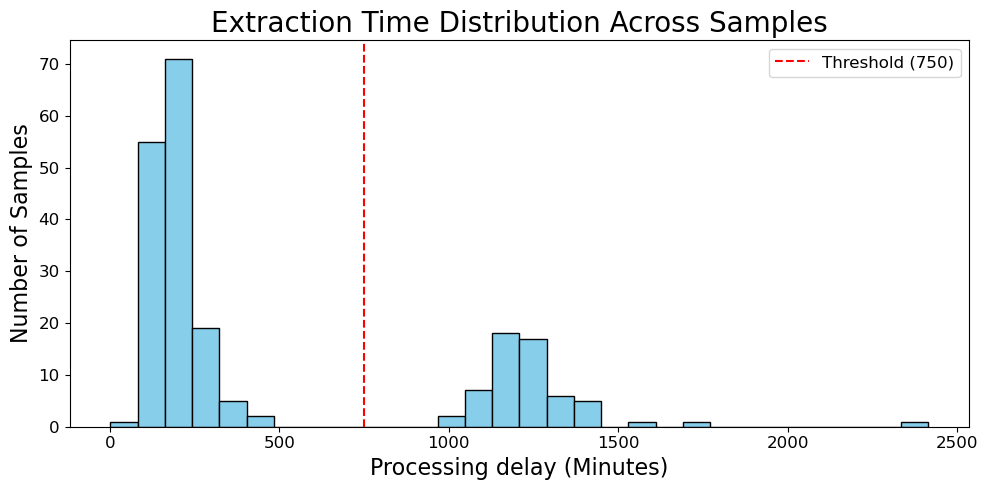

In [15]:
# visualize Extraction time distribution in Dataset
unique_samples = clonotype_df.drop_duplicates('Sample_ID')

plt.figure(figsize=(10, 5))
plt.hist(unique_samples['extraction_time'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(TIME_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({TIME_THRESHOLD})')
plt.xlabel('Processing delay (Minutes)', fontsize=16)
plt.ylabel('Number of Samples', fontsize=16)
plt.title('Extraction Time Distribution Across Samples', fontsize=20)
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
save_plot("../colon/sample_time_distribution.svg", format="svg")

plt.show()

In [16]:
# Extract unique repertoire sets (Amino Acid CDR3s)
fast_clonotypes = set(fast_group["aaSeqCDR3"])
slow_clonotypes = set(slow_group["aaSeqCDR3"])

print("-" * 40)
print(f"Total clones (rows) in Fast group: {len(fast_group)}")
print(f"Total clones (rows) in Slow group: {len(slow_group)}")
print("-" * 40)
print(f"Unique CDR3s in Fast repertoire:   {len(fast_clonotypes)}")
print(f"Unique CDR3s in Slow repertoire:   {len(slow_clonotypes)}")

num_fast_samples = fast_group["Sample_ID"].nunique()
num_slow_samples = slow_group["Sample_ID"].nunique()

# Count clonotypes per sample 
fast_clonotypes_per_sample = (
    fast_group.groupby("Sample_ID")["aaSeqCDR3"].nunique()
)
slow_clonotypes_per_sample = (
    slow_group.groupby("Sample_ID")["aaSeqCDR3"].nunique()
)

avg_fast = fast_clonotypes_per_sample.mean()
med_fast = fast_clonotypes_per_sample.median()
avg_slow = slow_clonotypes_per_sample.mean()
med_slow = slow_clonotypes_per_sample.median()

# Print results
num_fast_samples = fast_group["Sample_ID"].nunique()
num_slow_samples = slow_group["Sample_ID"].nunique()

print(f"Number of samples in fast group: {num_fast_samples}")
print(f"Average clonotypes per fast sample: {avg_fast:.1f}")
print(f"Median clonotypes per fast sample: {med_fast:.1f}\n")

print(f"Number of samples in slow group: {num_slow_samples}")
print(f"Average clonotypes per slow sample: {avg_slow:.1f}")
print(f"Median clonotypes per slow sample: {med_slow:.1f}")


----------------------------------------
Total clones (rows) in Fast group: 12982717
Total clones (rows) in Slow group: 2229779
----------------------------------------
Unique CDR3s in Fast repertoire:   8991978
Unique CDR3s in Slow repertoire:   1852705


Number of samples in fast group: 153
Average clonotypes per fast sample: 82060.1
Median clonotypes per fast sample: 75004.0

Number of samples in slow group: 58
Average clonotypes per slow sample: 37566.7
Median clonotypes per slow sample: 32296.5


In [17]:
clone_stats_df = pd.DataFrame({
    "Group": ["Fast", "Slow"],
    "Num Samples": [num_fast_samples, num_slow_samples],
    "Avg Clonotypes/Sample": [avg_fast, avg_slow],
    "Median Clonotypes/Sample": [med_fast, med_slow]
})

print(clone_stats_df.to_string(index=False, float_format='%.1f'))

Group  Num Samples  Avg Clonotypes/Sample  Median Clonotypes/Sample
 Fast          153                82060.1                   75004.0
 Slow           58                37566.7                   32296.5


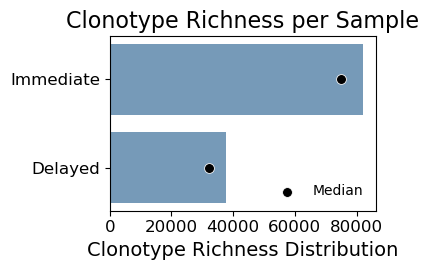

In [18]:
plot_df = clone_stats_df.melt(
    id_vars="Group",
    value_vars=["Avg Clonotypes/Sample", "Median Clonotypes/Sample"],
    var_name="Metric",
    value_name="Value")

plot_df["Group"] = plot_df["Group"].replace({
    "Fast": "Immediate", 
    "Slow": "Delayed"
})

plt.figure(figsize=(4, 2.8))

sns.barplot(
    data=plot_df[plot_df["Metric"] == "Avg Clonotypes/Sample"],
    x="Value", y="Group", color="steelblue",alpha=0.8)

sns.scatterplot(
    data=plot_df[plot_df["Metric"] == "Median Clonotypes/Sample"],
    x="Value",y="Group", color="black", s=50,zorder=10,label="Median")

plt.xlabel("Clonotype Richness Distribution", fontsize=14) 
plt.ylabel("")
plt.title("Clonotype Richness per Sample", fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(frameon=False)
plt.tight_layout()
save_plot("../colon/clonotype_richness.svg", format="svg", bbox_inches="tight")

plt.show()


# Subsampling samples to compare clonotypes depth

Plot number of unique clonotypes discovered as a function of the number of reads sampled (subsampling).
Shows whether diversity is saturated or still increasing — i.e., if the sample was deeply sequenced enough.

Rarefaction Limit: 209,378 reads


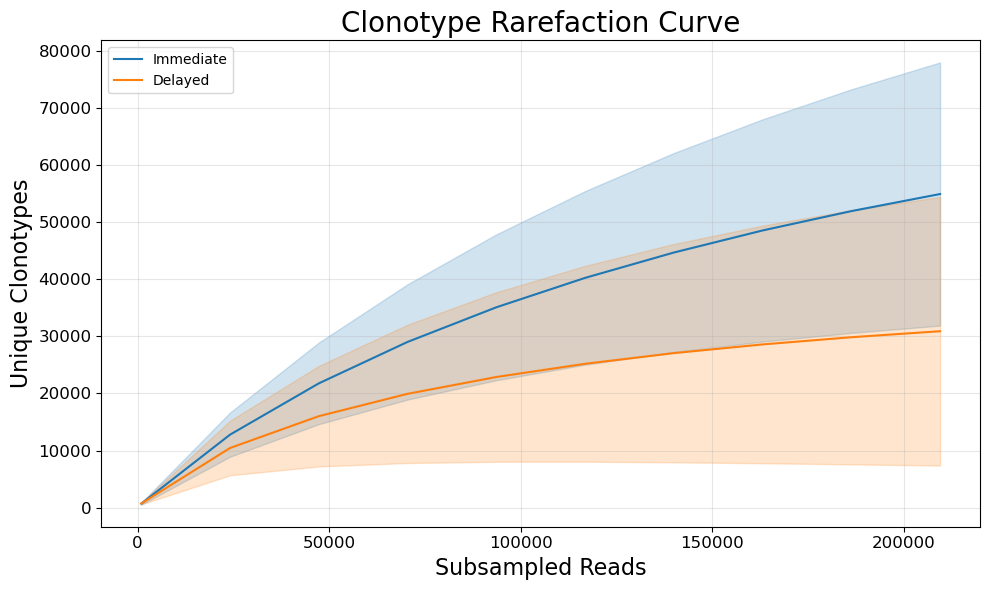

In [19]:
# limit by the sample with the fewest reads.
min_total_reads = clonotype_df.groupby("Sample_ID")["readCount"].sum().min()
max_curve_limit = int(min_total_reads) 

# Create 10 evenly spaced steps
depths = np.linspace(1000, max_curve_limit, num=10, dtype=int)
print(f"Rarefaction Limit: {max_curve_limit:,} reads")

rarefaction_results = []

# Iterate Per Sample
grouped_samples = clonotype_df.groupby(["Sample_ID", "group"])

for (sample_id, group_label), sample_data in grouped_samples:
    counts = sample_data["readCount"].values.astype(int)
    total_reads = counts.sum()
    # Skip if sample is too small
    if total_reads < depths[0]:
        continue

    # Instead of expanding strings ["CASS..", "CASS.."], we expand indices [0, 0]
    # np.repeat creates an array where index '0' appears 'count[0]' times
    # This represents the "Bag of Reads" using lightweight integers
    read_indices = np.repeat(np.arange(len(counts)), counts)
    
    np.random.shuffle(read_indices)
    
    for depth in depths:
        if depth > total_reads:
            break
        
        # Slicing the first 'depth' elements simulates sampling wihtout replacement
        subsample = read_indices[:depth]
        
        # Count unique integers (which correspond to unique clonotypes)
        unique_clonotypes = len(np.unique(subsample))
        
        rarefaction_results.append({
            "Sample_ID": sample_id,
            "group": group_label,
            "depth": depth,
            "unique_clonotypes": unique_clonotypes
        })

# Plotting
rarefaction_df = pd.DataFrame(rarefaction_results)

rarefaction_df["group"] = rarefaction_df["group"].replace({
    "fast": "Immediate",
    "slow": "Delayed"
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=rarefaction_df, x="depth", y="unique_clonotypes", hue="group",
            palette={"Immediate": "tab:blue", "Delayed": "tab:orange"}, estimator="mean",
            errorbar=("sd", 1) )

plt.title("Clonotype Rarefaction Curve", fontsize=20)
plt.xlabel("Subsampled Reads", fontsize=16)
plt.ylabel("Unique Clonotypes", fontsize=16)
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="")
plt.tight_layout()
save_plot("../colon/refraction_curve.svg", format="svg")

plt.show()


2 fast groups samples had 25000 singletone values (hugh outliners) so we adjusted ylim to 2000.

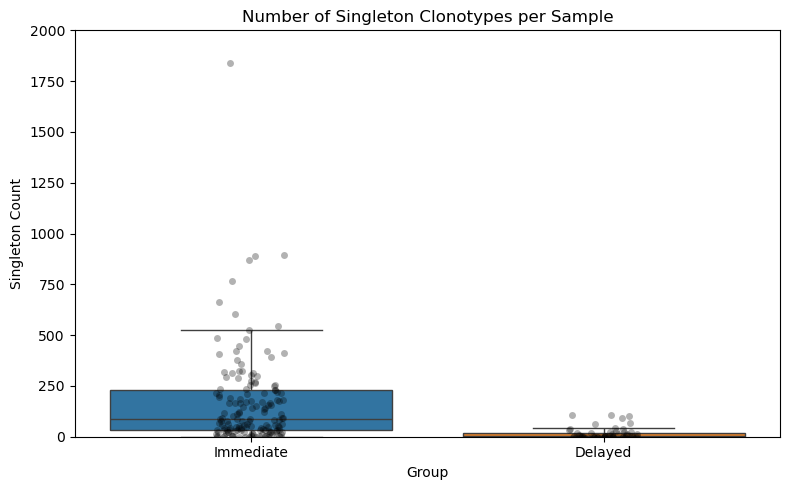

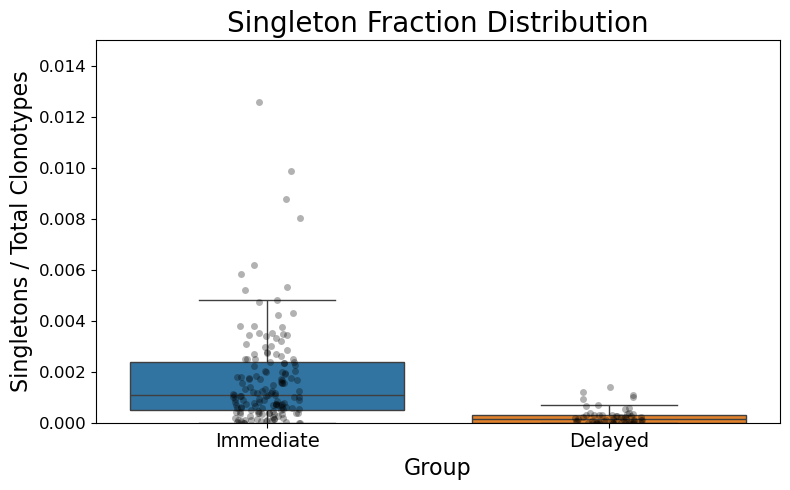

In [20]:
# Aggregate Statistics per Sample
sample_stats = (
    clonotype_df.groupby(["Sample_ID", "group"])
    .agg(
        total_clonotypes=("aaSeqCDR3", "nunique"),
        singleton_count=("readCount", lambda x: (x == 1).sum()))
    .reset_index()
)

#  Calculate Normalized Proportion
sample_stats["singleton_proportion"] = (
    sample_stats["singleton_count"] / sample_stats["total_clonotypes"])

sample_stats["group"] = sample_stats["group"].replace({
    "fast": "Immediate",
    "slow": "Delayed"
})
# visualization 1: absolute counts
plt.figure(figsize=(8, 5))

sns.boxplot(data=sample_stats, x="group", y="singleton_count", hue="group",
            showfliers=False, legend=False)

sns.stripplot(data=sample_stats, x="group", y="singleton_count", color="black",
            alpha=0.3, dodge=False)

plt.title("Number of Singleton Clonotypes per Sample")
plt.ylabel("Singleton Count")
plt.xlabel("Group")
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

# visualization 2: normalized proportions
plt.figure(figsize=(8, 5))

sns.boxplot(data=sample_stats, x="group", y="singleton_proportion", hue="group",
             showfliers=False, legend=False)

sns.stripplot(data=sample_stats, x="group", y="singleton_proportion", color="black",
            alpha=0.3, dodge=False)

plt.title("Singleton Fraction Distribution", fontsize=20)
plt.ylabel("Singletons / Total Clonotypes", fontsize=16)
plt.xlabel("Group", fontsize=16)
plt.ylim(0, 0.015)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12)
plt.tight_layout()
save_plot("../colon/normelized_singleton.svg", format="svg")
plt.show()


 Clonal Size Distribution Binning

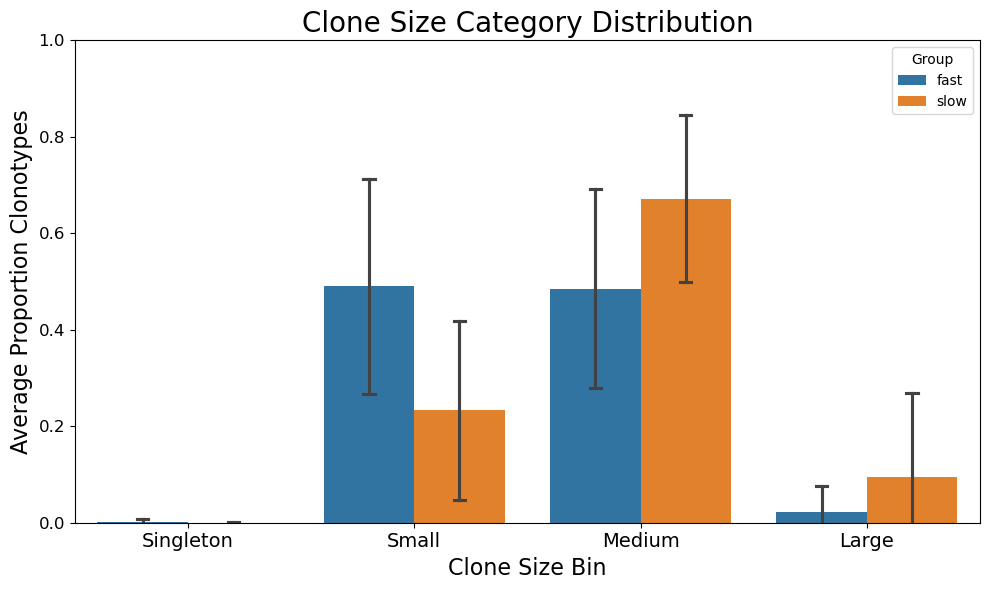

In [21]:
# 1. Vectorized Binning
bins = [0, 1, 10, 100, np.inf]
labels = ["Singleton", "Small", "Medium", "Large"]

clonotype_df["size_bin"] = pd.cut(
    clonotype_df["readCount"], 
    bins=bins, 
    labels=labels
)

# Aggregation per Sample
# We group by Sample and Group to distinguish timepoints
bin_counts = (
    clonotype_df.groupby(["Sample_ID", "group", "size_bin"], observed=False)
    .size()
    .reset_index(name="count"))

# Normalize (Proportions)
sample_totals = bin_counts.groupby(["Sample_ID", "group"])["count"].transform("sum")
bin_counts["proportion"] = bin_counts["count"] / sample_totals

plt.figure(figsize=(10, 6))

sns.barplot(data=bin_counts,x="size_bin", y="proportion",hue="group",
            palette="tab10", estimator="mean", errorbar="sd", capsize=0.1)

plt.title("Clone Size Category Distribution", fontsize=20)
plt.ylabel("Average Proportion Clonotypes", fontsize=16)
plt.xlabel("Clone Size Bin", fontsize=16)
plt.ylim(0, 1.0) 
plt.legend(title="Group")
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12)
plt.tight_layout()
# save_plot("../colon/clonal_size_dist.svg", format="svg")
plt.show()


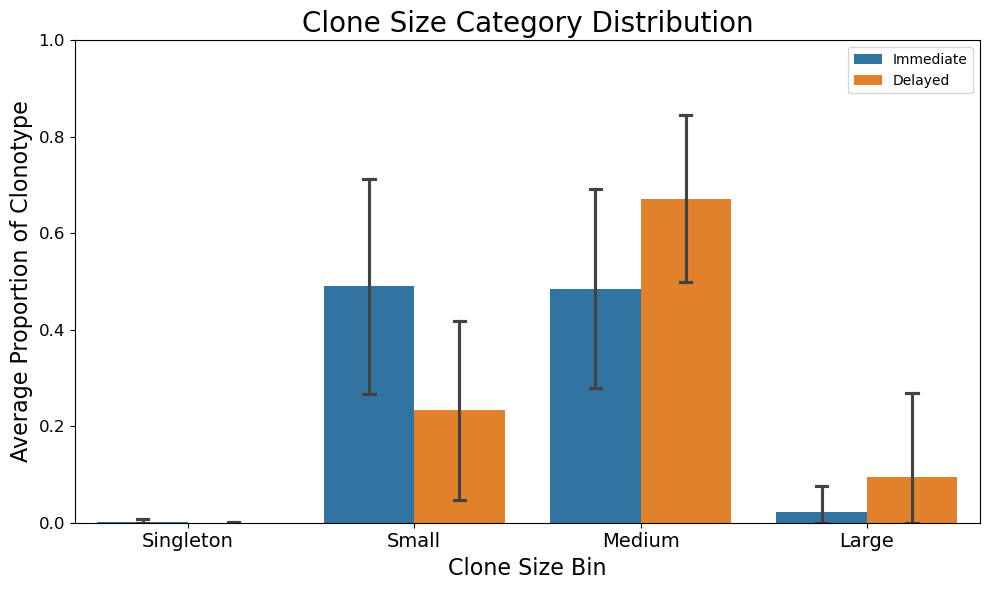

In [40]:
def clipped_sd(x):
    mean = np.mean(x)
    std = np.std(x, ddof=1)  # ddof=1 for sample standard deviation
    lower = max(0, mean - std) # This prevents the negative dip
    upper = mean + std
    return (lower, upper)

# Vectorized Binning
bins = [0, 1, 10, 100, np.inf]
labels = ["Singleton", "Small", "Medium", "Large"]

clonotype_df["size_bin"] = pd.cut(
    clonotype_df["readCount"], 
    bins=bins, 
    labels=labels
)

# Aggregation per Sample
# We group by Sample and Group to distinguish timepoints
bin_counts = (
    clonotype_df.groupby(["Sample_ID", "group", "size_bin"], observed=False)
    .size()
    .reset_index(name="count"))

# Normalize (Proportions)
sample_totals = bin_counts.groupby(["Sample_ID", "group"])["count"].transform("sum")
bin_counts["proportion"] = bin_counts["count"] / sample_totals

bin_counts["group"] = bin_counts["group"].replace({
    "fast": "Immediate", 
    "slow": "Delayed"
})
plt.figure(figsize=(10, 6))

sns.barplot(
    data=bin_counts,
    x="size_bin", 
    y="proportion",
    hue="group",
    palette="tab10", 
    estimator="mean", 
    errorbar=clipped_sd,  
    capsize=0.1, 
    hue_order=["Immediate", "Delayed"]
)

plt.title("Clone Size Category Distribution", fontsize=20)
plt.ylabel("Average Proportion of Clonotype", fontsize=16)
plt.xlabel("Clone Size Bin", fontsize=16)
plt.ylim(0, 1.0) 
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12)
plt.legend(title="")
plt.tight_layout()
save_plot("../colon/clonal_size_dist.svg", format="svg")
plt.show()

# Scirpy - analyzing repertoire difference via extraction time

### Shannon Diversity

In [7]:
import scirpy as ir
import anndata as ad

Matplotlib is building the font cache; this may take a moment.


In [8]:
def build_airr_df(group_df: pd.DataFrame) -> pd.DataFrame:
    df = group_df.copy()
    df = df.assign(
        cell_id=[f"{sid}_{i}" for i, sid in zip(df.index, df["Sample_ID"])],
        locus="TRB",
        junction_aa=df["aaSeqCDR3"],
        productive=True,
        duplicate_count=df["readCount"],
        sample_id=df["Sample_ID"],)
    return df[["cell_id", "locus", "junction_aa", "productive",
               "duplicate_count", "sample_id", "extraction_time"]]

def make_adata(airr_df: pd.DataFrame, group_label: str):
    adata = ir.io.read_airr(
        airr_df,
        cell_attributes=["sample_id", "extraction_time", "junction_aa"]
    )
    adata.obs["group"] = group_label
    ir.tl.alpha_diversity(
        adata,
        groupby="sample_id",
        target_col="junction_aa",
        metric="shannon"
    )
    div = (
        adata.obs.groupby("sample_id", as_index=False)
        .agg(
            extraction_time=("extraction_time", "first"),
            shannon_junction_aa=("shannon_junction_aa", "mean"),
            group=("group", "first"),))
    return adata, div

fast_df = build_airr_df(fast_group)
slow_df = build_airr_df(slow_group)

fast_adata, fast_div = make_adata(fast_df, "fast")
slow_adata, slow_div = make_adata(slow_df, "slow")

/home/dsi/orrbavly/miniconda3/envs/scirpy/lib/python3.10/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


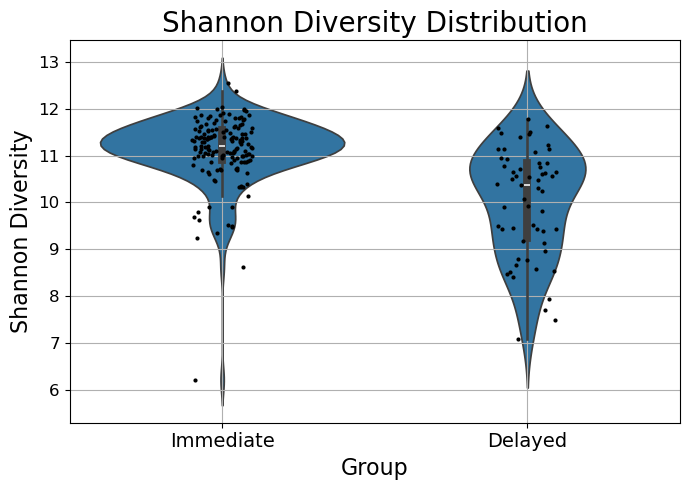

In [14]:
# Aggregate diversity scores per sample
fast_div = (
    fast_adata.obs.groupby("sample_id")
    .agg({
        "extraction_time": "first",
        "shannon_junction_aa": "mean",
        "group": "first"
    })
    .reset_index())

slow_div = (
    slow_adata.obs.groupby("sample_id")
    .agg({
        "extraction_time": "first",
        "shannon_junction_aa": "mean",
        "group": "first"
    })
    .reset_index())

# Combine
diversity_df = pd.concat([fast_div, slow_div], ignore_index=True)
diversity_df = diversity_df.rename(columns={"shannon_junction_aa": "shannon_diversity"})

# Rename the group values directly in the dataframe
diversity_df["group"] = diversity_df["group"].replace({
    "fast": "Immediate", 
    "slow": "Delayed"
})

plt.figure(figsize=(7, 5))
sns.violinplot(x="group", y="shannon_diversity", data=diversity_df, inner="box") 
sns.stripplot(x="group", y="shannon_diversity", data=diversity_df, color="black", size=3, jitter=True)

plt.title("Shannon Diversity Distribution", fontsize=20)
plt.ylabel("Shannon Diversity",fontsize=16)
plt.xlabel("Group", fontsize=16)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12) 
plt.grid(True)
plt.tight_layout()

save_plot("/home/dsi/orrbavly/GNN_project/testing_scripts/colon/diversity_plot.svg", format="svg")

plt.show()

Shannon diversity:
Measures how broad the immune response is.<br>
Whether the TCR repertoire is dominated by a few clonotypes (low diversity)
Or is diverse and evenly expressed (high diversity).

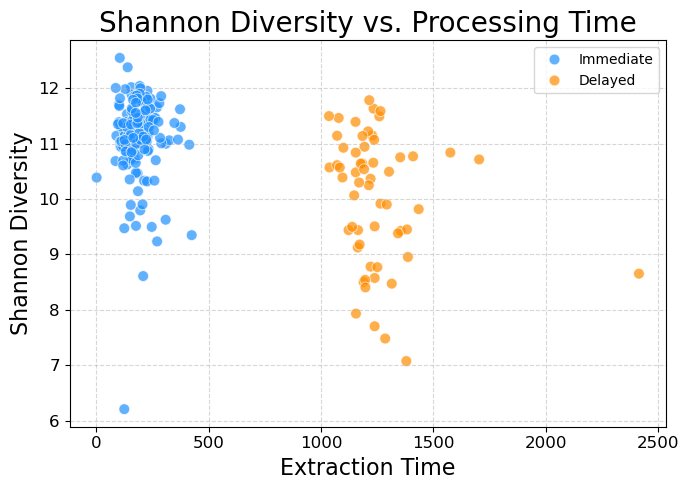

In [ ]:
# Scatter Plot (Time vs Diversity)
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=diversity_df,
    x="extraction_time",
    y="shannon_diversity",
    hue="group",
    palette={"Immediate": "dodgerblue", "Delayed": "darkorange"},
    alpha=0.7,
    s=60
)
plt.title("Shannon Diversity vs. Processing Time", fontsize=20)
plt.xlabel("Extraction Time", fontsize=16)
plt.ylabel("Shannon Diversity", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tick_params(axis="both", labelsize=12)
plt.legend(title="")
plt.tight_layout()

save_plot("../colon/shannon_vs_group_plot.svg", format="svg")

plt.show()

### Dominance analysis

How dominant is the top clone per sample?
Lets measure whether slower freezing leads to skewed repertoires dominated by one or few clones.


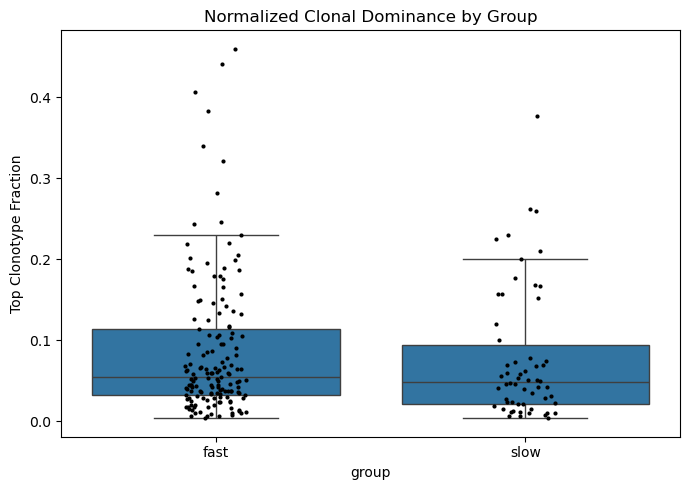

In [4]:
# Top clonotype read count (With group info)
dominance_df = (
    clonotype_df.groupby(["Sample_ID", "aaSeqCDR3", "group", "extraction_time"])["readCount"]
    .sum()
    .reset_index()
    .sort_values(["Sample_ID", "readCount"], ascending=[True, False])
    .groupby("Sample_ID")
    .first()
    .reset_index()
    .rename(columns={"readCount": "top_clone_reads"}))

# Total reads per sample
total_reads_df = (
    clonotype_df.groupby("Sample_ID")["readCount"]
    .sum()
    .reset_index()
    .rename(columns={"readCount": "total_reads"}))

dominance_df = dominance_df.merge(total_reads_df, on="Sample_ID", how="left")
dominance_df["dominance_fraction"] = dominance_df["top_clone_reads"] / dominance_df["total_reads"]

plt.figure(figsize=(7, 5))
sns.boxplot(data=dominance_df, x="group", y="dominance_fraction", showfliers=False)
sns.stripplot(data=dominance_df, x="group", y="dominance_fraction", color="black", size=3, jitter=True)
plt.ylabel("Top Clonotype Fraction")
plt.title("Normalized Clonal Dominance by Group")
plt.tight_layout()
plt.show()

/tmp/ipykernel_285019/1411159983.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["readCount"].head(top_n).sum() / g["readCount"].sum())


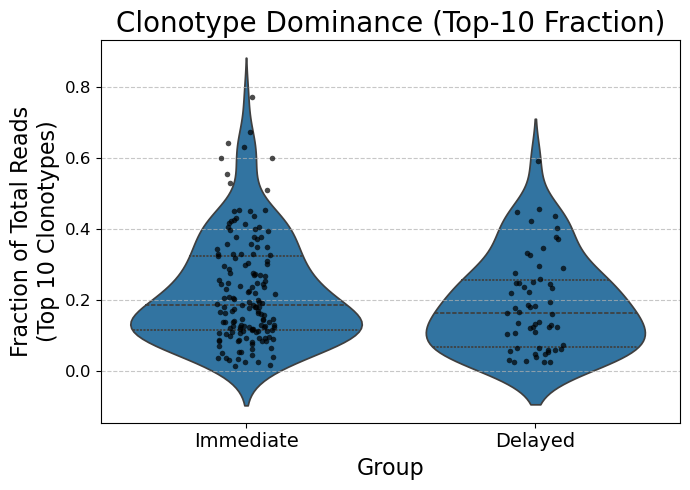

In [32]:
# Compute Top-N Clone Fraction
top_n = 10
top10_df = (
    clonotype_df
    .sort_values(["Sample_ID", "readCount"], ascending=[True, False])
    .groupby(["Sample_ID", "group", "extraction_time"])
    .apply(lambda g: g["readCount"].head(top_n).sum() / g["readCount"].sum())
    .reset_index(name=f"top{top_n}_fraction") )

top10_df["group"] = top10_df["group"].replace({
    "fast": "Immediate",
    "slow": "Delayed"
})
plt.figure(figsize=(7, 5))
sns.violinplot(
    data=top10_df, x="group",
    y=f"top{top_n}_fraction", inner="quartile")

sns.stripplot(data=top10_df, x="group", y=f"top{top_n}_fraction",
               color="black", size=4, jitter=True,alpha=0.7)

plt.title(f"Clonotype Dominance (Top-{top_n} Fraction)", fontsize=20)
plt.ylabel(f"Fraction of Total Reads\n(Top {top_n} Clonotypes)", fontsize=16)
plt.xlabel("Group", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12)  
plt.tight_layout()

save_plot("/home/dsi/orrbavly/GNN_project/testing_scripts/colon/top_clonotype_plot.svg", format="svg")
plt.show()

### Gini Index

The Gini index measures inequality (Clonal inequality). In repertoire analysis:

0 = perfectly equal (all clonotypes have the same size)

1 = perfect inequality (all reads go to one clone) - More skewed repertoire

It captures clonal skew across the full distribution, not just top clones.



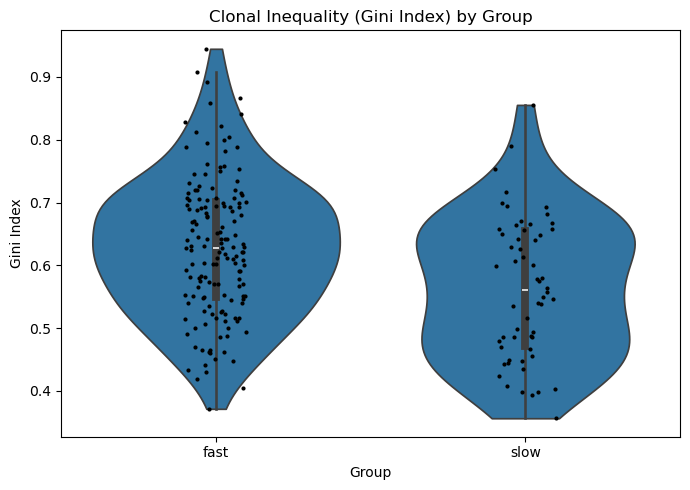

In [8]:
def gini(array):
    """Compute Gini index (inequality) of an array."""
    array = np.array(array).flatten()
    if len(array) == 0: return 0

    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    # Gini formula
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

#  Gini calculation
gini_df = (
    clonotype_df
    .groupby(["Sample_ID", "group", "extraction_time"])["readCount"]
    .apply(gini)
    .reset_index(name="gini_index") 
)


# Plot
plt.figure(figsize=(7, 5))

sns.violinplot(
    data=gini_df,
    x="group",
    y="gini_index",
    inner="box",
    cut=0,
    legend=False)

sns.stripplot(data=gini_df,x="group",y="gini_index",color="black",
              size=3, jitter=True, dodge=False)

plt.title("Clonal Inequality (Gini Index) by Group")
plt.ylabel("Gini Index")
plt.xlabel("Group")
plt.tight_layout()
plt.show()


### Clonal Evenness

This measures how evenly the reads are distributed across clones (Diversity normalized by richness).
High value means More uniform clone distribution.

It corrects Shannon entropy to account for how many clones there are — helps distinguish between:

Broad but skewed repertoires

Broad and even repertoires

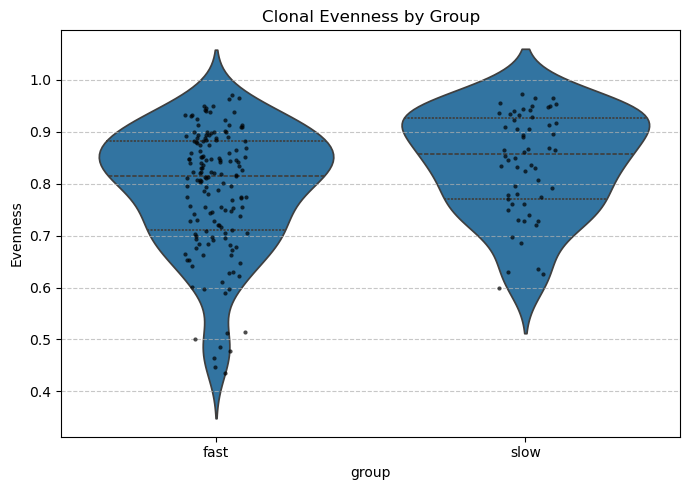

In [11]:
from scipy.stats import entropy

def compute_evenness(reads):
    total = reads.sum()
    if total == 0: return 0
    proportions = reads / total
    shannon = entropy(proportions)
    richness = len(reads) 
    
    return shannon / np.log(richness) if richness > 1 else 0

evenness_df = (
    clonotype_df
    .groupby(["Sample_ID", "group", "extraction_time"])["readCount"]
    .apply(compute_evenness)
    .reset_index(name="evenness")
)

# Violin
plt.figure(figsize=(7, 5))
sns.violinplot(data=evenness_df, x="group", y="evenness", inner="quartile")
sns.stripplot(data=evenness_df, x="group", y="evenness", color="black", size=3, jitter=True, alpha=0.7)

plt.title("Clonal Evenness by Group")
plt.ylabel("Evenness")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Simpson diversity

Emphasizes common clones — penalizes dominance.
The Simpson diversity index measures the probability that two randomly chosen reads belong to different clonotypes.

Closer to 1 → High diversity, many clones with similar frequencies.

Closer to 0 → Low diversity, few dominant clones.

It emphasizes dominant clones more heavily than Shannon entropy.

In [17]:
# Add Simpson diversity to existing adata objects
ir.tl.alpha_diversity(fast_adata, groupby="sample_id", target_col="junction_aa", metric="simpson")
ir.tl.alpha_diversity(slow_adata, groupby="sample_id", target_col="junction_aa", metric="simpson")

# Extract and merge
fast_simpson = (
    fast_adata.obs.groupby("sample_id")
    .agg({"simpson_junction_aa": "mean", "extraction_time": "first"})
    .reset_index()
)
fast_simpson["group"] = "fast"

slow_simpson = (
    slow_adata.obs.groupby("sample_id")
    .agg({"simpson_junction_aa": "mean", "extraction_time": "first"})
    .reset_index()
)
slow_simpson["group"] = "slow"

simpson_df = pd.concat([fast_simpson, slow_simpson], ignore_index=True)
simpson_df = simpson_df.rename(columns={"simpson_junction_aa": "simpson_diversity"})


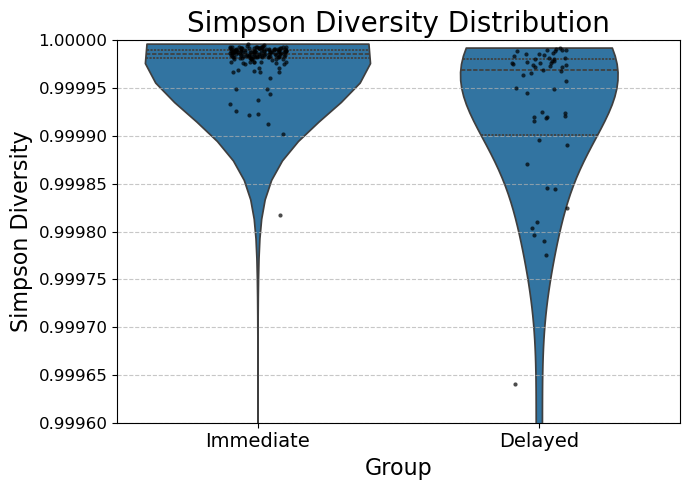

In [24]:
# Rename the group values
simpson_df["group"] = simpson_df["group"].replace({
    "fast": "Immediate", 
    "slow": "Delayed"
})

plt.figure(figsize=(7, 5))
ax = sns.violinplot(data=simpson_df, x="group", y="simpson_diversity", inner="quartile", cut=0)
sns.stripplot(data=simpson_df, x="group", y="simpson_diversity", color="black", size=3, jitter=True, alpha=0.7)

ax.set_ylim(0.9996, 1.000)
ax.ticklabel_format(style="plain", axis="y", useOffset=False)

plt.ylabel("Simpson Diversity", fontsize=16)
plt.xlabel("Group", fontsize=16)
plt.title("Simpson Diversity Distribution", fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=12)  
plt.tight_layout()

save_plot("/home/dsi/orrbavly/GNN_project/testing_scripts/colon/simpson_diversity_plot.svg", format="svg")

plt.show()


# Gene Usage

Lets analyze the Gene usage in each of the groups (Immediate vs Delayed). First, we will analyze the whole group repertiore (including shared clonotypes).

In [43]:
def extract_clean_genes(df, col_map):
    """
    Parses gene columns (e.g., 'TRBV1*01,TRBV1*02'),removes allele info (*01),
    and returns a clean long-format DataFrame.
    """
    processed = df.copy()
    melted_dfs = []
    id_cols = ["Sample_ID", "group", "subset_label", "readCount"]

    for original_col, new_col_name in col_map.items():
        temp = processed[id_cols + [original_col]].dropna(subset=[original_col])
        temp[new_col_name] = temp[original_col].str.split(",")
        temp = temp.explode(new_col_name)
        temp[new_col_name] = temp[new_col_name].str.split("*").str[0]
        temp["gene_type"] = new_col_name
        temp = temp.rename(columns={new_col_name: "gene_name"})
        melted_dfs.append(temp[["Sample_ID", "group", "subset_label", "gene_type", "gene_name", "readCount"]])

    return pd.concat(melted_dfs, ignore_index=True)


In [44]:
GENE_COLS = {
    "allVHitsWithScore": "V_gene",
    "allDHitsWithScore": "D_gene",
    "allJHitsWithScore": "J_gene"
}

# Use the full clonotype dataframe (No filtering for uniques)
df_all = clonotype_df.copy()

# Map the group names to cleaner labels for the plot
# (Capitalized for better visuals)
df_all["subset_label"] = df_all["group"].map({
    "fast": "Fast (Total)", 
    "slow": "Slow (Total)"
})

# Run the cleaning
long_gene_df = extract_clean_genes(df_all, GENE_COLS)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd3115bad40>>
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/scirpy/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd3115bad40>>
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/scirpy/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd3115bad40>>
Traceback (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/scirpy/lib/python3.10/si

/tmp/ipykernel_285019/2261489010.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["subset_label"] = plot_data["subset_label"].replace({


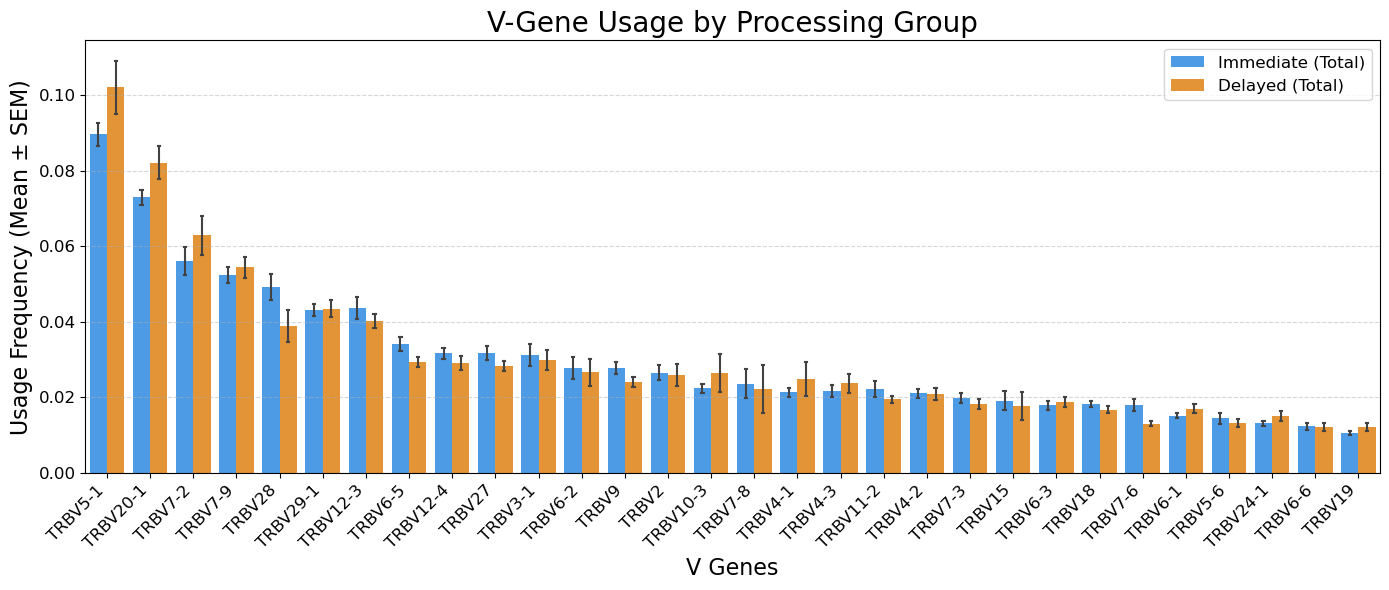

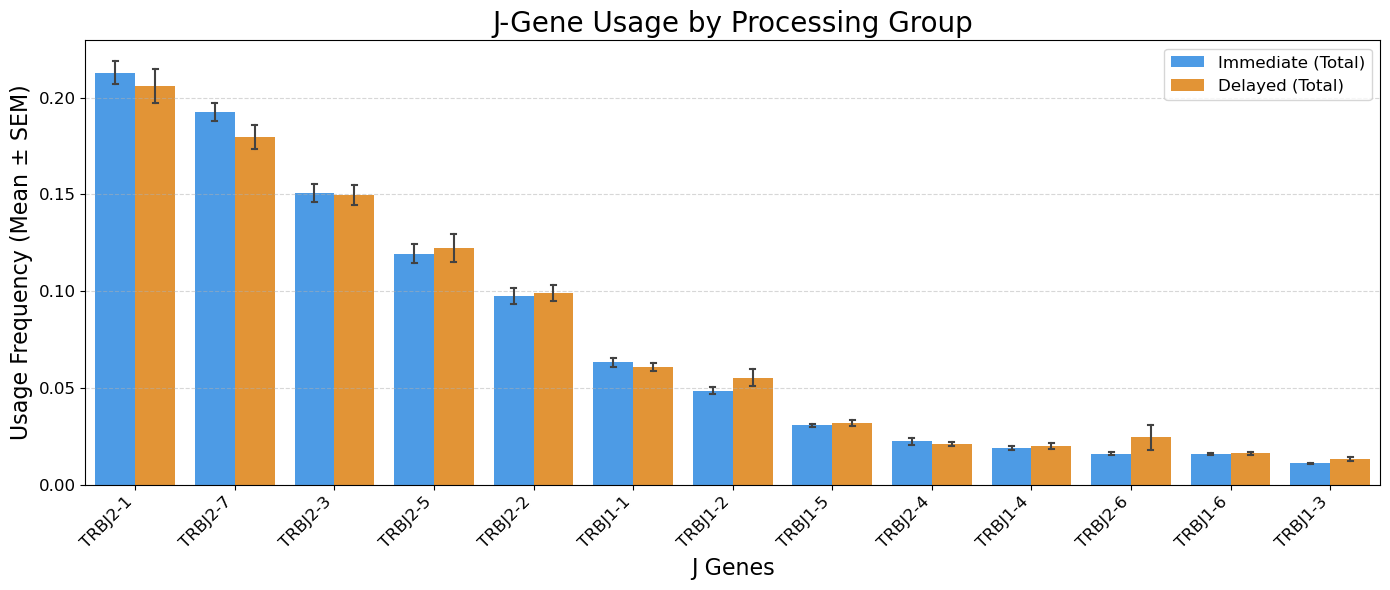

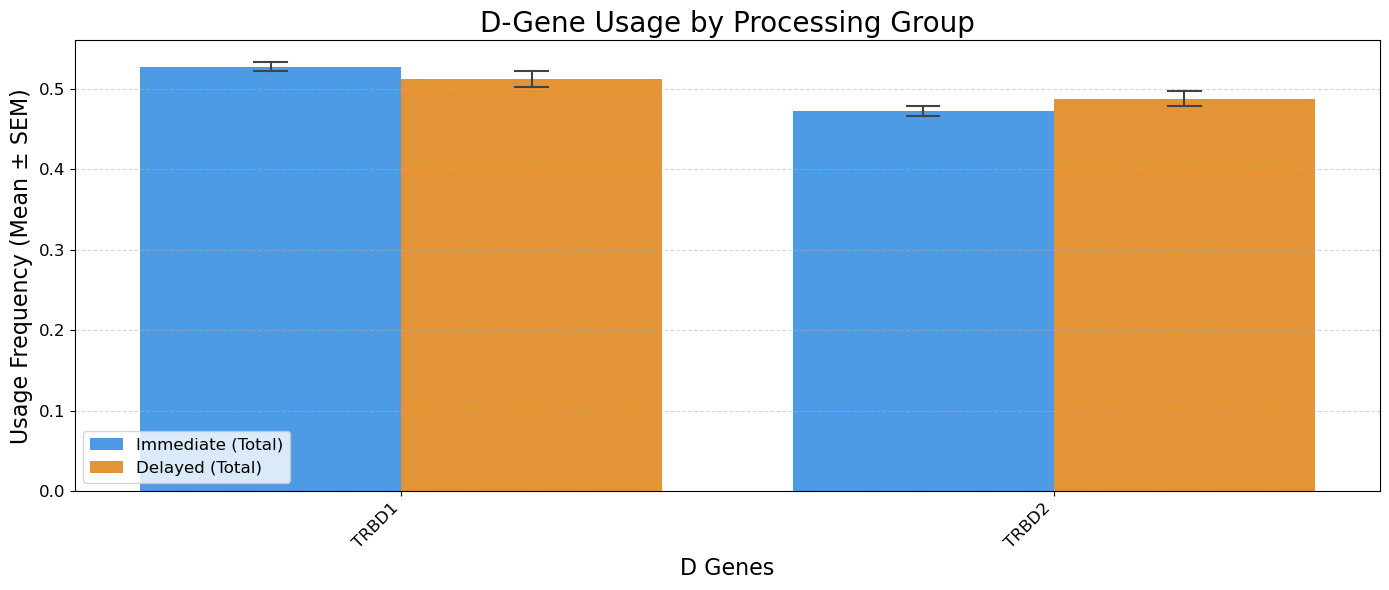

In [51]:
# Calculate Usage Frequencies Per Sample

# Group by Sample and Gene to sum read counts Using 'readCount' weights by abundance.
# Using size() weights by diversity.
sample_gene_counts = (
    long_gene_df.groupby(["Sample_ID", "group", "subset_label", "gene_type", "gene_name"])["readCount"]
    .sum()
    .reset_index())

# Calculate Total Reads per Gene Type per Sample for normalization (e.g., Total V-gene usage for Sample1)
sample_totals = (
    sample_gene_counts.groupby(["Sample_ID", "gene_type"])["readCount"]
    .transform("sum"))

# Calculate Frequency (Proportion)
sample_gene_counts["usage_frequency"] = sample_gene_counts["readCount"] / sample_totals

# Plotting 
def plot_top_genes_with_errorbars(data, gene_col, title, top_n=30):
    """
    Plot the top_n Genes, with error bars.
    """
    subset = data[data["gene_type"] == gene_col].copy()

    if top_n is not None:
        gene_order = (subset.groupby("gene_name")["usage_frequency"]
                      .mean().sort_values(ascending=False)
                      .head(top_n).index.tolist())
        plot_data = subset[subset["gene_name"].isin(gene_order)]
    else:
        gene_order = (subset.groupby("gene_name")["usage_frequency"]
                      .mean().sort_values(ascending=False)
                      .index.tolist())
        plot_data = subset

    plt.figure(figsize=(14, 6))
    plot_data["subset_label"] = plot_data["subset_label"].replace({
        "Fast (Total)": "Immediate (Total)", 
        "Slow (Total)": "Delayed (Total)",
        "fast": "Immediate (Total)", 
        "slow": "Delayed (Total)"
    })
    sns.barplot(
        data=plot_data, x="gene_name", y="usage_frequency", hue="subset_label",
        order=gene_order,
        palette={
            "Immediate (Total)": "dodgerblue", 
            "Delayed (Total)": "darkorange"
        },
        errorbar="se", capsize=0.1, err_kws={'linewidth': 1.5}, alpha=0.9
    )
    plt.title(title, fontsize=20,)
    x_label = f"{gene_col.split('_')[0]} Genes"
    plt.xlabel(f"{x_label}", fontsize=16)
    plt.ylabel("Usage Frequency (Mean ± SEM)", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    save_plot(f"../colon/fast_slow_only_{gene_col}_usage_plot.svg", format="svg")

    plt.show()

# Generate Plots 
plot_top_genes_with_errorbars(sample_gene_counts, "V_gene", "V-Gene Usage by Processing Group", top_n=30)
plot_top_genes_with_errorbars(sample_gene_counts, "J_gene", "J-Gene Usage by Processing Group", top_n=30)
plot_top_genes_with_errorbars(sample_gene_counts, "D_gene", "D-Gene Usage by Processing Group", top_n=30)

Now, lets explore the difference between group specific TCRs to Shared TCRs.

In [50]:
# Define Subsets

# Get the set of CDR3s for each group
fast_cdr3s = set(clonotype_df[clonotype_df["group"] == "fast"]["aaSeqCDR3"])
slow_cdr3s = set(clonotype_df[clonotype_df["group"] == "slow"]["aaSeqCDR3"])

# Define the 3 sets
shared_cdr3s = fast_cdr3s.intersection(slow_cdr3s)
fast_only_cdr3s = fast_cdr3s - slow_cdr3s
slow_only_cdr3s = slow_cdr3s - fast_cdr3s

# Create a mapping dictionary for fast lookup
cdr3_to_label = {}
for cdr3 in fast_only_cdr3s: cdr3_to_label[cdr3] = "Fast Unique"
for cdr3 in slow_only_cdr3s: cdr3_to_label[cdr3] = "Slow Unique"
for cdr3 in shared_cdr3s:    cdr3_to_label[cdr3] = "Shared"

# Apply the labels to the main dataframe
df_3way = clonotype_df.copy()
df_3way["subset_label"] = df_3way["aaSeqCDR3"].map(cdr3_to_label)

# Filter out rows that might not match 
df_3way = df_3way.dropna(subset=["subset_label"])

# Clean Genes
long_gene_df_3way = extract_clean_genes(df_3way, GENE_COLS)

# Calculate Usage Frequencies Per Sample Per Subset

# Sum reads by Sample & Subset (e.g., Sample_1's usage within "Shared" vs Sample_1's usage within "Fast Unique")
sample_gene_counts_3way = (long_gene_df_3way.groupby(["Sample_ID", "subset_label", "gene_type", "gene_name"])["readCount"]
    .sum().reset_index())

# Calculate Total Reads per "Subset" per Sample (Ensures in-group normalization)
subset_totals = (sample_gene_counts_3way.groupby(["Sample_ID", "subset_label", "gene_type"])["readCount"]
    .transform("sum"))

sample_gene_counts_3way["usage_frequency"] = sample_gene_counts_3way["readCount"] / subset_totals



/tmp/ipykernel_285019/2087669972.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["subset_label"] = plot_data["subset_label"].replace({


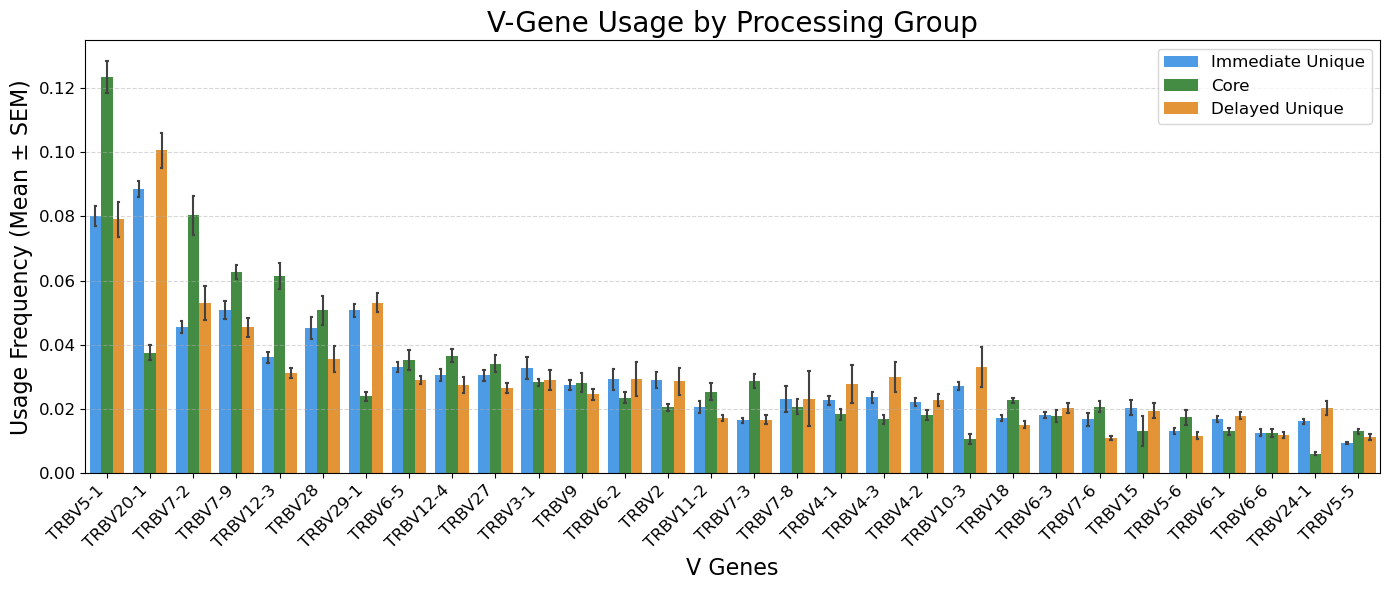

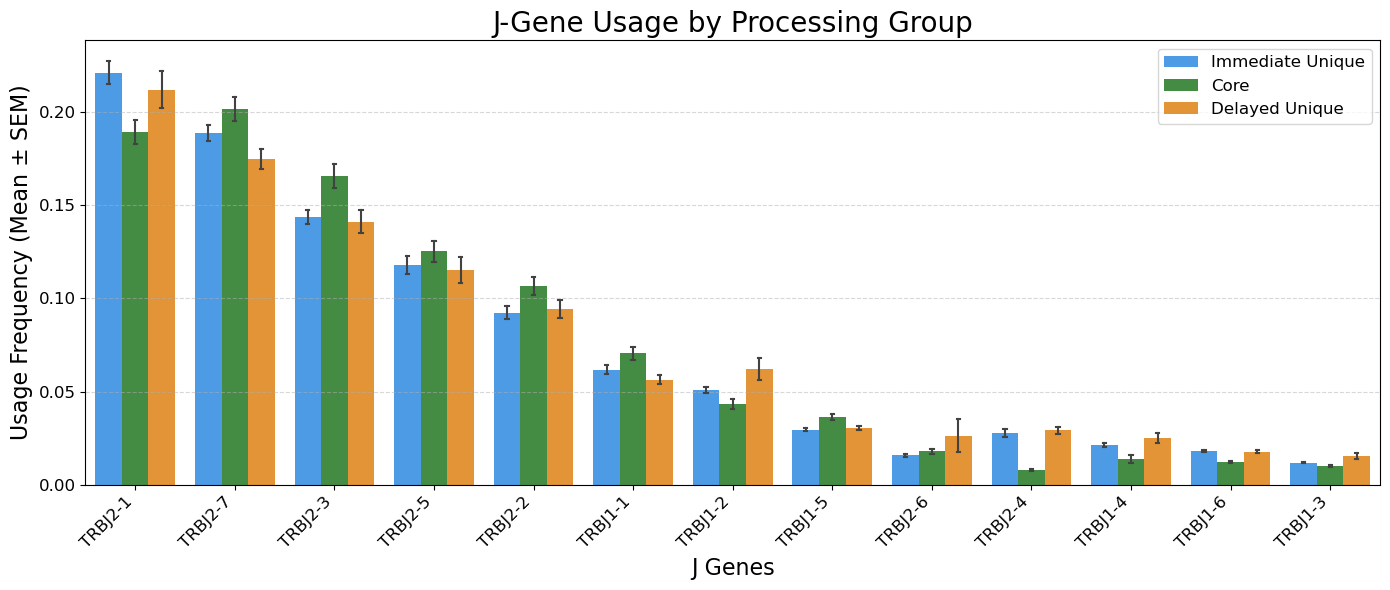

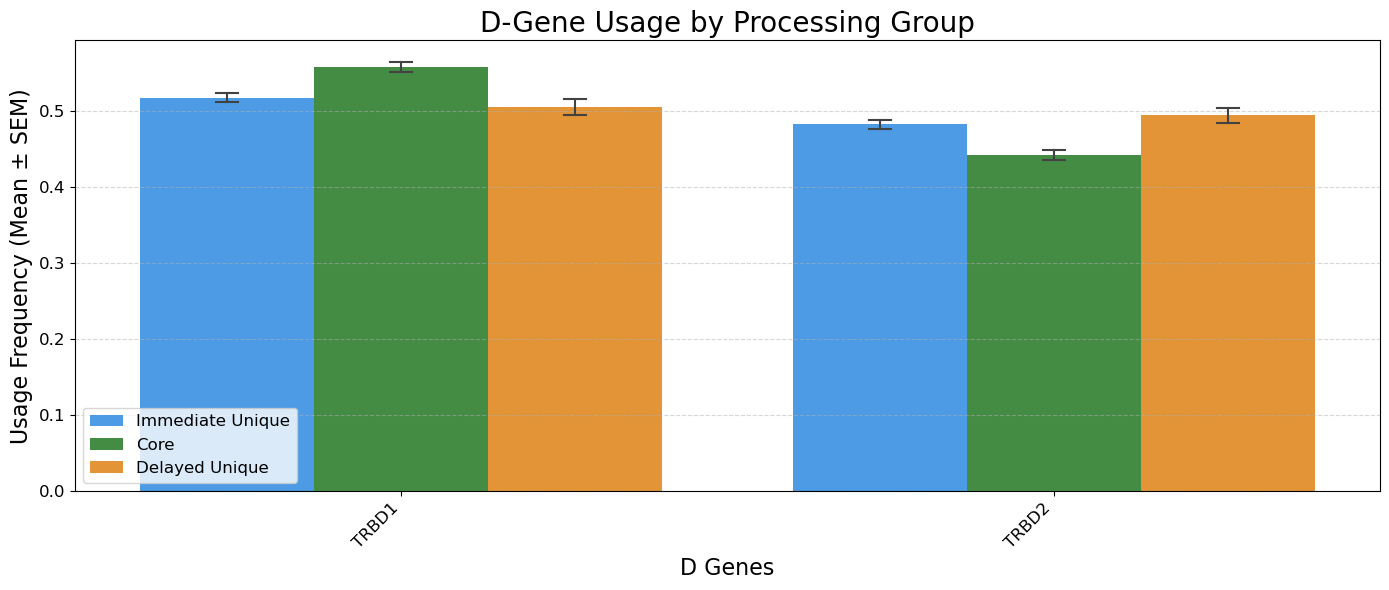

In [54]:
# Plotting
def plot_3way_genes_with_errorbars(data, gene_col, title, top_n=30):
    """
    Plots the top N genes with error bars for 3 groups.
    Adapted from the previous function to handle the 3-color palette.
    """
    subset = data[data["gene_type"] == gene_col].copy()
    
    # Identify Top N genes based on global average frequency across all subsets
    if top_n is not None:
        top_genes = (subset.groupby("gene_name")["usage_frequency"]
                      .mean().sort_values(ascending=False)
                      .head(top_n).index.tolist())
        plot_data = subset[subset["gene_name"].isin(top_genes)]
    else:
        top_genes = (subset.groupby("gene_name")["usage_frequency"]
                      .mean().sort_values(ascending=False)
                      .index.tolist())
        plot_data = subset
    
    plt.figure(figsize=(14, 6))
    plot_data["subset_label"] = plot_data["subset_label"].replace({
        "Shared": "Core",                   
        "Fast Unique": "Immediate Unique",  
        "Slow Unique": "Delayed Unique"    
    })
    sns.barplot(data=plot_data,x="gene_name", y="usage_frequency", hue="subset_label", order=top_genes,
            palette={
            "Immediate Unique": "dodgerblue", 
            "Delayed Unique": "darkorange", 
            "Core": "forestgreen"
            }, errorbar="se", capsize=0.1, err_kws={'linewidth': 1.5},alpha=0.9)
    
    plt.title(title, fontsize=20)
    x_label = f"{gene_col.split('_')[0]} Genes"
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel("Usage Frequency (Mean ± SEM)", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    save_plot(f"../colon/shared_fast_slow_{gene_col}_usage_plot.svg", format="svg")

    plt.show()


plot_3way_genes_with_errorbars(sample_gene_counts_3way, "V_gene", "V-Gene Usage by Processing Group", top_n=30)
plot_3way_genes_with_errorbars(sample_gene_counts_3way, "J_gene", "J-Gene Usage by Processing Group", top_n=30)
plot_3way_genes_with_errorbars(sample_gene_counts_3way, "D_gene", "D-Gene Usage by Processing Group", top_n=30)

# Survivors with shared Nucleotide Seq

Among TCRs that share the same amino acid CDR3 (aaSeqCDR3) between fast and slow samples, how many:

- Have the same nucleotide sequence (nSeqCDR3)?

- Have different nucleotide sequences?

In [6]:
# Convergent Recombination Analysis (Shared AA, Distinct NT)
df_unique = clonotype_df[["aaSeqCDR3", "nSeqCDR3", "group"]].dropna().drop_duplicates()

# Pivot: Collect NT sets for each AA, separating immediate/delayed into columns
shared_aa = df_unique.groupby(["aaSeqCDR3", "group"])["nSeqCDR3"].apply(set).unstack().dropna(subset=["fast", "slow"])

# Check if the set of Nucleotides is identical between groups
same_mask = shared_aa["fast"] == shared_aa["slow"]

# Extract lists for downstream analysis
same_nt = shared_aa.index[same_mask].tolist()
diff_nt = shared_aa.index[~same_mask].tolist()
survivors_set = set(same_nt + diff_nt)

# Statistics
total_shared = len(shared_aa)
print(f"Total shared AA sequences (intersection): {total_shared}")
print(f"Identical NT Usage: {len(same_nt)} ({len(same_nt)/total_shared:.1%})")
print(f"Convergent/Different NT Usage: {len(diff_nt)} ({len(diff_nt)/total_shared:.1%})")

Total shared AA sequences (intersection): 522619
Identical NT Usage: 6766 (1.3%)
Convergent/Different NT Usage: 515853 (98.7%)


In [7]:
# Filter the main dataframe to include only the "Convergent/Different" AA sequences
diff_nt_df = clonotype_df[clonotype_df["aaSeqCDR3"].isin(diff_nt)]

# Count distinct Nucleotide sequences per AA, per Group
nt_counts_per_group = (
    diff_nt_df.groupby(["aaSeqCDR3", "group"])["nSeqCDR3"]
    .nunique()
    .unstack(fill_value=0)
)

nt_counts_per_group.columns = ["n_nt_fast", "n_nt_slow"]

nt_counts_per_group["total_variants"] = nt_counts_per_group["n_nt_fast"] + nt_counts_per_group["n_nt_slow"]

# Results 
print("Head of Nucleotide Counts per Group:")
print(nt_counts_per_group.head())

print("\nSummary Statistics:")
print(nt_counts_per_group.describe())

# Check if one group tends to have more variants than the other
print(f"\nAverage Variants per AA - Fast: {nt_counts_per_group['n_nt_fast'].mean():.2f}")
print(f"Average Variants per AA - Slow: {nt_counts_per_group['n_nt_slow'].mean():.2f}")

Head of Nucleotide Counts per Group:
                n_nt_fast  n_nt_slow  total_variants
aaSeqCDR3                                           
CAAADNYGYTF             1          1               2
CAAAGGNTEAFF            1          1               2
CAAAGQGSTDTQYF          1          1               2
CAAAGSGNTIYF            1          1               2
CAAAGSSYNEQFF           2          1               3

Summary Statistics:
           n_nt_fast      n_nt_slow  total_variants
count  515853.000000  515853.000000   515853.000000
mean        4.715415       1.615621        6.331036
std         7.257725       1.800417        8.799184
min         1.000000       1.000000        2.000000
25%         1.000000       1.000000        2.000000
50%         2.000000       1.000000        3.000000
75%         5.000000       2.000000        7.000000
max       200.000000      73.000000      262.000000

Average Variants per AA - Fast: 4.72
Average Variants per AA - Slow: 1.62


In [9]:
import pandas as pd
import numpy as np

def analyze_top_tier_dominance(
    df: pd.DataFrame, 
    survivors_set: set, 
    aa_col: str = "aaSeqCDR3", 
    sample_col: str = "Sample_ID", 
    group_col: str = "group"
):
    """
    Ranks clonotypes by publicity and calculates the fraction of 'Survivors' 
    at different top-tier cutoffs (Top 100, Top 1000, etc.).
    """
    
    # 1. Calculate Publicity (Sample Count) for every clonotype in each group
    #    (Using drop_duplicates to ensure we count samples, not reads)
    publicity_df = (
        df[[aa_col, sample_col, group_col]]
        .drop_duplicates()
        .groupby([group_col, aa_col])
        .size()
        .reset_index(name="n_samples")
    )
    
    # 2. Tag Survivors
    publicity_df["is_survivor"] = publicity_df[aa_col].isin(survivors_set)
    
    # 3. Analyze specific "Top N" tiers
    tiers = [10, 50, 100, 500, 1000, 5000, 10000]
    results = []
    
    # We will also grab the absolute top non-survivors to show you "who beats the survivors"
    top_non_survivors = []

    for group_name, sub in publicity_df.groupby(group_col):
        # Sort descending: Most public at the top
        sub_sorted = sub.sort_values(by=["n_samples", "is_survivor"], ascending=[False, False]).reset_index(drop=True)
        
        total_clones = len(sub_sorted)
        
        # Calculate enrichment at each tier
        for k in tiers:
            if k > total_clones: 
                continue
                
            top_k = sub_sorted.iloc[:k]
            n_survivors = top_k["is_survivor"].sum()
            perc_survivors = (n_survivors / k) * 100
            
            # Compare to random baseline (overall % of survivors in this group)
            baseline = sub["is_survivor"].mean() * 100
            enrichment = perc_survivors / baseline if baseline > 0 else 0
            
            results.append({
                "Group": group_name,
                "Top_N_Cutoff": k,
                "n_samples_at_cutoff": top_k["n_samples"].min(), # The threshold to be in this tier
                "%_Survivors": perc_survivors,
                "Baseline_%": baseline,
                "Fold_Enrichment": enrichment
            })
            
        # Identify the "Kings of the Non-Survivors" (Highly public but Unique)
        top_unique = sub_sorted[~sub_sorted["is_survivor"]].head(5).copy()
        top_unique["Group"] = group_name
        top_non_survivors.append(top_unique)

    # Combine results
    enrichment_df = pd.DataFrame(results)
    top_unique_df = pd.concat(top_non_survivors, ignore_index=True)
    
    return enrichment_df, top_unique_df

# --- Execution ---
enrichment_df, top_unique_df = analyze_top_tier_dominance(
    clonotype_df, 
    survivors_set
)

# --- Display 1: How much do survivors dominate the top? ---
print("=== Survivor Dominance in Top Tiers ===")
# Pivot for easier reading: Rows=Cutoff, Cols=Group, Values=%Survivors
pivot_dominance = enrichment_df.pivot(index="Top_N_Cutoff", columns="Group", values="%_Survivors")
print(pivot_dominance.round(2))

print("\n=== Enrichment Factor (How much more likely is the Top N to be a survivor vs random?) ===")
pivot_enrich = enrichment_df.pivot(index="Top_N_Cutoff", columns="Group", values="Fold_Enrichment")
print(pivot_enrich.round(2))

# --- Display 2: Who are the outliers? ---
print("\n=== The Most Public NON-Shared Clonotypes (The 'Unique Elites') ===")
print(top_unique_df[[ "Group", "aaSeqCDR3", "n_samples", "is_survivor"]])

=== Survivor Dominance in Top Tiers ===
Group            fast     slow
Top_N_Cutoff                  
10           100.0000 100.0000
50           100.0000 100.0000
100          100.0000 100.0000
500          100.0000 100.0000
1000         100.0000 100.0000
5000         100.0000 100.0000
10000         99.9300 100.0000

=== Enrichment Factor (How much more likely is the Top N to be a survivor vs random?) ===
Group           fast   slow
Top_N_Cutoff               
10           17.2100 3.5500
50           17.2100 3.5500
100          17.2100 3.5500
500          17.2100 3.5500
1000         17.2100 3.5500
5000         17.2100 3.5500
10000        17.1900 3.5500

=== The Most Public NON-Shared Clonotypes (The 'Unique Elites') ===
  Group         aaSeqCDR3  n_samples  is_survivor
0  fast     CASSLGAGTEAFF         44        False
1  fast    CASSLGGGVYEQYF         41        False
2  fast       CASSTRDTQYF         36        False
3  fast      CASSSGNYEQYF         35        False
4  fast       CASSK

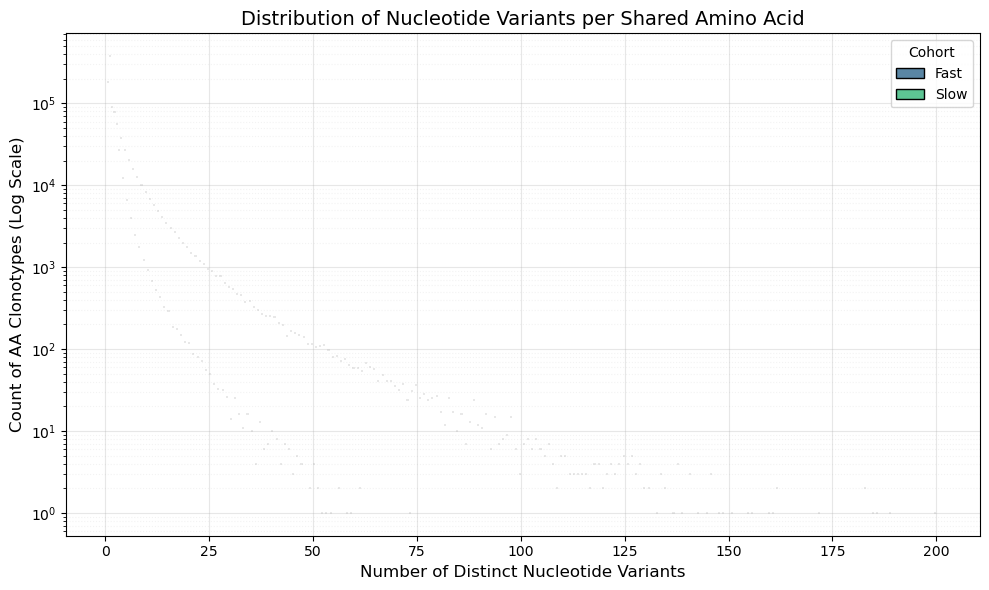

Max variants observed in Fast: 200
Max variants observed in Slow: 73


In [ ]:
# We convert the wide format (columns: fast, slow) to long format (column: Group)
# This makes it compatible with seaborn's 'hue' parameter.
df_hist = nt_counts_per_group.reset_index().melt(
    id_vars="aaSeqCDR3", 
    value_vars=["n_nt_fast", "n_nt_slow"], 
    var_name="Cohort", 
    value_name="n_variants"
)

# Clean up label names for the legend
df_hist["Cohort"] = df_hist["Cohort"].replace({
    "n_nt_fast": "Fast", 
    "n_nt_slow": "Slow"
})

plt.figure(figsize=(10, 6))

# Use discrete=True to center bars on integers (1, 2, 3...)
# Use log_scale=(False, True) to make the Y-axis logarithmic
sns.histplot(
    data=df_hist, 
    x="n_variants", 
    hue="Cohort", 
    multiple="dodge",   
    discrete=True,      
    palette="viridis",
    log_scale=(False, True),  # Log Y-axis to see the 'tail' of high-convergence clones
    alpha=0.8
)

plt.title("Distribution of Nucleotide Variants per Shared Amino Acid", fontsize=14)
plt.xlabel("Number of Distinct Nucleotide Variants", fontsize=12)
plt.ylabel("Count of AA Clonotypes (Log Scale)", fontsize=12)

# Add grid for readability on log scale
plt.grid(True, which="major", linestyle="-", alpha=0.3)
plt.grid(True, which="minor", linestyle=":", alpha=0.15)

plt.tight_layout()
plt.show()

print("Max variants observed in Fast:", df_hist[df_hist["Cohort"]=="Fast"]["n_variants"].max())
print("Max variants observed in Slow:", df_hist[df_hist["Cohort"]=="Slow"]["n_variants"].max())

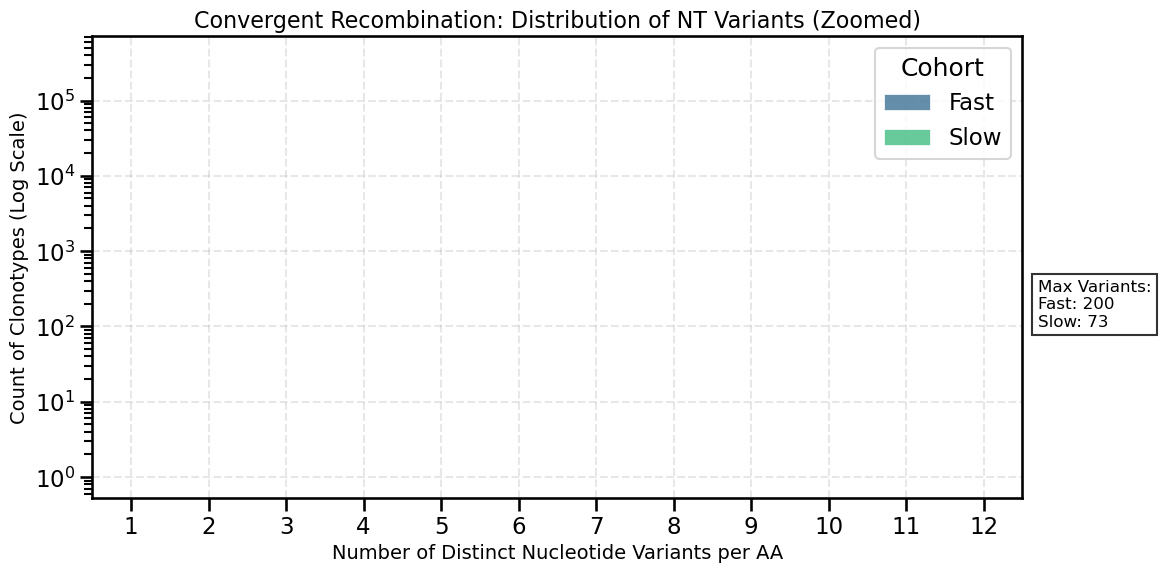

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set context to 'talk' to auto-scale fonts up for presentations/papers
sns.set_context("talk") 

plt.figure(figsize=(12, 6))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# We count how many AA sequences fall into each (Fast, Slow) pair coordinates
bubble_data = (
    nt_counts_per_group.groupby(["n_nt_fast", "n_nt_slow"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(10, 8))

# Scatter plot where 'size' controls bubble area
sns.scatterplot(
    data=bubble_data,
    x="n_nt_fast",
    y="n_nt_slow",
    size="count",
    sizes=(50, 2000),    # Min and Max bubble size 
    alpha=0.6,           # Transparency to see overlaps
    palette="viridis",
    hue="count",         # Color by count to make high-density spots pop
    edgecolor="k",
    linewidth=0.5
)

# Add diagonal y=x line (Equality)
max_val = max(bubble_data["n_nt_fast"].max(), bubble_data["n_nt_slow"].max())
plt.plot([0, max_val], [0, max_val], ls="--", c="gray", alpha=0.5, label="Equal Convergence")

# Scales and Labels
plt.title("Correlation of Convergent Recombination (Fast vs. Slow)", fontsize=16)
plt.xlabel("Number of Variants in Fast", fontsize=14)
plt.ylabel("Number of Variants in Slow", fontsize=14)

# Zoom in if outliers are squishing the view (Optional)
# plt.xlim(0.5, 15)
# plt.ylim(0.5, 15)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Clonotype Count")
plt.grid(True, linestyle=":", alpha=0.3)
plt.tight_layout()

plt.show()
# Main Plot
ax = sns.histplot(
    data=df_hist, 
    x="n_variants", 
    hue="Cohort", 
    multiple="dodge", 
    discrete=True,      
    palette="viridis",
    log_scale=(False, True),  # Log scale Y-axis is CRITICAL here
    shrink=0.8,               # Adds gap between bars
    edgecolor="white", linewidth=0.5
)

# FORCE THE ZOOM
# Most AA sequences have 1-10 variants. Let's zoom in on that.
plt.xlim(0.5, 12.5)  
plt.xticks(range(1, 13)) 

plt.title("Convergent Recombination: Distribution of NT Variants (Zoomed)", fontsize=16)
plt.xlabel("Number of Distinct Nucleotide Variants per AA", fontsize=14)
plt.ylabel("Count of Clonotypes (Log Scale)", fontsize=14)
plt.grid(True, which="major", linestyle="--", alpha=0.3)

# Add a text note about what we cut off
max_fast = df_hist[df_hist["Cohort"]=="Fast"]["n_variants"].max()
max_slow = df_hist[df_hist["Cohort"]=="Slow"]["n_variants"].max()
plt.text(12.7, 100, f"Max Variants:\nFast: {max_fast}\nSlow: {max_slow}", 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

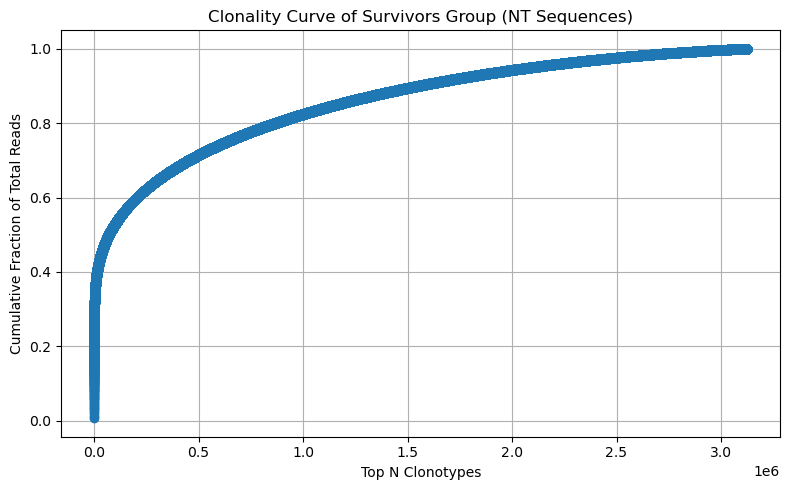

In [34]:
survivors_set = set(same_nt + diff_nt)
survivor_df_clonality = clonotype_df[clonotype_df["aaSeqCDR3"].isin(survivors_set)].copy()
clonotype_counts = (
    survivor_df_clonality.groupby("nSeqCDR3")["readCount"]
    .sum()
    .sort_values(ascending=False))

# Normalize counts
cumulative_counts = clonotype_counts.cumsum()
total_reads = clonotype_counts.sum()
fraction_reads = cumulative_counts / total_reads
x = np.arange(1, len(fraction_reads) + 1)

plt.figure(figsize=(8, 5))
plt.plot(x, fraction_reads, marker='o', linestyle='-')
plt.xlabel("Top N Clonotypes")
plt.ylabel("Cumulative Fraction of Total Reads")
plt.title("Clonality Curve of Survivors Group (NT Sequences)")
plt.grid(True)
plt.tight_layout()
plt.show()

Common TCRs - Common Structure?

In [35]:
# Get sets of common (shared) vs private (group-specific) TCRs
common_tcrs = set(diff_nt)  # appear in both groups, with different NTs
all_aas = set(clonotype_df["aaSeqCDR3"].dropna())
private_tcrs = all_aas - set(same_nt) - set(diff_nt)  # appear in only one group


## Logo Anlysis (Bio SeqIO)

In [67]:
import logomaker
from Bio import SeqIO

def pad_sequences(seq_list, pad_char='-', max_length=20):
    # Truncate: Force all sequences to be at most max_length
    trimmed = [s[:max_length] for s in seq_list]
    
    # Pad: Force all sequences to be at least max_length
    padded = [s.ljust(max_length, pad_char) for s in trimmed]

    # Sanity check to prevent Logomaker crashes
    lengths = [len(seq) for seq in padded]
    if len(set(lengths)) > 1:
        raise ValueError("Padding failed — sequences are still of different lengths.")
    
    return padded

# Get the set of CDR3s for each group
fast_cdr3s = set(clonotype_df[clonotype_df["group"] == "fast"]["aaSeqCDR3"])
slow_cdr3s = set(clonotype_df[clonotype_df["group"] == "slow"]["aaSeqCDR3"])

# Define the 3 sets
shared_cdr3s = fast_cdr3s.intersection(slow_cdr3s)
fast_only_cdr3s = fast_cdr3s - slow_cdr3s
slow_only_cdr3s = slow_cdr3s - fast_cdr3s

# Convert sets to lists
common_tcrs_list = list(shared_cdr3s)
private_tcrs_list = list(fast_only_cdr3s.union(slow_only_cdr3s))

# Apply padding 
target_len = 30
common_aligned = pad_sequences(common_tcrs_list, pad_char='-', max_length=target_len)
private_aligned = pad_sequences(private_tcrs_list, pad_char='-', max_length=target_len)

def get_logo_df(seq_list):
    return logomaker.alignment_to_matrix(seq_list, to_type='counts')

common_df = get_logo_df(common_aligned)
private_df = get_logo_df(private_aligned)


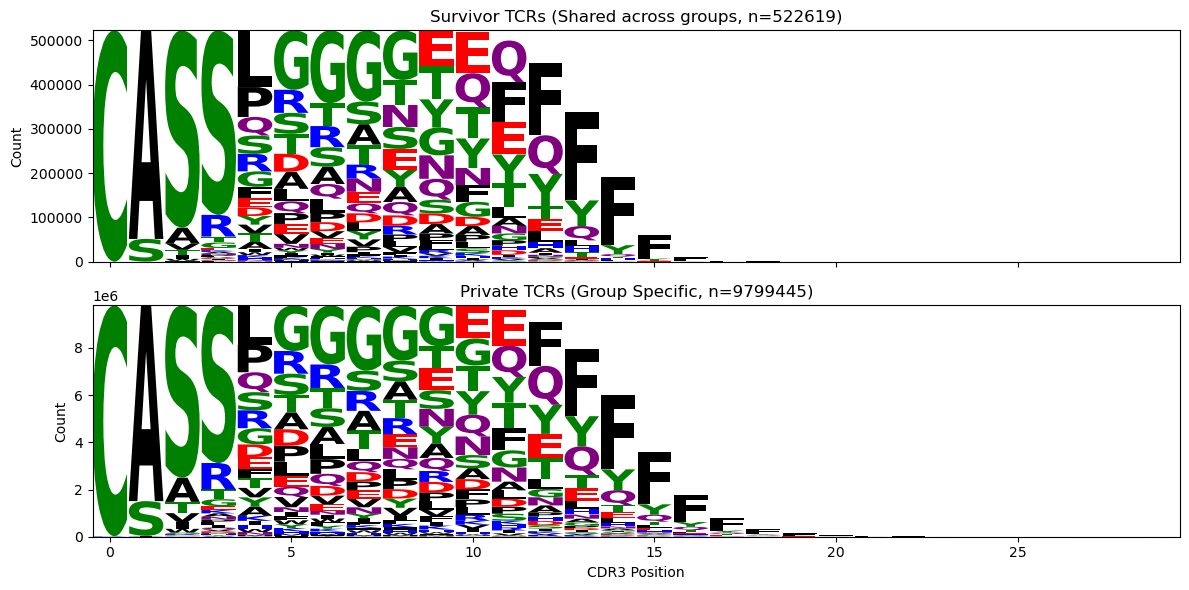

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot Common
logomaker.Logo(common_df, color_scheme='chemistry', ax=ax1)
ax1.set_title(f"Survivor TCRs (Shared across groups, n={len(common_tcrs_list)})")
ax1.set_ylabel("Count")

# Plot Private
logomaker.Logo(private_df, color_scheme='chemistry', ax=ax2)
ax2.set_title(f"Private TCRs (Group Specific, n={len(private_tcrs_list)})")
ax2.set_xlabel("CDR3 Position")
ax2.set_ylabel("Count")

plt.tight_layout()

save_plot("../colon/logos_survivor_private.svg", format="svg")

plt.show()

How simmilar are the two logos? we will use corrolation between values to visuliaze the simmilariy/difference.

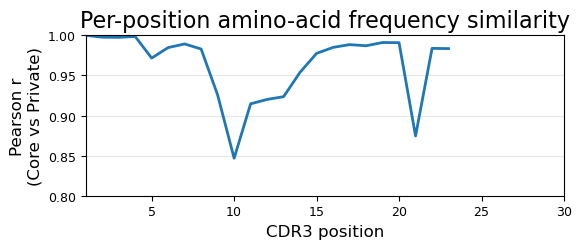

In [84]:
common_freq  = common_df.div(common_df.sum(axis=1), axis=0)
private_freq = private_df.div(private_df.sum(axis=1), axis=0)

corrs = common_freq.corrwith(private_freq, axis=1)

x = np.arange(1, len(corrs) + 1)  # 1-based positions for readability

fig, ax = plt.subplots(figsize=(6, 2.6))

ax.plot(x, corrs.values, linewidth=2)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_xlabel("CDR3 position", fontsize=12)
ax.set_ylabel("Pearson r\n(Core vs Private)", fontsize=12)
ax.set_title("Per-position amino-acid frequency similarity", fontsize=16)
ax.set_xlim(1, len(corrs))
ax.set_ylim(0.8, 1)  # correlation bounds
ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)
ax.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
save_plot("../colon/corr_logos_survivor_private.svg", format="svg")

plt.show()


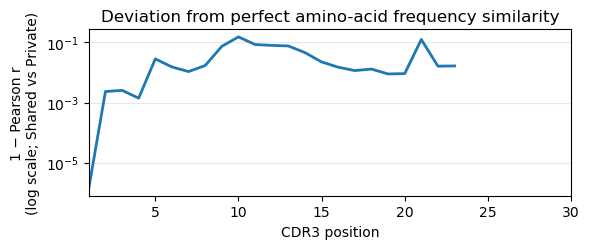

In [70]:
common_freq  = common_df.div(common_df.sum(axis=1), axis=0)
private_freq = private_df.div(private_df.sum(axis=1), axis=0)

corrs = common_freq.corrwith(private_freq, axis=1)
x = np.arange(1, len(corrs) + 1)  # 1-based positions for readability

eps = 1e-6  # to avoid log(0)
delta = 1 - corrs.values
delta = np.clip(delta, eps, None)
fig, ax = plt.subplots(figsize=(6, 2.6))

ax.plot(x, delta, linewidth=2)
ax.set_yscale("log")

ax.set_xlabel("CDR3 position")
ax.set_ylabel("1 − Pearson r\n(log scale; Shared vs Private)")
ax.set_title("Deviation from perfect amino-acid frequency similarity")

ax.set_xlim(1, len(corrs))
ax.grid(True, axis="y", which="both", alpha=0.3)
fig.tight_layout()
save_plot("../colon/corr_logos_log_survivor_private.svg", format="svg")

plt.show()


In [71]:
# Create group-wise sets
fast_seqs = set(clonotype_df[clonotype_df["group"] == "fast"]["aaSeqCDR3"].dropna())
slow_seqs = set(clonotype_df[clonotype_df["group"] == "slow"]["aaSeqCDR3"].dropna())

# Define Private sequences
fast_only = list(fast_seqs - slow_seqs)
slow_only = list(slow_seqs - fast_seqs)

# Align
target_len = 30  
fast_aligned = pad_sequences(fast_only, pad_char='-', max_length=target_len)
slow_aligned = pad_sequences(slow_only, pad_char='-', max_length=target_len)

# Logo df
fast_df = get_logo_df(fast_aligned)
slow_df = get_logo_df(slow_aligned)

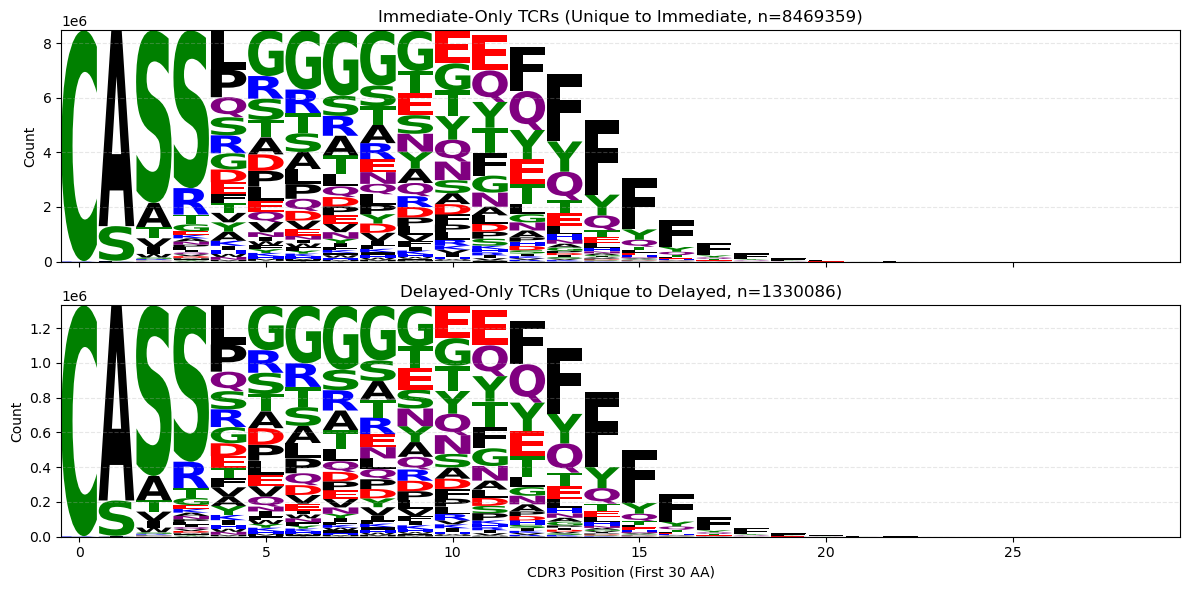

In [72]:
# Plotting 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot Fast-Only
logomaker.Logo(fast_df, color_scheme='chemistry', ax=ax1)
ax1.set_title(f"Immediate-Only TCRs (Unique to Immediate, n={len(fast_only)})")
ax1.set_ylabel("Count")

# Plot Slow-Only
logomaker.Logo(slow_df, color_scheme='chemistry', ax=ax2)
ax2.set_title(f"Delayed-Only TCRs (Unique to Delayed, n={len(slow_only)})")
ax2.set_xlabel(f"CDR3 Position (First {target_len} AA)")
ax2.set_ylabel("Count")

# Clean styling
for ax in [ax1, ax2]:
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
save_plot("../colon/logos_immediate_delayed.svg", format="svg")

plt.show()

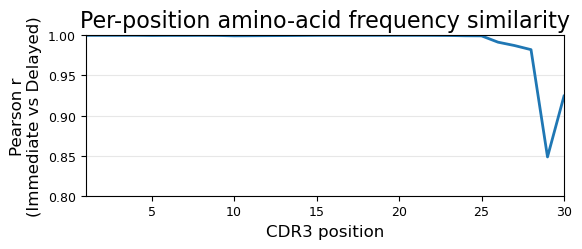

In [78]:
fast_freq  = fast_df.div(fast_df.sum(axis=1), axis=0)
slow_freq = slow_df.div(slow_df.sum(axis=1), axis=0)

corrs_fast_slow = fast_freq.corrwith(slow_freq, axis=1)

x = np.arange(1, len(corrs_fast_slow) + 1)  # 1-based positions for readability

fig, ax = plt.subplots(figsize=(6, 2.6))

ax.plot(x, corrs_fast_slow.values, linewidth=2)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_xlabel("CDR3 position", fontsize=12)
ax.set_ylabel("Pearson r\n(Immediate vs Delayed)", fontsize=12)
ax.set_title("Per-position amino-acid frequency similarity", fontsize=16)
ax.set_xlim(1, len(corrs_fast_slow))
ax.set_ylim(0.8, 1)  # correlation bounds
ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)
ax.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
save_plot("../colon/corr_logos_immediate_delayed.svg", format="svg")

plt.show()


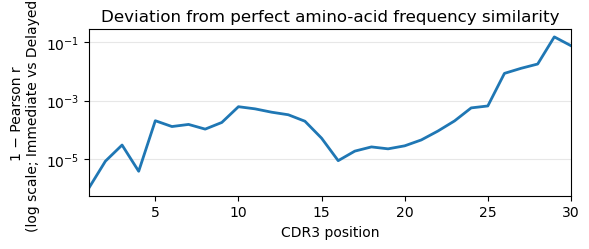

In [74]:
fast_freq  = fast_df.div(fast_df.sum(axis=1), axis=0)
slow_freq = slow_df.div(slow_df.sum(axis=1), axis=0)

corrs_fast_slow = fast_freq.corrwith(slow_freq, axis=1)

x = np.arange(1, len(corrs_fast_slow) + 1)  # 1-based positions for readability

eps = 1e-6  # to avoid log(0)
delta = 1 - corrs_fast_slow.values
delta = np.clip(delta, eps, None)
fig, ax = plt.subplots(figsize=(6, 2.6))

ax.plot(x, delta, linewidth=2)
ax.set_yscale("log")

ax.set_xlabel("CDR3 position")
ax.set_ylabel("1 − Pearson r\n(log scale; Immediate vs Delayed)")
ax.set_title("Deviation from perfect amino-acid frequency similarity")

ax.set_xlim(1, len(corrs))
ax.grid(True, axis="y", which="both", alpha=0.3)
fig.tight_layout()
save_plot("../colon/corr_logos_log_immediate_delayed.svg", format="svg")

plt.show()


## Focusing on Different NT Sub-group

In [12]:
from collections import Counter, defaultdict
import itertools

# Filter for shared AAs with different NTs and group by AA
nt_groups = (
    clonotype_df[clonotype_df["aaSeqCDR3"].isin(diff_nt)]
    [["aaSeqCDR3", "nSeqCDR3"]]
    .dropna()
    .drop_duplicates()
    .groupby("aaSeqCDR3")["nSeqCDR3"]
    .apply(list))

mutation_counts = defaultdict(int)     
aa_pos_mutations = defaultdict(int)     
aa_pos_depth = defaultdict(int)        
total_codons_compared = 0

for aa_seq, nt_list in nt_groups.items():
    valid_nts = [nt for nt in nt_list if len(nt) == len(aa_seq) * 3]
    if len(valid_nts) < 2: continue

    for nt1, nt2 in itertools.combinations(valid_nts, 2):
        
        # Track "Depth": This AA position existed in this comparison
        for aa_idx in range(len(aa_seq)):
            aa_pos_depth[aa_idx] += 1
            
        total_codons_compared += len(aa_seq)

        # Count mismatches by position
        for k in range(len(nt1)):
            if nt1[k] != nt2[k]:
                base_pos = (k % 3) + 1  # 1, 2, or 3
                aa_idx = k // 3         # 0, 1, 2...
                mutation_counts[base_pos] += 1
                aa_pos_mutations[aa_idx] += 1

# Compute Frequencies (Normalization)
# Normalize by the actual number of times we looked at that position
base_freqs = {k: v / total_codons_compared for k, v in mutation_counts.items()}
aa_freqs = {k + 1: aa_pos_mutations[k] / aa_pos_depth[k] for k in aa_pos_mutations}



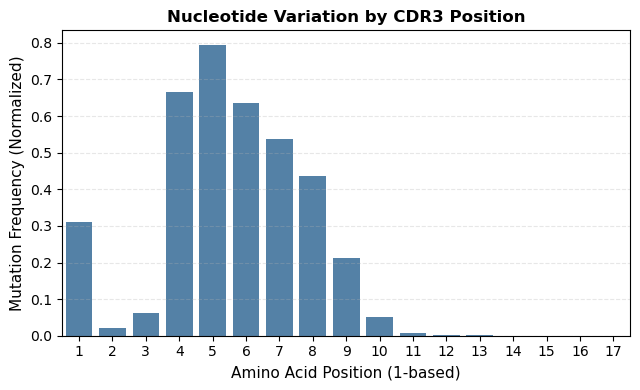

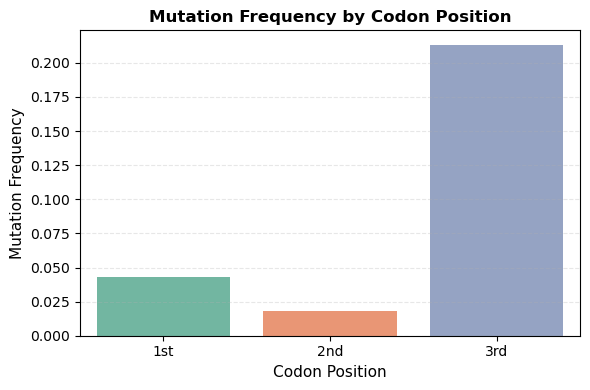

In [43]:
plt.figure(figsize=(6.5, 4))

sns.barplot(
    x=list(aa_freqs.keys()),
    y=list(aa_freqs.values()),
    color="steelblue"
)

plt.title("Nucleotide Variation by CDR3 Position", fontsize=12, fontweight="bold")
plt.xlabel("Amino Acid Position (1-based)", fontsize=11)
plt.ylabel("Mutation Frequency (Normalized)", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))

labels = ["1st", "2nd", "3rd"]
freqs = [base_freqs.get(i, 0) for i in [1, 2, 3]]

sns.barplot(
    x=labels,
    y=freqs,
    hue=labels,        
    palette="Set2",
    legend=False)

plt.title("Mutation Frequency by Codon Position", fontsize=12, fontweight="bold")
plt.xlabel("Codon Position", fontsize=11)
plt.ylabel("Mutation Frequency", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

save_plot("../colon/bases_mutation_frequency.svg", format="svg")

plt.show()


This analysis examines nucleotide-level differences among synonymous (“survivor”) TCR clonotypes shared between the Immediate and Delayed cohorts.<br> Shared clonotypes are defined as amino-acid–identical CDR3 sequences observed in both cohorts but represented by multiple nucleotide variants.<br>
The objective is to characterize cohort-associated nucleotide and codon usage differences under amino-acid conservation, not to infer evolutionary ancestry or mutational trajectories.

For each shared amino-acid clonotype, nucleotide sequences are separated by cohort and compared only across cohorts (Immediate vs Delayed). Within-cohort comparisons are excluded.

Substitution direction is therefore defined as:

- From: nucleotide observed in the Immediate cohort

- To: nucleotide observed in the Delayed cohort

This anchoring allows asymmetric substitutions (e.g., A→G vs G→A) to be interpreted as differences in nucleotide usage between cohorts.

Nucleotide differences are quantified at multiple levels:

Codon base position (1st, 2nd, 3rd)

Amino-acid (codon) position along the CDR3

Substitution composition (base → base), globally and per codon position

**Normalization**

Substitution counts are normalized to account for differences in nucleotide composition and comparison depth. For each substitution type, the normalized frequency is defined as:

$\displaystyle \text{Normalized}(b_{\text{Immediate}} \rightarrow b_{\text{Delayed}}) = \frac{\#(b_{\text{Immediate}} \rightarrow b_{\text{Delayed}})}{\#(b_{\text{Immediate}}\ \text{observed in Immediate})}$

Thus, normalized values represent the fraction of nucleotide positions at which a given base observed in the Immediate cohort differs in the Delayed cohort. Values do not sum to one, as positions with identical nucleotides between cohorts (e.g., A→A) are excluded from the substitution counts.

In [7]:
from collections import Counter

# Cohort-anchored nucleotide differences in shared AA clonotypes
# Fast -> Slow direction is defined by cohort 

BASES = ["A", "C", "G", "T"]
FAST_LABEL = "fast"
SLOW_LABEL = "slow"

# Keep group so comparisons are Fast vs Slow within each AA clonotype
df = clonotype_df.loc[
    clonotype_df["aaSeqCDR3"].isin(diff_nt),
    ["aaSeqCDR3", "nSeqCDR3", "group"]
].dropna().drop_duplicates()

# enforce valid bases only
df = df[df["nSeqCDR3"].str.fullmatch(r"[ACGT]+")]

# Group by AA clonotype, keep cohort-specific NT variants
groups = df.groupby("aaSeqCDR3")

aa_pos_counter = Counter()            # 1-based codon/AA position
codon_base_counter = Counter()        # 1,2,3 base in codon
nt_substitution_counter = Counter()   # (base_fast, base_slow)
base_occurrence_counter = Counter()   # background counts of bases in FAST ("from" side)

n_groups_used = 0

for aa_seq, g in groups:
    codon_len = len(aa_seq)
    nt_len_expected = codon_len * 3

    # Split NT variants by cohort, keep in-frame length only
    fast_nts = g.loc[g["group"] == FAST_LABEL, "nSeqCDR3"].tolist()
    slow_nts = g.loc[g["group"] == SLOW_LABEL, "nSeqCDR3"].tolist()

    fast_nts = [nt for nt in fast_nts if len(nt) == nt_len_expected]
    slow_nts = [nt for nt in slow_nts if len(nt) == nt_len_expected]

    # Need at least one NT realization in each cohort to anchor Fast -> Slow
    if len(fast_nts) == 0 or len(slow_nts) == 0:
        continue

    n_groups_used += 1

    # Convert to character matrices
    mat_fast = np.array([list(s) for s in fast_nts], dtype="U1")  # (m, L)
    mat_slow = np.array([list(s) for s in slow_nts], dtype="U1")  # (n, L)

    m, L = mat_fast.shape
    n = mat_slow.shape[0]

    # Create all Fast-vs-Slow pair rows (m*n, L) without nested Python loops
    # Pair indexing: (fast_i, slow_j) for all i,j
    fast_idx = np.repeat(np.arange(m), n)
    slow_idx = np.tile(np.arange(n), m)

    seqs_fast = mat_fast[fast_idx]    # (m*n, L)
    seqs_slow = mat_slow[slow_idx]    # (m*n, L)

    # Background base counts on the "from" side:
    # Count bases in Fast sequences, expanded by number of Slow partners
    u, c = np.unique(seqs_fast, return_counts=True)
    base_occurrence_counter.update(dict(zip(u, c)))

    # Find mismatches
    diff_mask = (seqs_fast != seqs_slow)
    if not np.any(diff_mask):
        continue

    # Indices of mismatch positions (row idx not needed, only column positions)
    _, col_indices = np.where(diff_mask)

    # Update AA/codon index and codon base position counters
    aa_indices = (col_indices // 3) + 1          # 1-based codon/AA position
    base_positions = (col_indices % 3) + 1       # 1,2,3 within codon

    aa_pos_counter.update(aa_indices.tolist())
    codon_base_counter.update(base_positions.tolist())

    # Update oriented substitutions: Fast base -> Slow base, only at mismatches
    b_fast = seqs_fast[diff_mask]
    b_slow = seqs_slow[diff_mask]
    nt_substitution_counter.update(zip(b_fast.tolist(), b_slow.tolist()))

print(f"Used {n_groups_used} AA clonotypes with Fast+Slow NT realizations (anchored comparisons).")


Used 513661 AA clonotypes with Fast+Slow NT realizations (anchored comparisons).


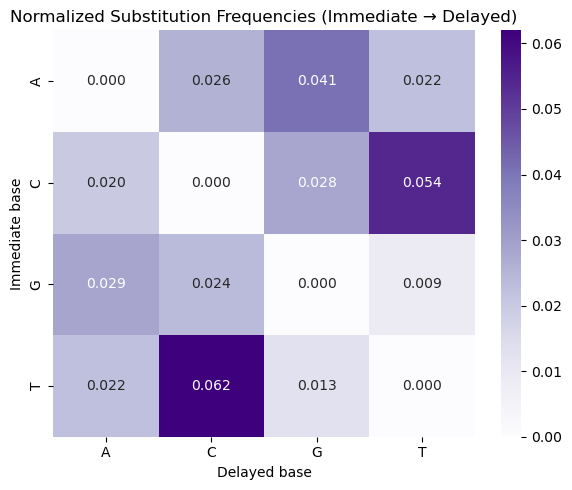

In [15]:

# Build normalized heatmap
heatmap_norm = pd.DataFrame(0.0, index=BASES, columns=BASES)

for (b1, b2), count in nt_substitution_counter.items():
    if b1 not in BASES or b2 not in BASES:
        continue
    denom = base_occurrence_counter.get(b1, 0)
    if denom > 0:
        heatmap_norm.loc[b1, b2] = count / denom


plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_norm, annot=True, fmt=".3f", cmap="Purples")
plt.title("Normalized Substitution Frequencies (Immediate → Delayed)")
plt.xlabel("Delayed base")
plt.ylabel("Immediate base")
plt.tight_layout()

save_plot("../colon/normelized_substitution_freq_all.svg", format="svg")

plt.show()


In [ ]:
# derived summaries for plotting elsewhere
# Codon base position frequencies normalized by total mismatches (simple, descriptive)
total_mismatches = sum(codon_base_counter.values())
codon_base_freqs = {pos: codon_base_counter[pos] / total_mismatches for pos in [1, 2, 3]} if total_mismatches else {1: 0, 2: 0, 3: 0}

# AA-position frequencies normalized by total mismatches
aa_pos_freqs = {pos: aa_pos_counter[pos] / total_mismatches for pos in sorted(aa_pos_counter)} if total_mismatches else {}


In [ ]:
BASES = ["A", "C", "G", "T"]
FAST_LABEL = "fast"
SLOW_LABEL = "slow"

#  Counters, stratified by codon base position (1,2,3) 
substitution_by_position = {1: Counter(), 2: Counter(), 3: Counter()}     # (fast_base, slow_base) counts
base_occurrence_by_position = {1: Counter(), 2: Counter(), 3: Counter()}  # background "from" bases in Fast, per position

#  Prepare data: must include group to anchor direction 
df = clonotype_df.loc[
    clonotype_df["aaSeqCDR3"].isin(diff_nt),
    ["aaSeqCDR3", "nSeqCDR3", "group"]
].dropna().drop_duplicates()

# keep only canonical DNA bases
df = df[df["nSeqCDR3"].str.fullmatch(r"[ACGT]+")]

for aa_seq, g in df.groupby("aaSeqCDR3"):
    codon_len = len(aa_seq)
    nt_len = codon_len * 3

    fast_nts = g.loc[g["group"] == FAST_LABEL, "nSeqCDR3"].tolist()
    slow_nts = g.loc[g["group"] == SLOW_LABEL, "nSeqCDR3"].tolist()

    fast_nts = [nt for nt in fast_nts if len(nt) == nt_len]
    slow_nts = [nt for nt in slow_nts if len(nt) == nt_len]

    if not fast_nts or not slow_nts:
        continue

    mat_fast = np.array([list(s) for s in fast_nts], dtype="U1")  # (m, L)
    mat_slow = np.array([list(s) for s in slow_nts], dtype="U1")  # (n, L)

    m, L = mat_fast.shape
    n = mat_slow.shape[0]

    # all Fast-vs-Slow pairs
    fast_idx = np.repeat(np.arange(m), n)
    slow_idx = np.tile(np.arange(n), m)

    seqs_fast = mat_fast[fast_idx]  # (m*n, L)
    seqs_slow = mat_slow[slow_idx]  # (m*n, L)

    # background base exposure per codon base position (FAST side only) 
    # positions 0,1,2 correspond to codon base 1,2,3, repeated every 3 bases
    col_mod = np.arange(L) % 3  # 0/1/2 for each column
    for pos in (1, 2, 3):
        cols = np.where(col_mod == (pos - 1))[0]
        u, c = np.unique(seqs_fast[:, cols], return_counts=True)
        base_occurrence_by_position[pos].update(dict(zip(u, c)))

    # mismatches and substitutions, stratified by codon base position
    diff_mask = (seqs_fast != seqs_slow)
    if not np.any(diff_mask):
        continue

    mismatch_cols = np.where(diff_mask)[1]
    mismatch_fast = seqs_fast[diff_mask]
    mismatch_slow = seqs_slow[diff_mask]

    mismatch_pos = (mismatch_cols % 3) + 1  # 1/2/3

    # update counters per position
    for pos in (1, 2, 3):
        sel = (mismatch_pos == pos)
        if not np.any(sel):
            continue
        substitution_by_position[pos].update(zip(mismatch_fast[sel].tolist(), mismatch_slow[sel].tolist()))



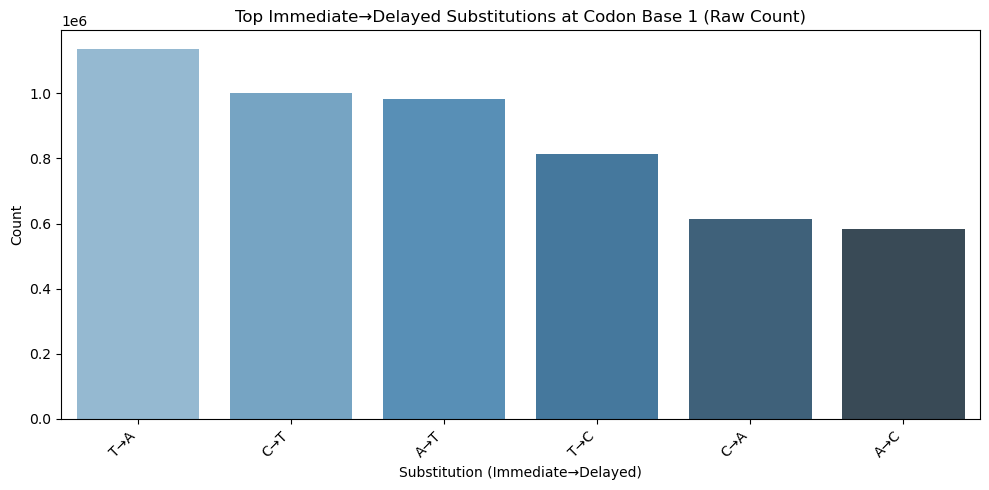

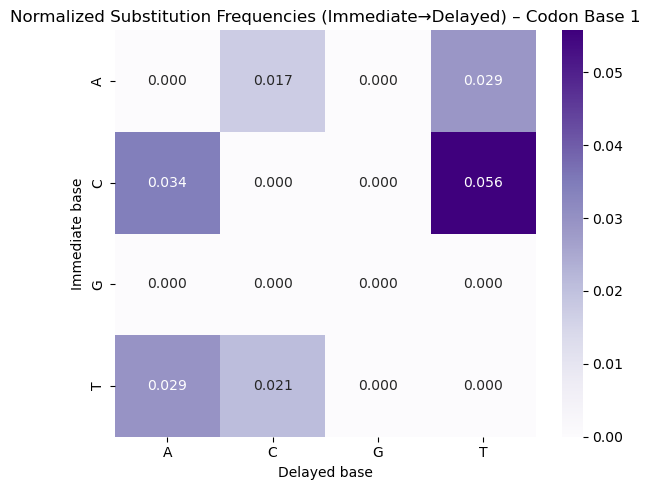

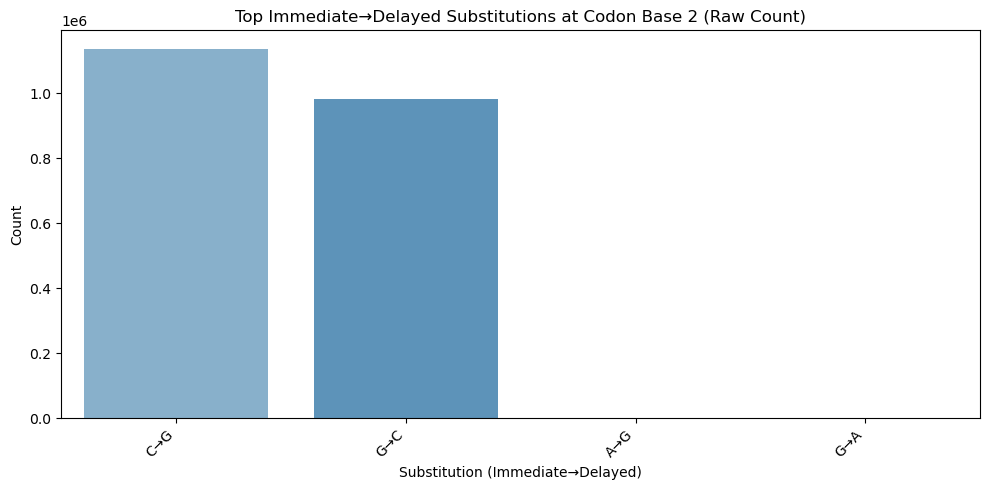

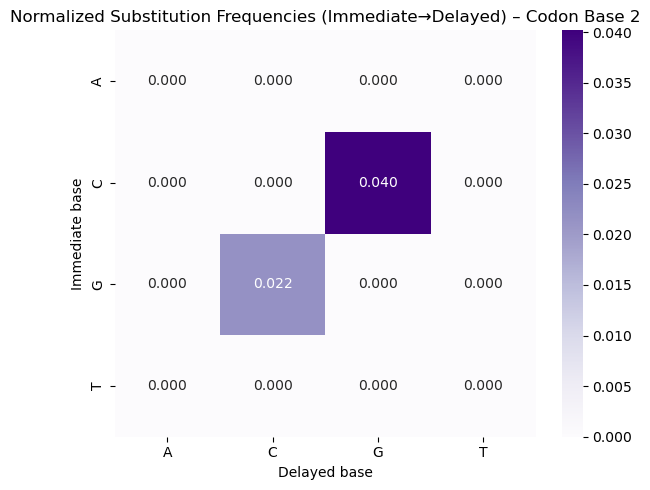

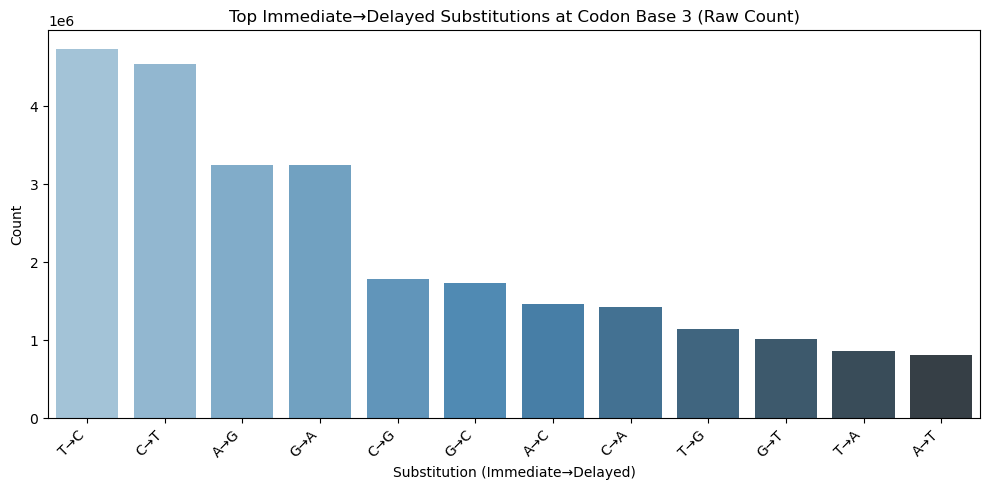

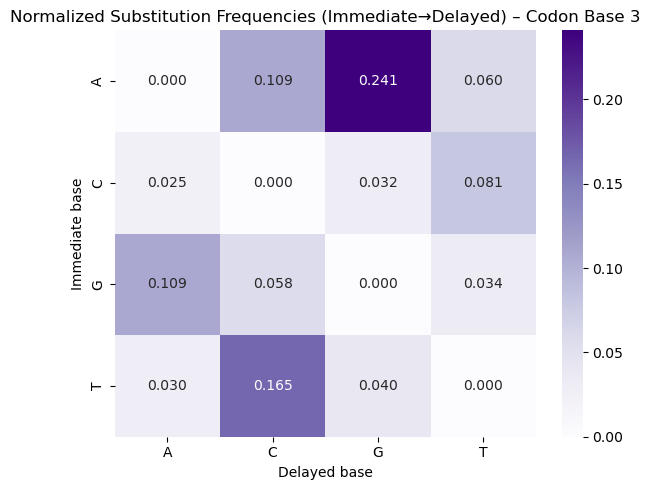

In [16]:
# Plot per codon base position
for pos in (1, 2, 3):
    sub_counter = substitution_by_position[pos]
    base_counter = base_occurrence_by_position[pos]

    # Build a table with raw + normalized Fast->Slow substitution frequencies
    rows = []
    for (b_fast, b_slow), count in sub_counter.items():
        if (b_fast not in BASES) or (b_slow not in BASES):
            continue
        denom = base_counter.get(b_fast, 0)
        if denom == 0:
            continue
        rows.append((b_fast, b_slow, count, count / denom))

    sub_df = pd.DataFrame(rows, columns=["from", "to", "count", "normalized"])
    if sub_df.empty:
        print(f"[Codon base {pos}] No substitutions to plot.")
        continue

    sub_df["substitution"] = sub_df["from"] + "→" + sub_df["to"]

    # --- Barplot: top substitutions by raw count (Fast->Slow, codon base pos) ---
    top_df = sub_df.sort_values("count", ascending=False).head(15)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_df, x="substitution", y="count", hue="substitution",
                palette="Blues_d",legend=False)

    plt.title(f"Top Immediate→Delayed Substitutions at Codon Base {pos} (Raw Count)")
    plt.xlabel("Substitution (Immediate→Delayed)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Heatmap: normalized Fast->Slow substitution frequencies 
    heatmap_df = pd.DataFrame(0.0, index=BASES, columns=BASES)
    for _, r in sub_df.iterrows():
        heatmap_df.loc[r["from"], r["to"]] = r["normalized"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="Purples")
    plt.title(f"Normalized Substitution Frequencies (Immediate→Delayed) – Codon Base {pos}")
    plt.xlabel("Delayed base")
    plt.ylabel("Immediate base")
    plt.tight_layout()
    
    save_plot(f"../colon/normelized_substitution_freq_{pos}.svg", format="svg")

    plt.show()


## V Gene Usage

avg_nt_diversity = sum of all unique TCR appearances divided by the number of unique TCRs for that v-gene.

In [85]:
# Filter to relevant rows and columns in one pass
df_v = (
    clonotype_df.loc[clonotype_df["aaSeqCDR3"].isin(diff_nt), 
                     ["aaSeqCDR3", "nSeqCDR3", "allVHitsWithScore"]]
    .dropna()
    .drop_duplicates()  # Removes exact duplicates
    .copy())

# Extract Gene Name
df_v["V_gene"] = (
    df_v["allVHitsWithScore"]
    .str.split(",").str[0]
    .str.split("*").str[0])

# Calculate Statistics
# First, count NT variants per (Gene, AA) pair
# Second, aggregate by Gene to get Summary Stats
v_summary = (
    df_v.groupby(["V_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="nt_variants")       #  NT count per clonotype
    .groupby("V_gene")
    .agg(
        n_public_TCRs=("aaSeqCDR3", "nunique"),  # X-axis: How many shared AA sequences?
        avg_nt_diversity=("nt_variants", "mean") # Y-axis: How many NTs per AA on average?
    )
    .reset_index()
    .sort_values("n_public_TCRs", ascending=False))


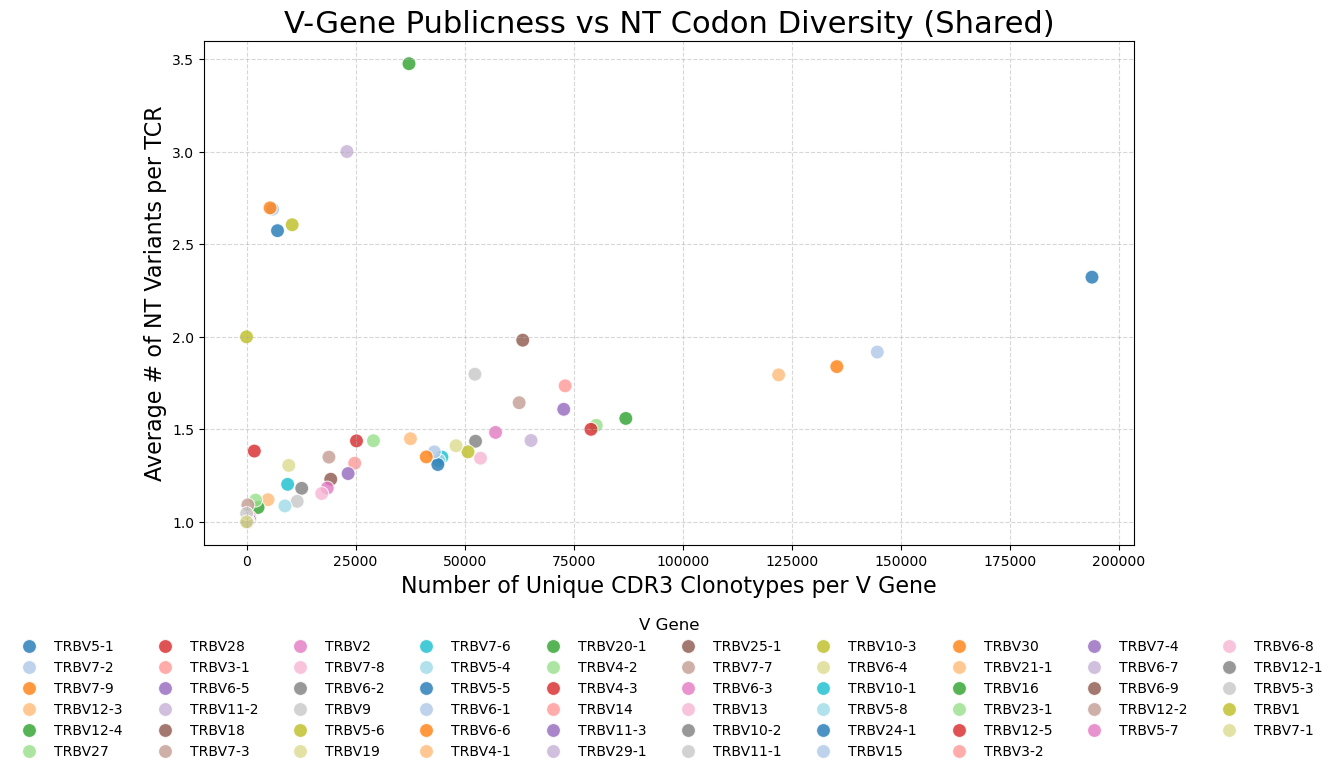

In [86]:
#  Global font size for ticks & legend 
plt.rcParams.update({
    "font.size": 10})

plt.figure(figsize=(12, 8))

sns.scatterplot(data=v_summary,x="n_public_TCRs",y="avg_nt_diversity",hue="V_gene",
                palette="tab20",s=100,alpha=0.8)

plt.title("V-Gene Publicness vs NT Codon Diversity (Shared)", fontsize=22)
plt.xlabel("Number of Unique CDR3 Clonotypes per V Gene", fontsize=16)
plt.ylabel("Average # of NT Variants per TCR", fontsize=16)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)

# Legend 
n_genes = len(v_summary)
n_cols = min(10, max(4, n_genes // 3))

plt.legend(title="V Gene", loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=n_cols,
            fontsize=10, title_fontsize=12, frameon=False)

plt.subplots_adjust(bottom=0.25)

save_plot("../colon/V_gene_usage_shared.svg", format="svg", bbox_inches="tight")

plt.show()

In [87]:
# Identify Shared AA Sequences-
fast_aas = set(clonotype_df.loc[clonotype_df["group"] == "fast", "aaSeqCDR3"].dropna())
slow_aas = set(clonotype_df.loc[clonotype_df["group"] == "slow", "aaSeqCDR3"].dropna())

# Intersection = The Shared Pool to Exclude
shared_aas = fast_aas.intersection(slow_aas)

print(f"Excluding {len(shared_aas)} shared AA sequences.")

# Filter for UNIQUE TCRs
# Keep rows where AA is NOT in the shared list
unique_tcr_df = (
    clonotype_df[~clonotype_df["aaSeqCDR3"].isin(shared_aas)]
    [["aaSeqCDR3", "nSeqCDR3", "allVHitsWithScore"]]
    .dropna()
    .drop_duplicates()
    .copy())

# Clean V-Genes
unique_tcr_df["V_gene"] = (
    unique_tcr_df["allVHitsWithScore"]
    .str.split(",").str[0]  
    .str.split("*").str[0]  )

# Aggregate Statistics
# Count distinct NTs per (Gene, AA)
diversity_unique = (
    unique_tcr_df.groupby(["V_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="nt_variants"))

# Summarize by V-Gene
v_summary_unique = (
    diversity_unique.groupby("V_gene")
    .agg(
        n_unique_TCRs=("aaSeqCDR3", "nunique"),  # X-axis
        avg_nt_diversity=("nt_variants", "mean") # Y-axis
    )
    .reset_index()
    .sort_values("n_unique_TCRs", ascending=False))


Excluding 522619 shared AA sequences.


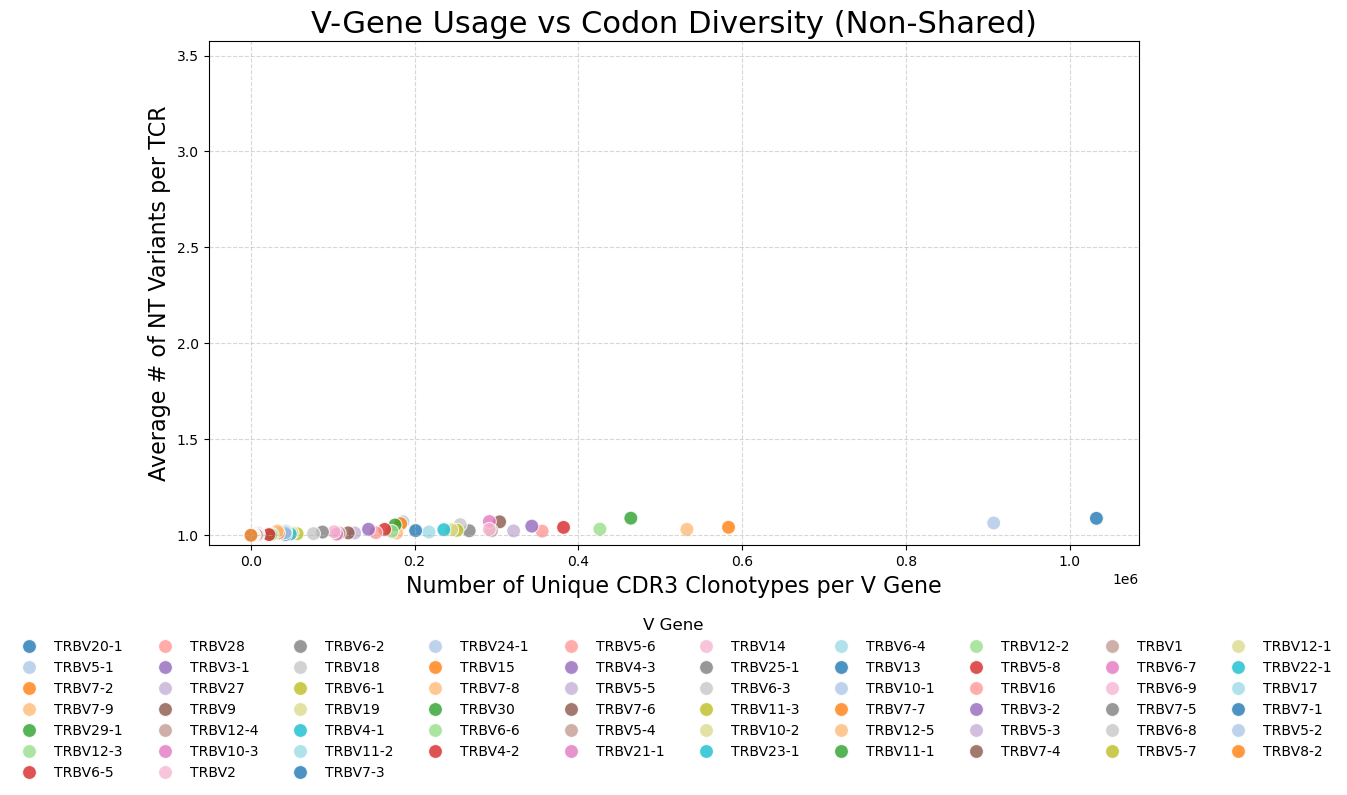

In [88]:
# Global font size for ticks & legend 
plt.rcParams.update({
    "font.size": 10})

plt.figure(figsize=(12, 8))

sns.scatterplot(data=v_summary_unique,x="n_unique_TCRs",y="avg_nt_diversity",
                hue="V_gene",palette="tab20",s=100,alpha=0.8)

# Match Y-axis scale to shared plot
if 'v_summary' in locals():
    max_y = v_summary["avg_nt_diversity"].max()
    plt.ylim(0.95, max_y + 0.1)

plt.title("V-Gene Usage vs Codon Diversity (Non-Shared)",fontsize=22)
plt.xlabel("Number of Unique CDR3 Clonotypes per V Gene",fontsize=16)
plt.ylabel("Average # of NT Variants per TCR",fontsize=16)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)

#  Legend
n_genes = len(v_summary_unique)
n_cols = min(10, max(4, n_genes // 3))

plt.legend(title="V Gene",loc="upper center",bbox_to_anchor=(0.5, -0.12),
           ncol=n_cols,fontsize=10,title_fontsize=12,frameon=False)

plt.subplots_adjust(bottom=0.25)

save_plot("../colon/V_gene_usage_unique.svg", format="svg", bbox_inches="tight")

plt.show()


Combine Plots and match Gene legend

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gene_scatter_stacked(
    df_top, df_bottom,
    gene_col: str,
    x_top: str, x_bottom: str,
    y: str = "avg_nt_diversity",
    title_top: str = "",
    title_bottom: str = "",
    xlabel: str = "Number of Unique CDR3 Clonotypes per Gene",
    ylabel: str = "Average # of NT Variants per TCR",
    out_svg: str | None = None,
    figsize=(12, 14),
    base_font=10,
    tick_font=10,
    title_font=22,
    label_font=16,
    legend_title: str = "Gene",
    legend_cols: int | None = None,
    legend_y: float = -0.05,
    bottom_margin: float = 0.25,
    match_y: bool = True,
    y_min: float = 0.95,
    y_pad: float = 0.10,
    palette_name: str = "tab20",
):
    plt.rcParams.update({"font.size": base_font})

    # stable gene->color mapping across both plots
    genes = sorted(set(df_top[gene_col]).union(set(df_bottom[gene_col])))
    palette = dict(zip(genes, sns.color_palette(palette_name, n_colors=len(genes))))

    fig, axes = plt.subplots(2, 1, figsize=figsize, constrained_layout=False)

    # top
    sns.scatterplot(
        data=df_top, x=x_top, y=y, hue=gene_col,
        palette=palette, s=100, alpha=0.8, ax=axes[0], legend=False
    )
    axes[0].set_title(title_top, fontsize=title_font)
    axes[0].set_xlabel("")
    axes[0].set_ylabel(ylabel, fontsize=label_font)
    axes[0].tick_params(axis="both", labelsize=tick_font)
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # bottom 
    sns.scatterplot(
        data=df_bottom, x=x_bottom, y=y, hue=gene_col,
        palette=palette, s=100, alpha=0.8, ax=axes[1], legend=False
    )
    axes[1].set_title(title_bottom, fontsize=title_font)
    axes[1].set_xlabel(xlabel, fontsize=label_font)
    axes[1].set_ylabel(ylabel, fontsize=label_font)
    axes[1].tick_params(axis="both", labelsize=tick_font)
    axes[1].grid(True, linestyle="--", alpha=0.5)

    # match y-lims across panels (optional)
    if match_y:
        max_y = max(df_top[y].max(), df_bottom[y].max())
        axes[0].set_ylim(y_min, max_y + y_pad)
        axes[1].set_ylim(y_min, max_y + y_pad)

    # one legend under the bottom plot
    handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", markersize=8,
                   markerfacecolor=palette[g], markeredgecolor=palette[g], label=g)
        for g in genes
    ]
    if legend_cols is None:
        legend_cols = min(10, max(4, len(genes) // 3))

    fig.legend(
        handles=handles, labels=genes, title=legend_title,
        loc="lower center", bbox_to_anchor=(0.5, legend_y),
        ncol=legend_cols, frameon=False,
        fontsize=11, title_fontsize=13,
    )

    fig.subplots_adjust(hspace=0.17, bottom=bottom_margin)

    if out_svg is not None:
        save_plot(out_svg, format="svg", bbox_inches="tight")

    plt.show()


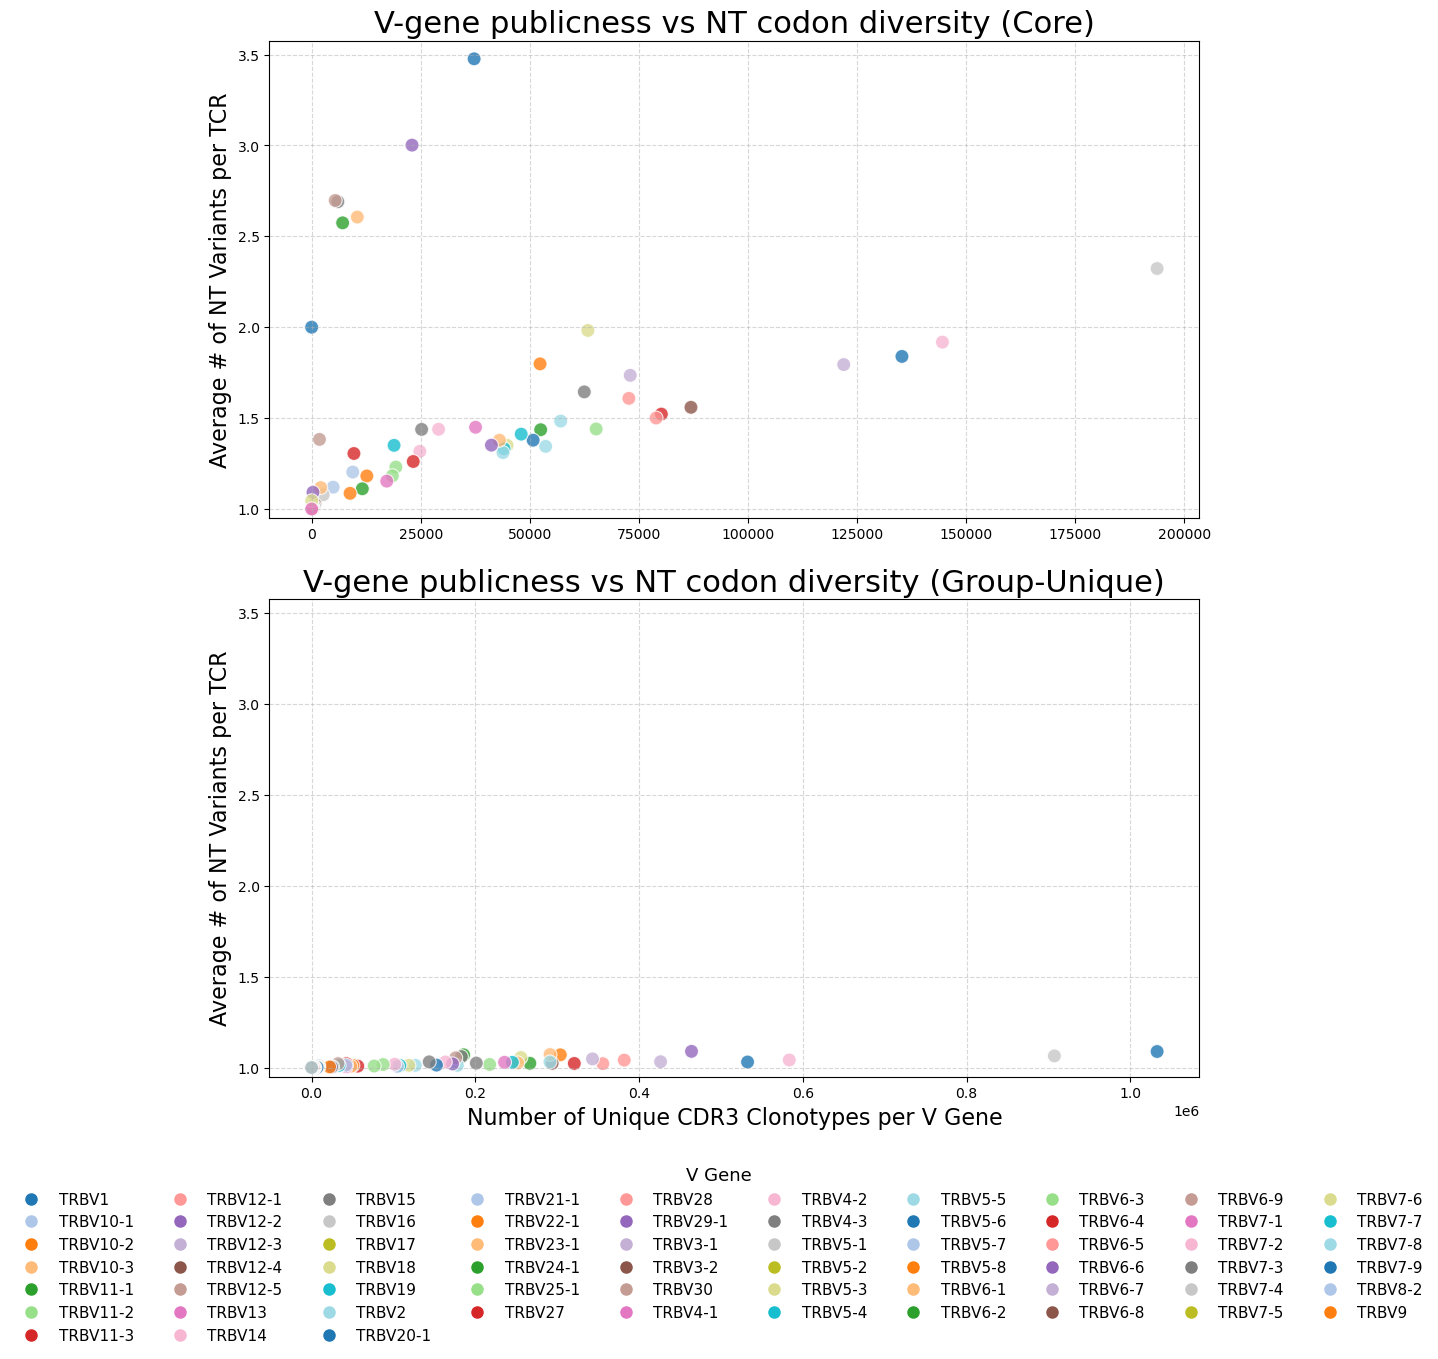

In [112]:
# V gene (compact call)
plot_gene_scatter_stacked(
    df_top=v_summary,
    df_bottom=v_summary_unique,
    gene_col="V_gene",
    x_top="n_public_TCRs",
    x_bottom="n_unique_TCRs",
    title_top="V-gene publicness vs NT codon diversity (Core)",
    title_bottom="V-gene publicness vs NT codon diversity (Group-Unique)",
    xlabel="Number of Unique CDR3 Clonotypes per V Gene",
    legend_title="V Gene",
    out_svg="../colon/V_gene_usage_shared_unique_stacked.svg",
    legend_y=-0.06,
    bottom_margin=0.14,
)


## J Gene Usage

In [89]:
# Filter to relevant rows and columns in one pass (J genes)
df_j = (
    clonotype_df.loc[clonotype_df["aaSeqCDR3"].isin(diff_nt),
                     ["aaSeqCDR3", "nSeqCDR3", "allJHitsWithScore"]]
    .dropna()
    .drop_duplicates()
    .copy()
)

# Extract J gene name (first hit, drop allele)
df_j["J_gene"] = (
    df_j["allJHitsWithScore"]
    .str.split(",").str[0]
    .str.split("*").str[0]
)

# Summary statistics per J gene
j_summary = (
    df_j.groupby(["J_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="nt_variants")          # NT count per clonotype
    .groupby("J_gene")
    .agg(
        n_public_TCRs=("aaSeqCDR3", "nunique"),   # X-axis: shared AA clonotypes per gene
        avg_nt_diversity=("nt_variants", "mean")  # Y-axis: NT variants per AA (mean)
    )
    .reset_index()
    .sort_values("n_public_TCRs", ascending=False)
)


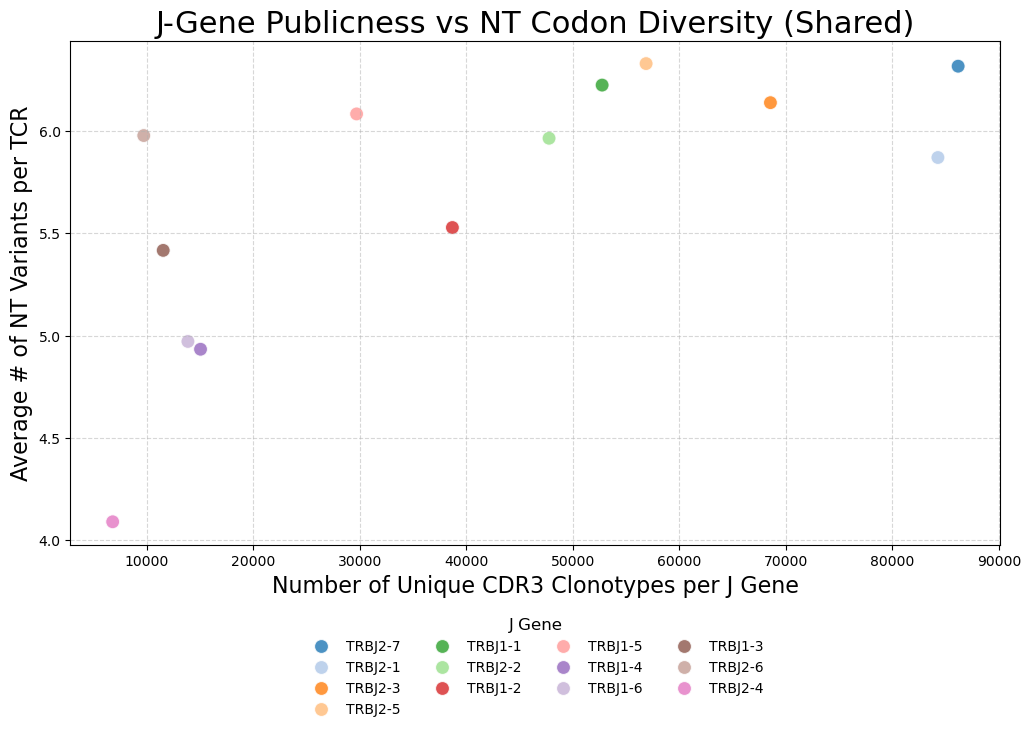

In [90]:
# Global font size for ticks & legend 
plt.rcParams.update({
    "font.size": 10
})

plt.figure(figsize=(12, 8))

sns.scatterplot( data=j_summary, x="n_public_TCRs", y="avg_nt_diversity", hue="J_gene", 
                palette="tab20", s=100, alpha=0.8)

plt.title("J-Gene Publicness vs NT Codon Diversity (Shared)", fontsize=22)
plt.xlabel("Number of Unique CDR3 Clonotypes per J Gene", fontsize=16)
plt.ylabel("Average # of NT Variants per TCR", fontsize=16)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)

n_genes = len(j_summary)
n_cols = min(10, max(4, n_genes // 3))

plt.legend( title="J Gene", loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=n_cols,
            fontsize=10, title_fontsize=12,frameon=False)
plt.subplots_adjust(bottom=0.25)
save_plot("../colon/J_gene_usage_shared.svg", format="svg", bbox_inches="tight")
plt.show()


In [91]:
# Identify Shared AA Sequences
fast_aas = set(clonotype_df.loc[clonotype_df["group"] == "fast", "aaSeqCDR3"].dropna())
slow_aas = set(clonotype_df.loc[clonotype_df["group"] == "slow", "aaSeqCDR3"].dropna())

shared_aas = fast_aas.intersection(slow_aas)
print(f"Excluding {len(shared_aas)} shared AA sequences.")

# Filter for UNIQUE TCRs (non-shared AA clonotypes)
unique_tcr_df = (
    clonotype_df.loc[~clonotype_df["aaSeqCDR3"].isin(shared_aas),
                     ["aaSeqCDR3", "nSeqCDR3", "allJHitsWithScore"]]
    .dropna()
    .drop_duplicates()
    .copy()
)

# Clean J-Genes (first hit, drop allele)
unique_tcr_df["J_gene"] = (
    unique_tcr_df["allJHitsWithScore"]
    .str.split(",").str[0]
    .str.split("*").str[0]
)

# Count distinct NTs per (J_gene, AA)
diversity_unique_j = (
    unique_tcr_df.groupby(["J_gene", "aaSeqCDR3"])["nSeqCDR3"]
    .nunique()
    .reset_index(name="nt_variants")
)

# Summarize by J-Gene
j_summary_unique = (
    diversity_unique_j.groupby("J_gene")
    .agg(
        n_unique_TCRs=("aaSeqCDR3", "nunique"),   # X-axis
        avg_nt_diversity=("nt_variants", "mean")  # Y-axis
    )
    .reset_index()
    .sort_values("n_unique_TCRs", ascending=False)
)


Excluding 522619 shared AA sequences.


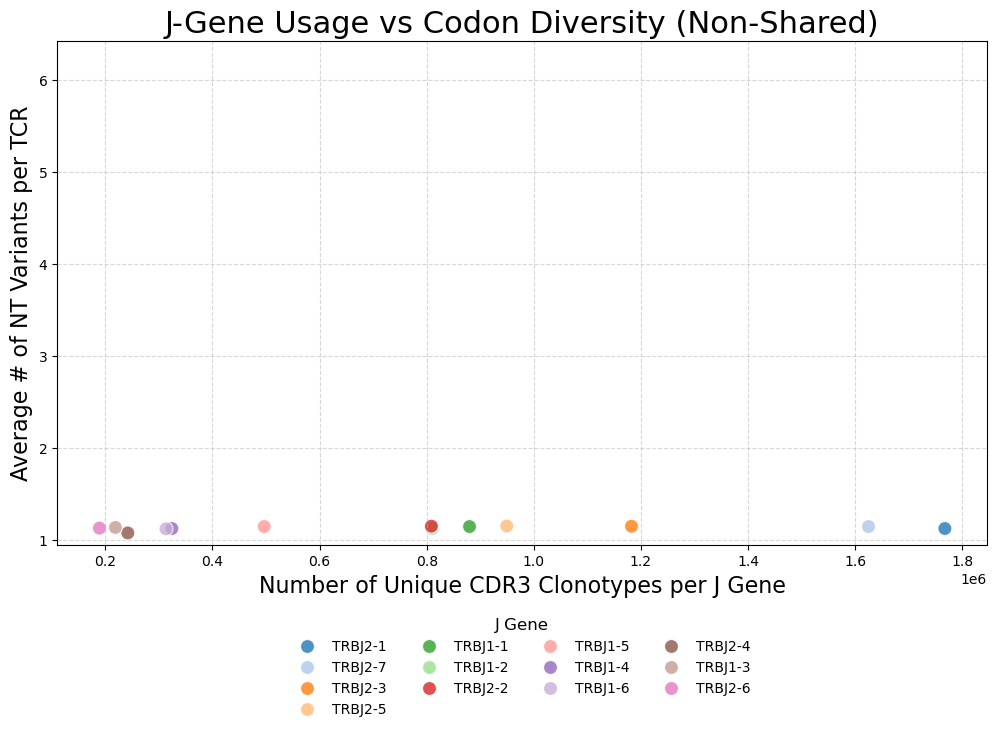

In [92]:
# --- Global font size for ticks & legend ---
plt.rcParams.update({
    "font.size": 10
})

plt.figure(figsize=(12, 8))

sns.scatterplot( data=j_summary_unique, x="n_unique_TCRs", y="avg_nt_diversity", hue="J_gene",
                 palette="tab20", s=100, alpha=0.8)

# Match Y-axis scale to shared plot
if 'j_summary' in locals():
    max_y = j_summary["avg_nt_diversity"].max()
    plt.ylim(0.95, max_y + 0.1)

plt.title("J-Gene Usage vs Codon Diversity (Non-Shared)", fontsize=22)
plt.xlabel("Number of Unique CDR3 Clonotypes per J Gene", fontsize=16)
plt.ylabel("Average # of NT Variants per TCR", fontsize=16)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)

n_genes = len(j_summary_unique)
n_cols = min(10, max(4, n_genes // 3))

plt.legend(title="J Gene", loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=n_cols,
            fontsize=10, title_fontsize=12, frameon=False)

plt.subplots_adjust(bottom=0.25)
save_plot("../colon/J_gene_usage_unique.svg", format="svg", bbox_inches="tight")
plt.show()


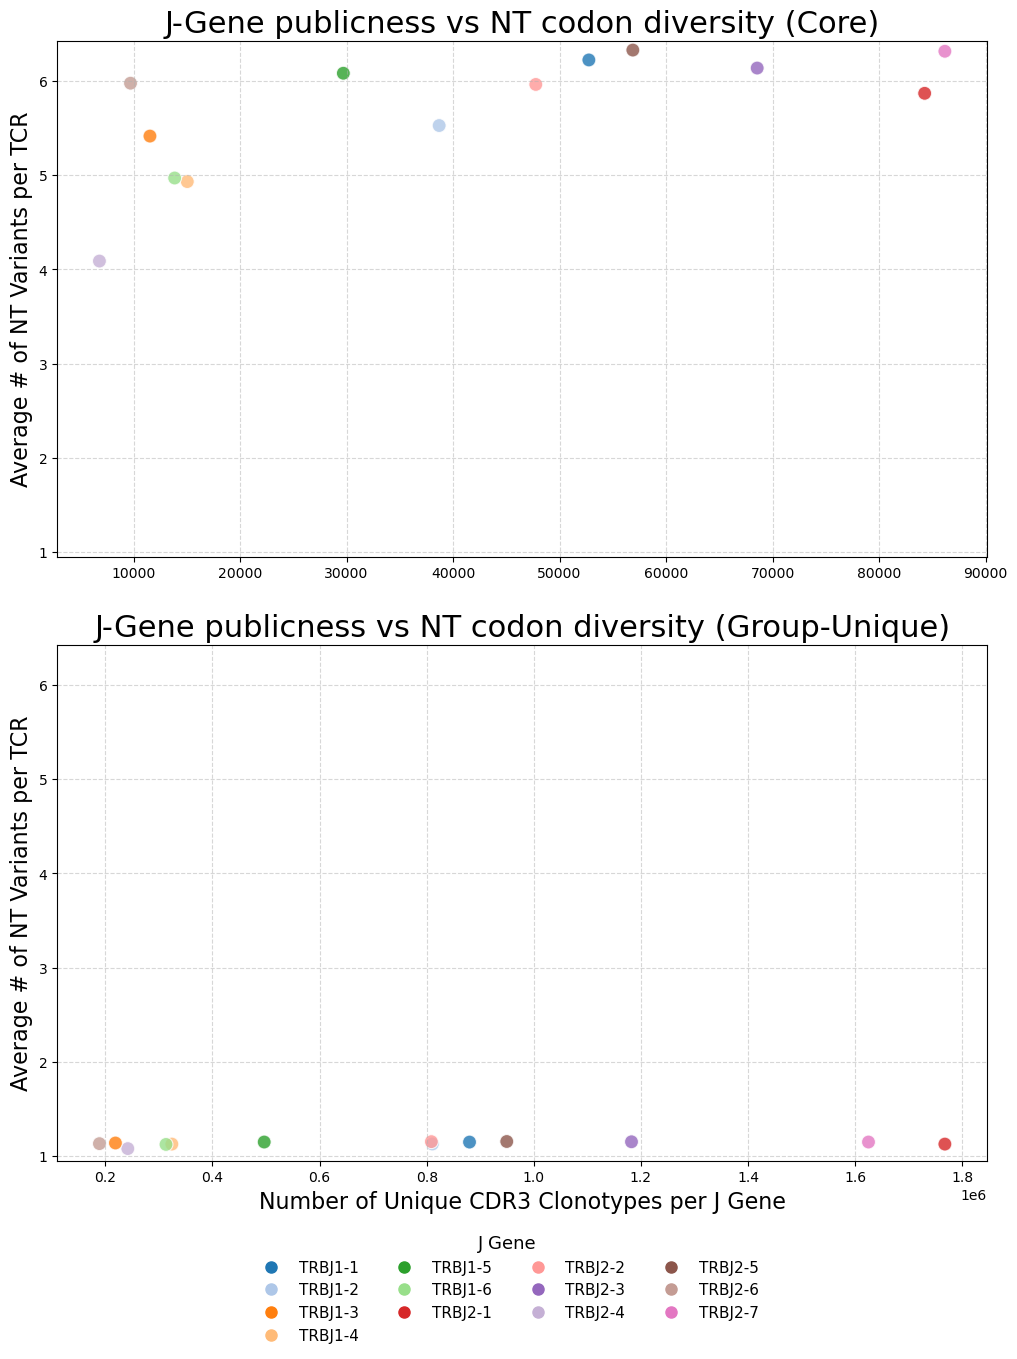

In [113]:
# J gene 
plot_gene_scatter_stacked(
    df_top=j_summary,
    df_bottom=j_summary_unique,
    gene_col="J_gene",
    x_top="n_public_TCRs",
    x_bottom="n_unique_TCRs",
    title_top="J-Gene publicness vs NT codon diversity (Core)",
    title_bottom="J-Gene publicness vs NT codon diversity (Group-Unique)",
    xlabel="Number of Unique CDR3 Clonotypes per J Gene",
    legend_title="J Gene",
    out_svg="../colon/J_gene_usage_shared_unique_stacked.svg",
    legend_y=-0.06,
    bottom_margin=0.08,
)

## Codon frequencies across groups

Analysis of Position-Specific Codon Bias in Unique Repertoires\
Since the "Unique" repertoire contains no overlapping sequences between the Fast and Slow groups, we cannot directly compare codon usage at the clonotype level.<br> Instead, we analyze **position-specific codon bias** by pooling all instances of a given amino acid at each CDR3 position (e.g., comparing all codons coding for Alanine at Position 3).<br> This allows us to detect if Fast and Slow patients exhibit distinct structural nucleotide preferences, even when generating completely unique TCR sequences.
e.g.: We are still looking at Alanine at Position 3, but now the surrounding amino acids (at Pos 2, Pos 4, etc.) are completely different in Immediate vs Delayed group.

To assess codon usage independently of clonal expansion and expression, codon frequencies were computed over the set of distinct nucleotide realizations rather than being weighted by read count or sample prevalence. After matching fast and slow repertoires by sequencing depth and defining shared CDR3 amino-acid sequences, each unique (CDR3 amino-acid sequence, nucleotide sequence) pair was counted once per group. Codon usage was quantified at each amino-acid position within the CDR3, normalized within synonymous codons, and compared between groups using log2 fold change.

In [7]:
# Filter for those with ≥2 appearances in both fast and slow
# TODO: test various values.
codon_frequency_publicness = 3

In [8]:
def explode_codons(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Expand rows of (aaSeqCDR3, nSeqCDR3, group) into per-position codon records:
    columns: AA, Position (1-based), Codon, Group
    Uses fast list-comprehension (not iterrows).
    """
    df_in = df_in[["aaSeqCDR3", "nSeqCDR3", "group"]].dropna().drop_duplicates().copy()

    # sanity: keep only rows where nt length == 3 * aa length
    m = df_in["nSeqCDR3"].str.len() == df_in["aaSeqCDR3"].str.len() * 3
    df_in = df_in[m].copy()

    aa_seqs = df_in["aaSeqCDR3"].tolist()
    nt_seqs = df_in["nSeqCDR3"].tolist()
    grps = df_in["group"].tolist()

    records = [
        {
            "AA": aa_seq[i],
            "Position": i + 1,
            "Codon": nt_seq[i * 3 : i * 3 + 3],
            "Group": grp,
        }
        for aa_seq, nt_seq, grp in zip(aa_seqs, nt_seqs, grps)
        for i in range(len(aa_seq))
    ]
    return pd.DataFrame(records)

def codon_bias_pipeline(
    clonotype_df: pd.DataFrame,
    codon_frequency_publicness: int,
    mode: str,
    shared_aa_candidates=None,
    epsilon: float = 1e-4,
    cdr3_len: int | None = None,
):
    """
    mode:
      - "shared": AA must appear in BOTH groups >= threshold.
                 If shared_aa_candidates provided, restrict to those AA sequences first.
      - "unique": AA must be present in exactly ONE group (0 in the other),
                 and >= threshold in the present group.

    cdr3_len:
      - None (default): keep all AA lengths
      - int: keep only rows where len(aaSeqCDR3) == cdr3_len

    Returns:
      filtered_df, codon_df, codon_counts, codon_pivot
    where codon_pivot contains log2FC_fast_vs_slow using normalization within (AA, Position, Group).
    """
    required_cols = {"aaSeqCDR3", "nSeqCDR3", "Sample_ID", "group"}
    missing = required_cols - set(clonotype_df.columns)
    if missing:
        raise ValueError(f"clonotype_df missing columns: {missing}")

    df_base = clonotype_df[["aaSeqCDR3", "nSeqCDR3", "Sample_ID", "group"]].dropna().drop_duplicates().copy()

    # Optional restriction for shared pipeline (e.g., diff_nt list of AA candidates)
    if mode == "shared" and shared_aa_candidates is not None:
        df_base = df_base[df_base["aaSeqCDR3"].isin(shared_aa_candidates)].copy()

    # Optional length filter (applies before publicness counting)
    if cdr3_len is not None:
        df_base = df_base[df_base["aaSeqCDR3"].str.len() == int(cdr3_len)].copy()

    # Publicness: number of unique samples per (AA, group)
    group_counts = (
        df_base.groupby(["aaSeqCDR3", "group"])["Sample_ID"]
        .nunique()
        .unstack(fill_value=0)
    )

    if mode == "shared":
        keep_aa = group_counts[
            (group_counts.get("fast", 0) >= codon_frequency_publicness) &
            (group_counts.get("slow", 0) >= codon_frequency_publicness)
        ].index

    elif mode == "unique":
        keep_aa = group_counts[
            ((group_counts.get("fast", 0) >= codon_frequency_publicness) & (group_counts.get("slow", 0) == 0)) |
            ((group_counts.get("slow", 0) >= codon_frequency_publicness) & (group_counts.get("fast", 0) == 0))
        ].index

    else:
        raise ValueError("mode must be 'shared' or 'unique'")

    filtered_df = df_base[df_base["aaSeqCDR3"].isin(keep_aa)].copy()

    # Expand to per-position codon records
    codon_df = explode_codons(filtered_df)

    # Count codon usage at AA-position per group
    codon_counts = (
        codon_df.groupby(["AA", "Position", "Codon", "Group"])
        .size()
        .reset_index(name="Count")
    )

    # Normalization 2: within (AA, Position, Group)
    totals = codon_counts.groupby(["AA", "Position", "Group"])["Count"].transform("sum")
    codon_counts["Normalized"] = codon_counts["Count"] / totals

    # Pivot Fast vs Slow
    codon_pivot = codon_counts.pivot_table(
        index=["AA", "Position", "Codon"],
        columns="Group",
        values="Normalized",
        fill_value=0
    ).reset_index()

    codon_pivot["log2FC_fast_vs_slow"] = np.log2(
        (codon_pivot.get("fast", 0) + epsilon) / (codon_pivot.get("slow", 0) + epsilon)
    )

    return filtered_df, codon_df, codon_counts, codon_pivot


In [9]:
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle

def draw_codon_text_legend(
    ax,
    title="Codon",
    loc=(0.5, 0.95),
    fontsize=8,
    title_fontsize=9,
    line_gap=0.07,
    col_gap=0.12,
    n_per_row=2,
):
    """
    Text-only legend with colored codon labels.
    Arranges codons in rows (n_per_row per row).
    """
    handles, labels = ax.get_legend_handles_labels()

    label2color = {}
    for h, lab in zip(handles, labels):
        if not lab or lab == "_nolegend_":
            continue
        if hasattr(h, "get_facecolor") and len(h.get_facecolor()) > 0:
            label2color[lab] = h.get_facecolor()[0]
        elif hasattr(h, "get_color"):
            label2color[lab] = h.get_color()

    if ax.legend_ is not None:
        ax.legend_.remove()

    codons = sorted(label2color.keys())

    x0, y0 = loc

    # Title
    ax.text(x0, y0, title, transform=ax.transAxes, ha="center", va="bottom",
             fontsize=title_fontsize,)

    # Grid layout
    y = y0 - line_gap
    for i, codon in enumerate(codons):
        col = i % n_per_row
        row = i // n_per_row

        x = x0 + (col - (n_per_row - 1) / 2) * col_gap
        y_i = y - row * line_gap

        ax.text(
            x, y_i, codon,
            transform=ax.transAxes,
            ha="center",
            va="bottom",
            fontsize=fontsize,
            color=label2color[codon],
        )

def plot_codon_usage_bias_grid(
    codon_pivot: pd.DataFrame,
    ymin_global: float,
    ymax_global: float,
    group_name: str,
):
    """
    Plot codon usage bias across CDR3 positions as a faceted stripplot grid (one panel per AA).

    Parameters
    ----------
    codon_pivot : pd.DataFrame
        Must contain columns: ["AA", "Position", "Codon", "log2FC_fast_vs_slow"].
    ymin_global, ymax_global : float
        Global y-axis limits to apply to all subplots (so shared/non-shared are comparable).
    group_name : str
        Used only for the figure title, e.g. "Shared" or "Non Shared".

    Notes
    -----
    Everything else (fonts, layout, palette, legend placement, tick sizes, etc.)
    is kept identical to your provided code. Modify inside this function if you want
    aesthetic changes later.
    """
    required = {"AA", "Position", "Codon", "log2FC_fast_vs_slow"}
    assert required.issubset(codon_pivot.columns), f"codon_pivot missing: {required - set(codon_pivot.columns)}"

    df = codon_pivot.copy()
    df["Position"] = pd.to_numeric(df["Position"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["AA", "Position", "Codon", "log2FC_fast_vs_slow"]).copy()
    df["Position"] = df["Position"].astype(int)

    amino_acids = sorted(df["AA"].unique())
    if len(amino_acids) == 0:
        raise ValueError("No amino acids to plot after filtering.")

    max_pos = int(df["Position"].max())

    # Make Position a strict ordered categorical (string labels) so seaborn order matches perfectly
    pos_order = [str(i) for i in range(1, max_pos + 1)]
    df["Position_cat"] = pd.Categorical(df["Position"].astype(str), categories=pos_order, ordered=True)

    n_cols = 5
    n_rows = (len(amino_acids) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=True)
    axes = np.array(axes).ravel()

    fig.suptitle(f"Codon Usage Bias Across CDR3 Positions ({group_name})", fontsize=22, y=1.02)

    # Main loop
    for i, aa in enumerate(amino_acids):
        ax = axes[i]
        aa_data = df[df["AA"] == aa]

        sns.stripplot(
            data=aa_data, x="Position_cat", y="log2FC_fast_vs_slow",
            hue="Codon", order=pos_order, dodge=True, jitter=True,
            palette="tab20", ax=ax
        )

        draw_codon_text_legend(
            ax, "Codon", (0.5, 0.25),
            n_per_row=2, fontsize=8, title_fontsize=9,
            line_gap=0.07, col_gap=0.14
        )

        ax.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax.set_title(f"Amino Acid: {aa}", fontsize=16)

        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.tick_params(axis="both", labelsize=8)

        ax.set_xlim(-0.5, max_pos - 0.5)
        ax.set_xticks(np.arange(max_pos))
        ax.set_xticklabels(pos_order)

        ax.set_ylim(ymin_global, ymax_global)
        ax.yaxis.set_major_locator(MultipleLocator(2.5))

    # Remove unused panels
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(top=0.90, hspace=0.60)
    fig.supxlabel("CDR3 Position", fontsize=18, y=0.04)
    fig.supylabel("log2FC (Immediate vs Delayed)", fontsize=18, x=0.08)

    plt.show()


def plot_codon_bias_by_aa(
    codon_pivot: pd.DataFrame,
    group_name: str,
    figsize=(16, 6),
    legend_ncol=12,
):
    """
    Aggregate log2FC by (AA, Codon) and plot as a stripplot.
    Expects codon_pivot columns: AA, Codon, log2FC_fast_vs_slow.
    """
    required = {"AA", "Codon", "log2FC_fast_vs_slow"}
    assert required.issubset(codon_pivot.columns), f"codon_pivot missing: {required - set(codon_pivot.columns)}"

    aa_grouped = (
        codon_pivot.groupby(["AA", "Codon"], as_index=False)
        .agg({"log2FC_fast_vs_slow": "mean"})
    )

    plt.figure(figsize=figsize)
    sns.stripplot( data=aa_grouped, x="AA", y="log2FC_fast_vs_slow",hue="Codon",
                   dodge=True, palette="tab20", jitter=True,)

    plt.axhline(0, color="gray", linestyle="--")
    plt.title(f"Codon Usage Bias by Amino Acid ({group_name})")
    plt.ylabel("log2 Fold Change (Immediate vs slow)")
    plt.xlabel("Amino Acid")
    plt.grid(True, axis="y", linestyle=":", alpha=0.5)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, title="Codon", loc="upper center",
     bbox_to_anchor=(0.5, -0.25), ncol=legend_ncol, fontsize=8, title_fontsize=9, frameon=False,)

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.show()


In [10]:
# SHARED pipeline
# shared_aa_candidates should be your "diff_nt" (or None if you want all AAs considered)
filtered_codon_df, codon_df, codon_counts, codon_pivot = codon_bias_pipeline(
    clonotype_df=clonotype_df,
    codon_frequency_publicness=codon_frequency_publicness,
    mode="shared",
    shared_aa_candidates=diff_nt,
    epsilon=1e-4,
    cdr3_len=None
)

print(
    f"[SHARED] {filtered_codon_df['aaSeqCDR3'].nunique()} AA sequences kept | "
    f"fast samples: {filtered_codon_df[filtered_codon_df['group']=='fast']['Sample_ID'].nunique()} | "
    f"slow samples: {filtered_codon_df[filtered_codon_df['group']=='slow']['Sample_ID'].nunique()}"
)


[SHARED] 55856 AA sequences kept | fast samples: 153 | slow samples: 58


In [11]:
# UNIQUE pipeline
filtered_codon_df_unique, codon_df_unique, codon_counts_unique, codon_pivot_unique = codon_bias_pipeline(
    clonotype_df=clonotype_df,
    codon_frequency_publicness=codon_frequency_publicness,
    mode="unique",
    shared_aa_candidates=None,
    epsilon=1e-4,
    cdr3_len=None
)

print(
    f"[UNIQUE] {filtered_codon_df_unique['aaSeqCDR3'].nunique()} AA sequences kept | "
    f"fast samples: {filtered_codon_df_unique[filtered_codon_df_unique['group']=='fast']['Sample_ID'].nunique()} | "
    f"slow samples: {filtered_codon_df_unique[filtered_codon_df_unique['group']=='slow']['Sample_ID'].nunique()}"
)


[UNIQUE] 278672 AA sequences kept | fast samples: 153 | slow samples: 58


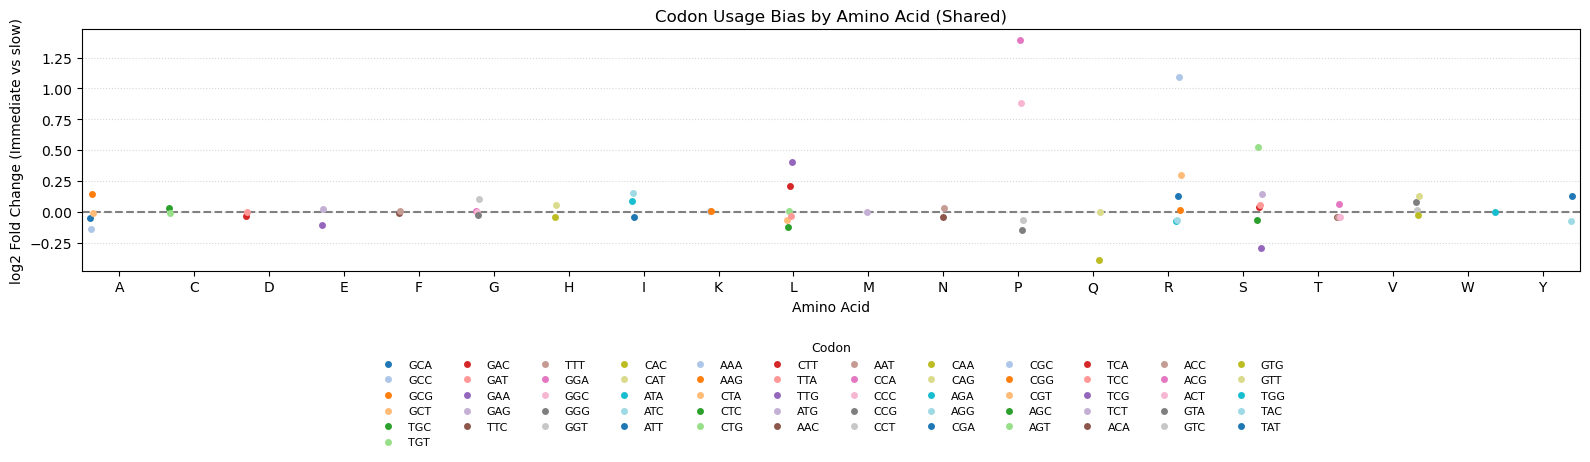

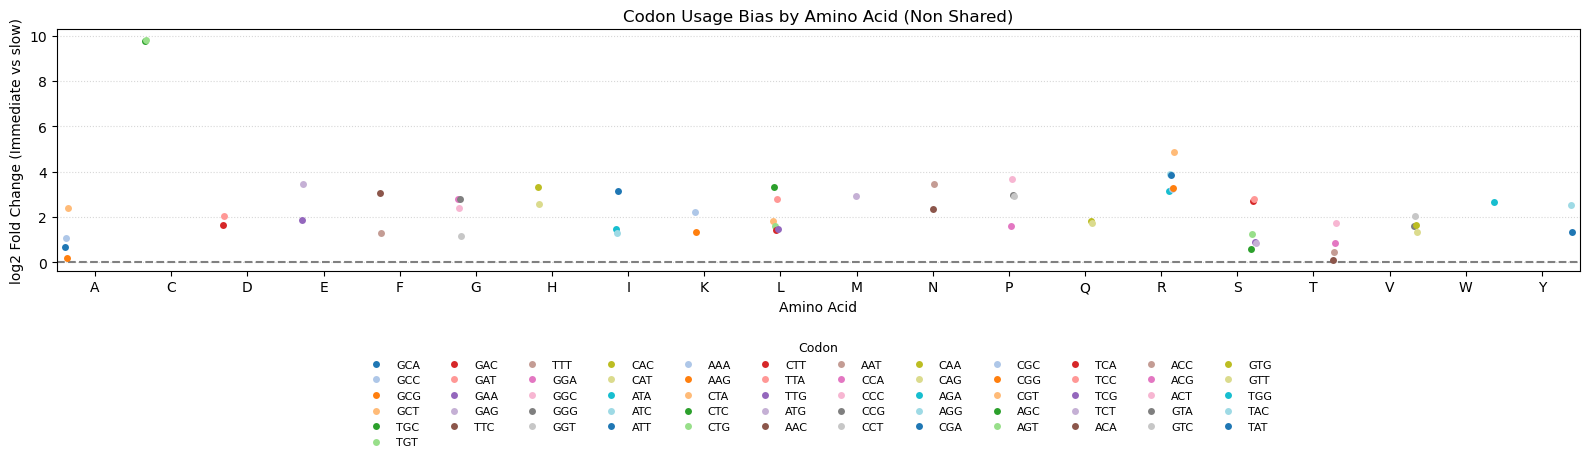

In [12]:
plot_codon_bias_by_aa(codon_pivot, "Shared")
plot_codon_bias_by_aa(codon_pivot_unique, "Non Shared")

In [13]:
from matplotlib.ticker import MultipleLocator

def compute_symmetric_ylim(values, q=0.99, pad=0.5):
    v = pd.to_numeric(values, errors="coerce").dropna()
    if v.empty:
        return (-1, 1)
    lim = float(v.abs().quantile(q))   # robust to outliers
    lim = max(lim + pad, 1.0)
    lim = np.ceil(lim * 2) / 2         # round to nearest 0.5
    return (-lim, lim)

all_vals = pd.concat([
    codon_pivot["log2FC_fast_vs_slow"],
    codon_pivot_unique["log2FC_fast_vs_slow"]
], ignore_index=True)

ymin_global, ymax_global = compute_symmetric_ylim(all_vals, q=0.99, pad=0.5)



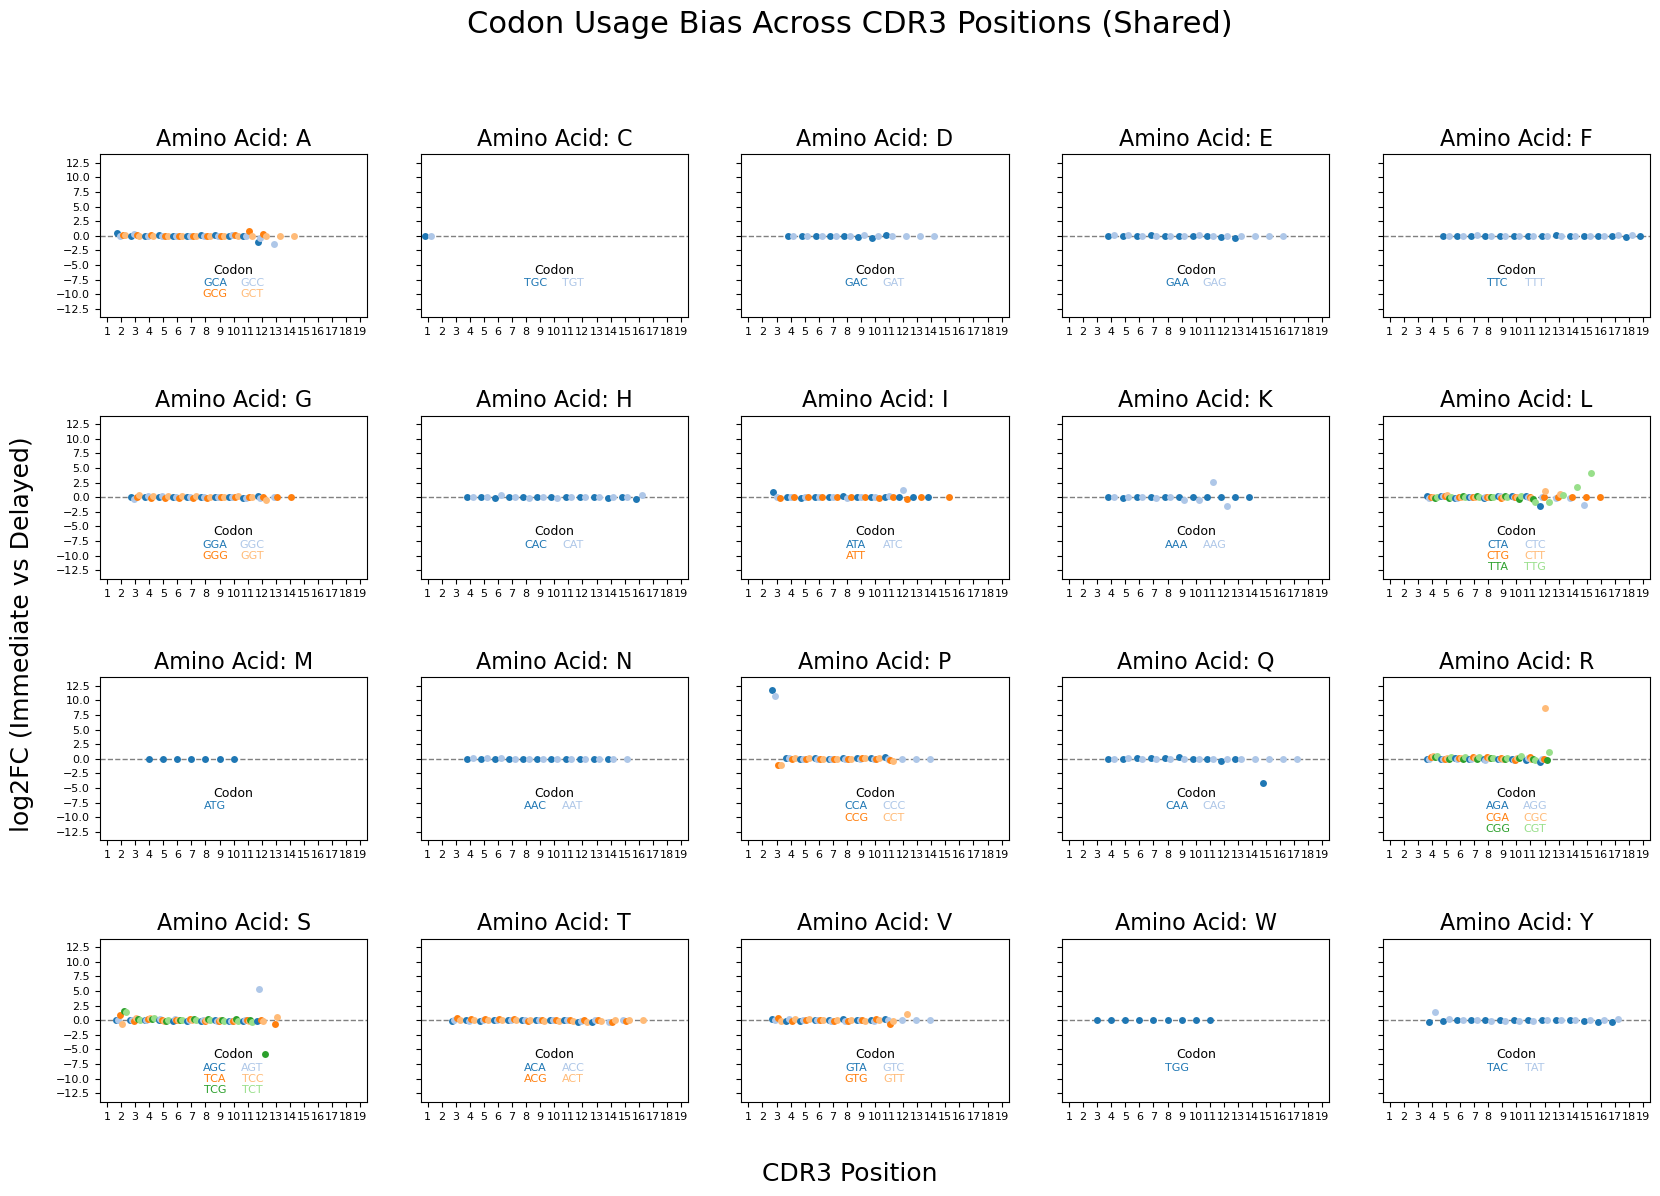

In [14]:
plot_codon_usage_bias_grid(codon_pivot, ymin_global, ymax_global, "Shared")

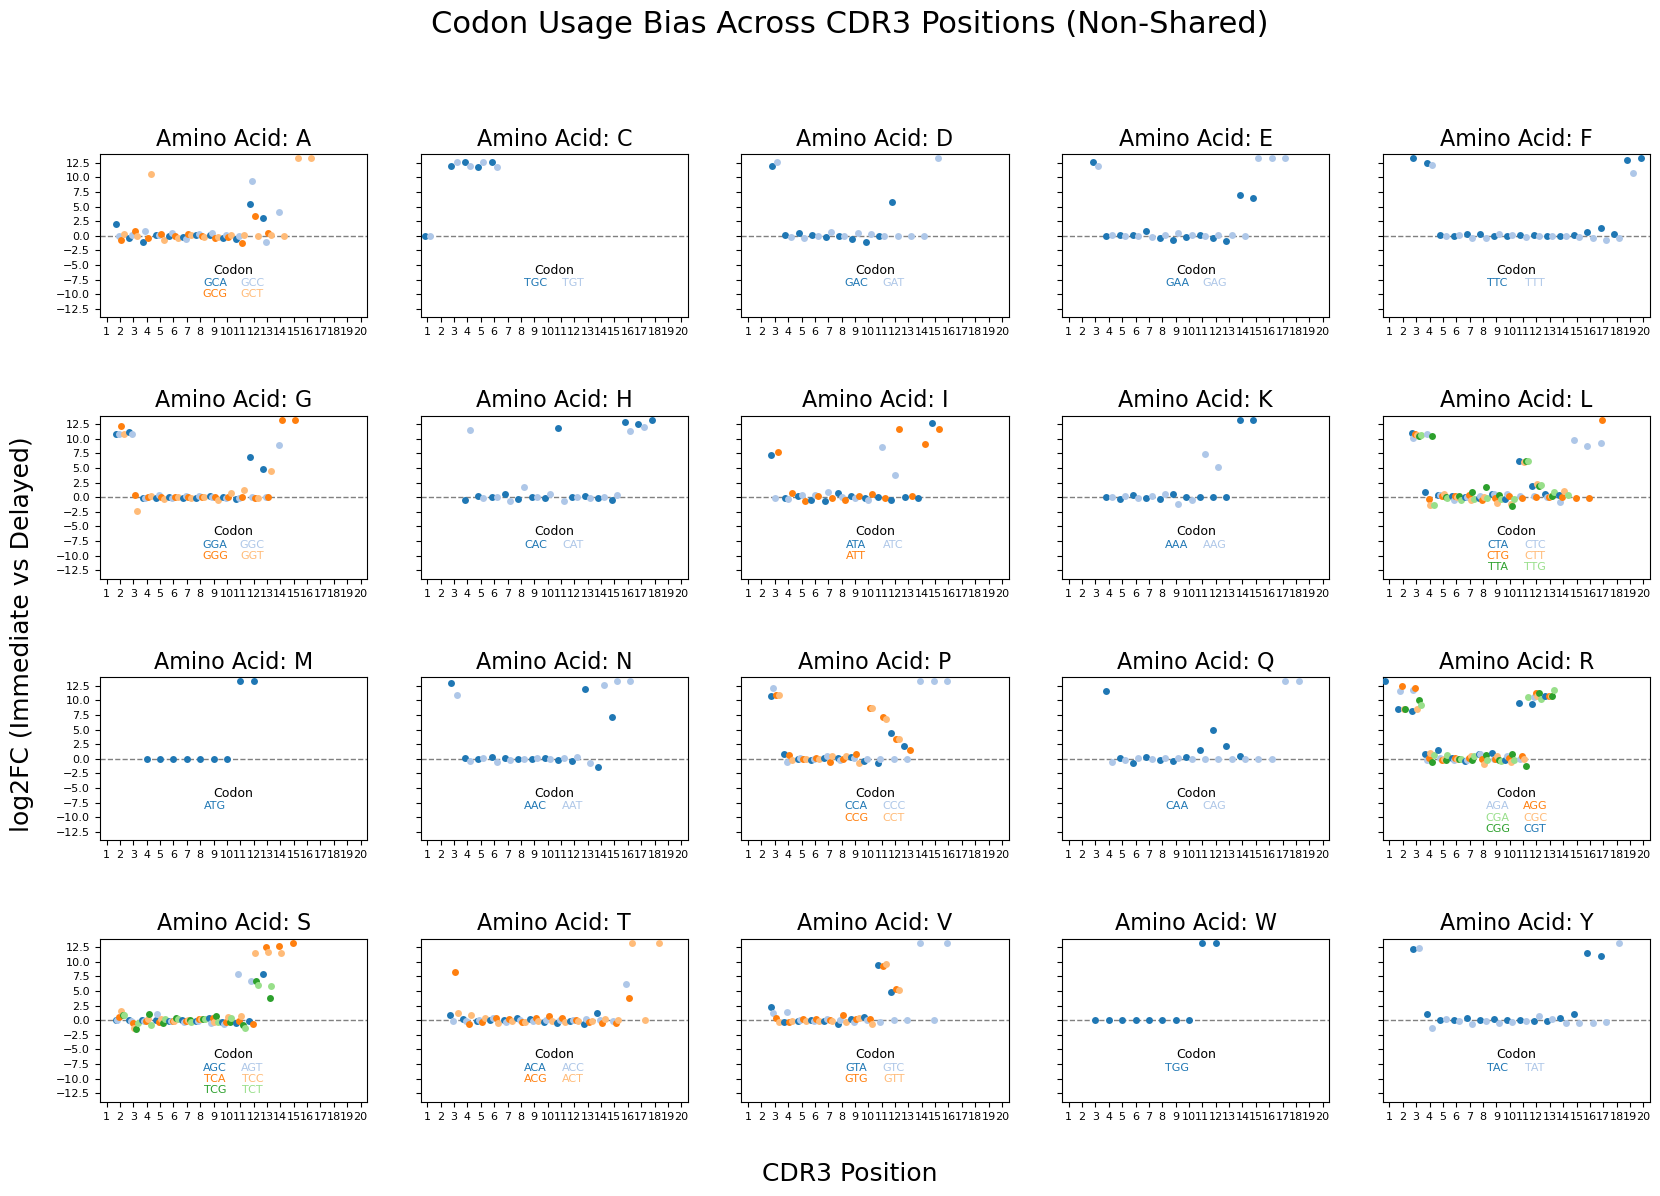

In [15]:
plot_codon_usage_bias_grid(codon_pivot_unique, ymin_global, ymax_global, "Non-Shared")

Now lets "zoom in" on Specific CDR3 length Sequences:

In [16]:
# SHARED pipeline
filtered_codon_df_15, codon_df_15, codon_counts_15, codon_pivot_15 = codon_bias_pipeline(
    clonotype_df=clonotype_df,
    codon_frequency_publicness=codon_frequency_publicness,
    mode="shared",
    shared_aa_candidates=diff_nt,  # set to None if you don't want to restrict
    epsilon=1e-4,
    cdr3_len=15
)

print(
    f"[SHARED] {filtered_codon_df_15['aaSeqCDR3'].nunique()} AA sequences kept | "
    f"fast samples: {filtered_codon_df_15[filtered_codon_df_15['group']=='fast']['Sample_ID'].nunique()} | "
    f"slow samples: {filtered_codon_df_15[filtered_codon_df_15['group']=='slow']['Sample_ID'].nunique()}"
)


[SHARED] 11223 AA sequences kept | fast samples: 153 | slow samples: 58


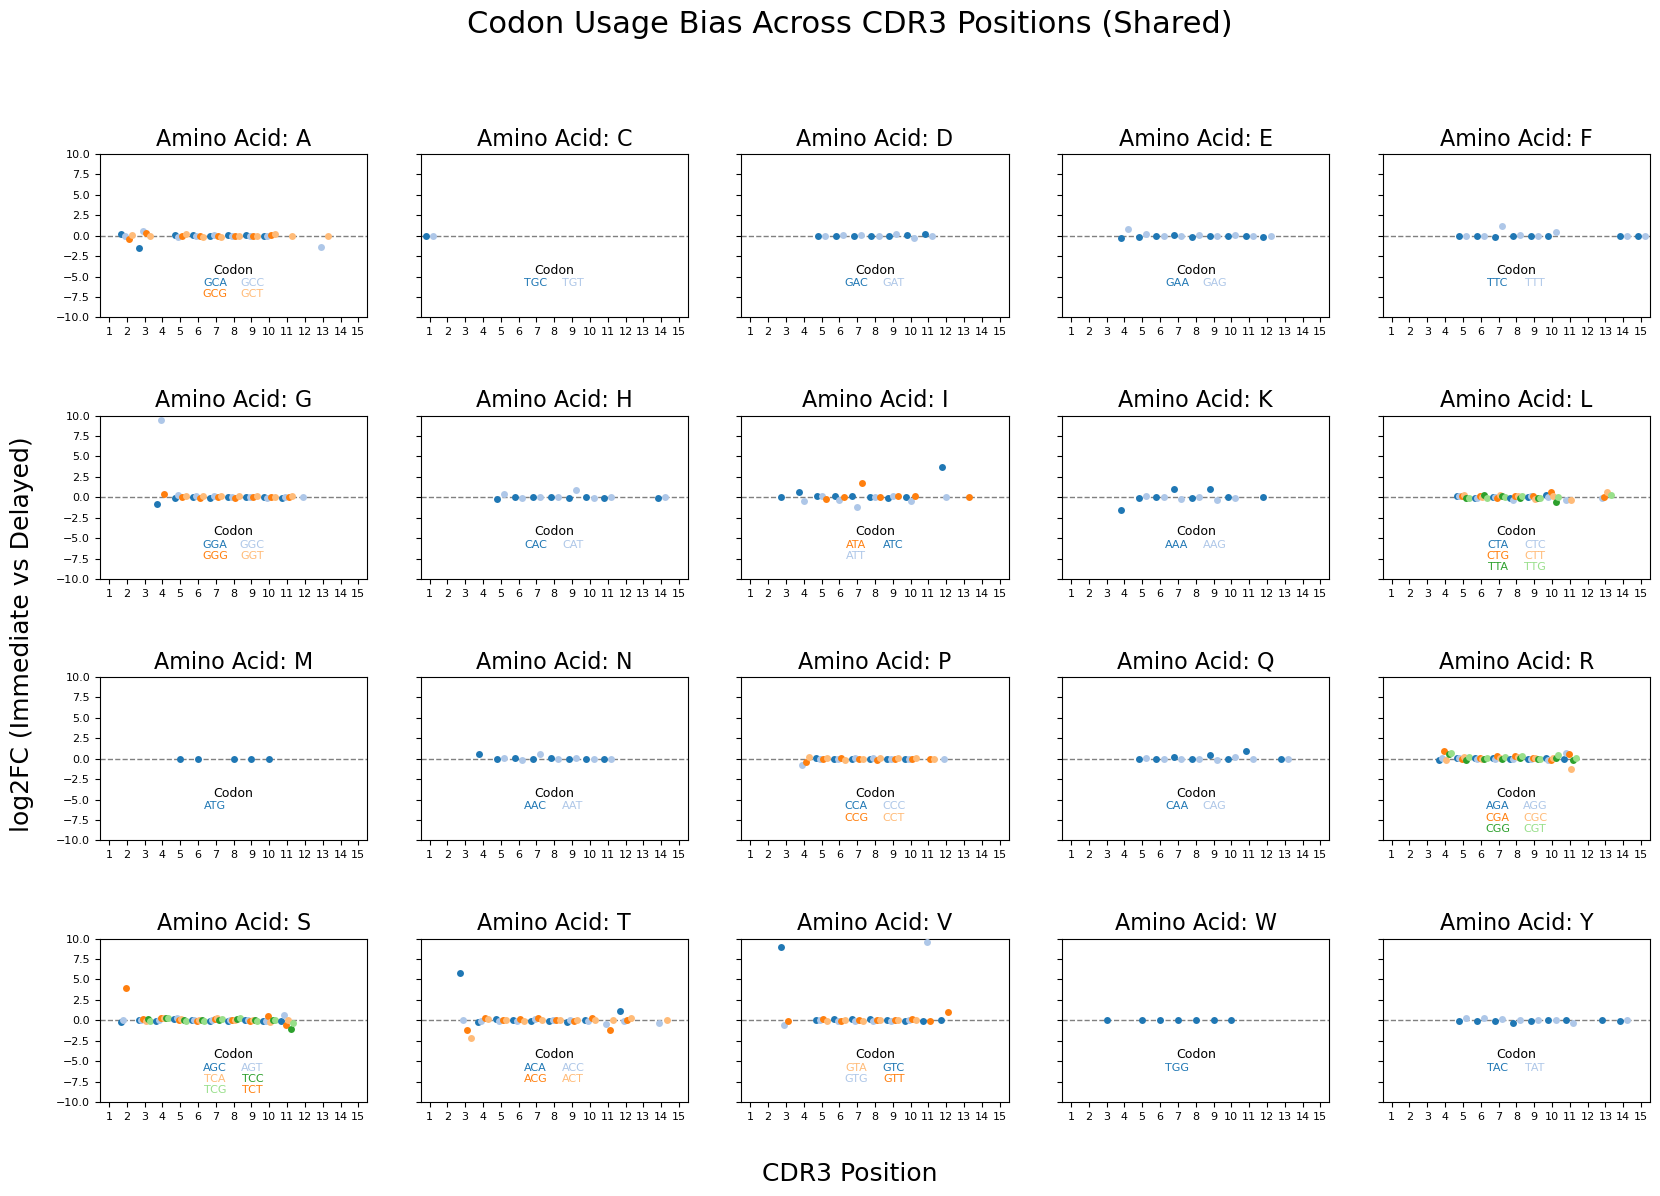

In [17]:
plot_codon_usage_bias_grid(codon_pivot_15, -10, 10, "Shared")


In [18]:
# UNIQUE pipeline
filtered_codon_df_unique_15, codon_df_unique_15, codon_counts_unique_15, codon_pivot_unique_15 = codon_bias_pipeline(
    clonotype_df=clonotype_df,
    codon_frequency_publicness=codon_frequency_publicness,
    mode="unique",
    shared_aa_candidates=None,
    epsilon=1e-4,
    cdr3_len=15
)

print(
    f"[UNIQUE] {filtered_codon_df_unique_15['aaSeqCDR3'].nunique()} AA sequences kept | "
    f"fast samples: {filtered_codon_df_unique_15[filtered_codon_df_unique_15['group']=='fast']['Sample_ID'].nunique()} | "
    f"slow samples: {filtered_codon_df_unique_15[filtered_codon_df_unique_15['group']=='slow']['Sample_ID'].nunique()}"
)


[UNIQUE] 72927 AA sequences kept | fast samples: 153 | slow samples: 55


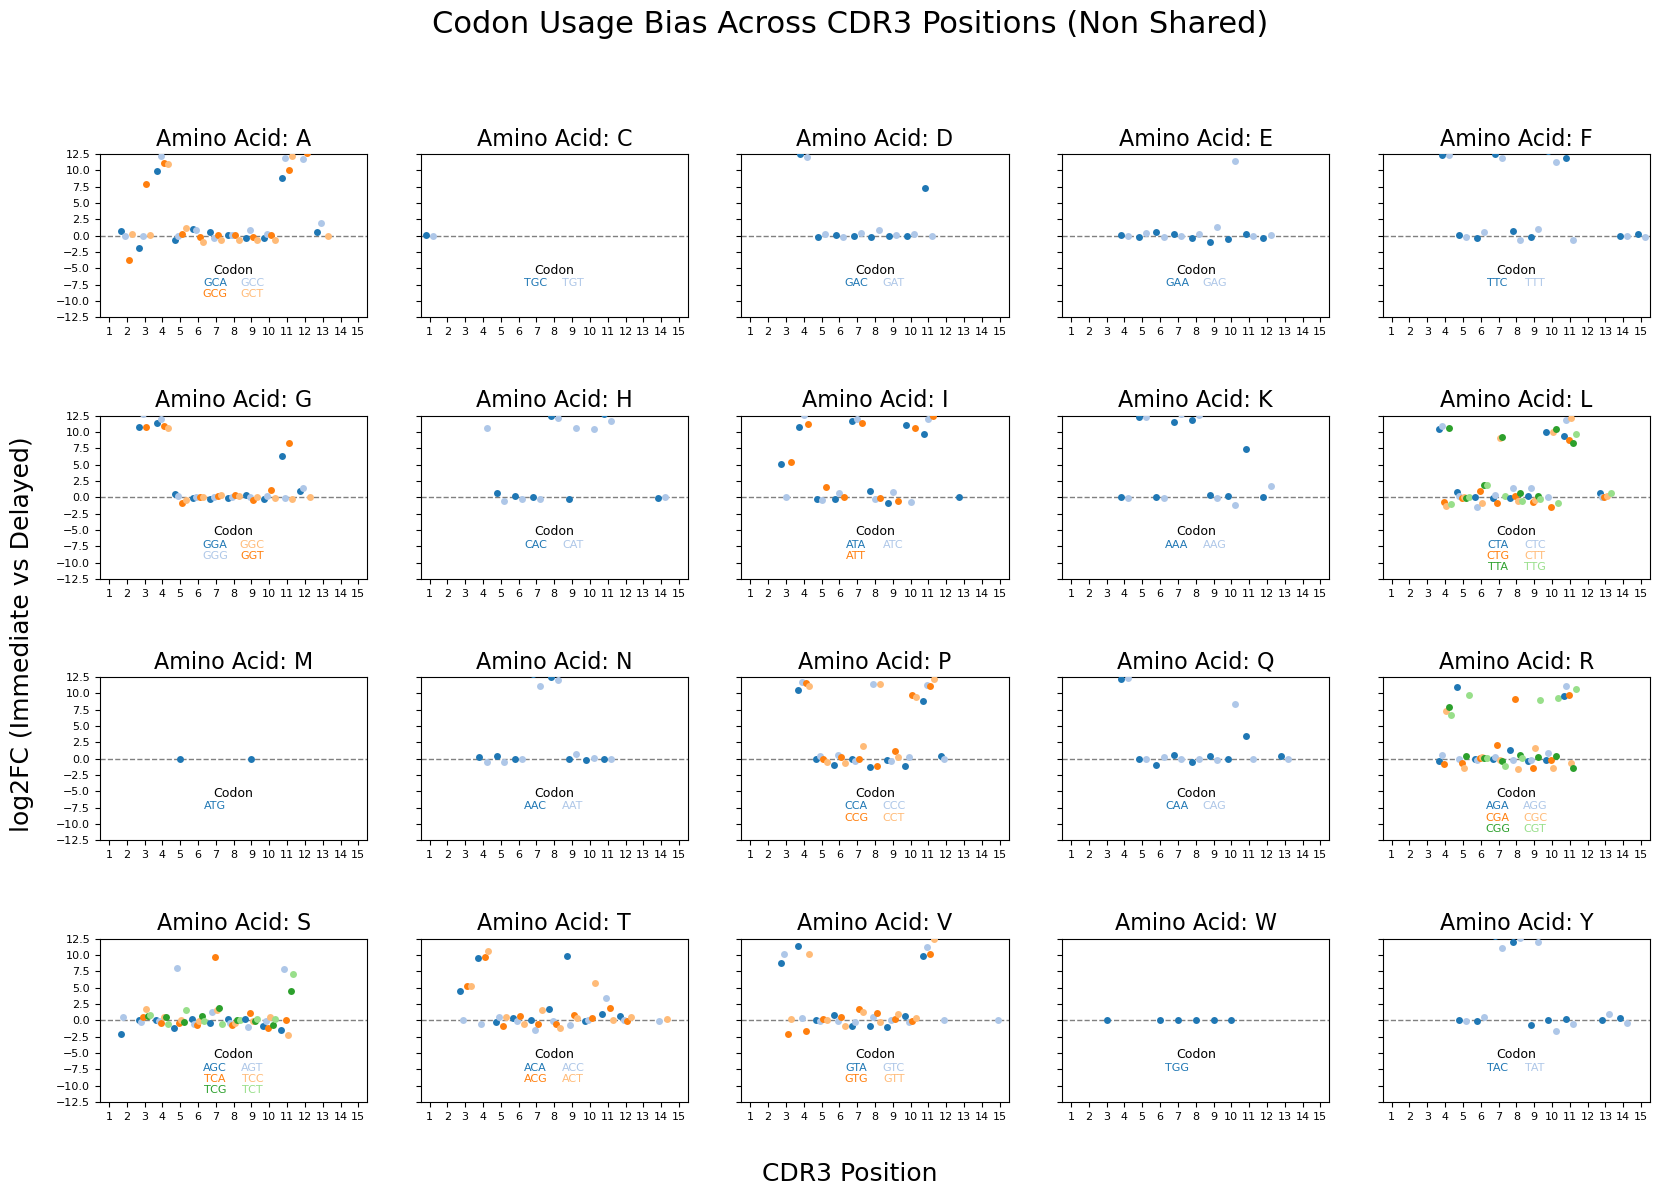

In [19]:
plot_codon_usage_bias_grid(codon_pivot_unique_15, -12.5, 12.5, "Non Shared")


For V and J gene codon usage analyses, fast and slow samples were first matched by sequencing depth, downsampled to a common read budget, and shared/unique clonotypes were defined after normalization, ensuring that codon bias comparisons were not confounded by expression or library size differences.

#### two step normalization

In [20]:
from typing import Tuple, Dict, Set
def match_fast_to_slow_by_reads(
    clonotype_df: pd.DataFrame,
    read_col: str,
    group_col: str = "group",
    sample_col: str = "Sample_ID",
    fast_label: str = "fast",
    slow_label: str = "slow",
    match_on: str = "log",  # "log" or "raw"
) -> pd.DataFrame:
    """
    1-to-1 greedy matching: for each slow sample, pick the closest fast sample
    by (log) total reads, without replacement.

    Returns a dataframe with matched samples only (both groups kept).
    """
    req = {sample_col, group_col, read_col}
    missing = req - set(clonotype_df.columns)
    if missing:
        raise ValueError(f"clonotype_df missing columns: {missing}")

    # total reads per sample
    sample_reads = (
        clonotype_df.groupby([sample_col, group_col], as_index=False)[read_col]
        .sum()
        .rename(columns={read_col: "total_reads"})
    )

    slow = sample_reads[sample_reads[group_col] == slow_label].copy()
    fast = sample_reads[sample_reads[group_col] == fast_label].copy()

    if slow.empty or fast.empty:
        raise ValueError("One of the groups is empty after aggregating sample reads.")

    if match_on == "log":
        slow["m"] = np.log10(slow["total_reads"].clip(lower=1))
        fast["m"] = np.log10(fast["total_reads"].clip(lower=1))
    elif match_on == "raw":
        slow["m"] = slow["total_reads"]
        fast["m"] = fast["total_reads"]
    else:
        raise ValueError("match_on must be 'log' or 'raw'")

    # Greedy matching without replacement
    slow_sorted = slow.sort_values("m").reset_index(drop=True)
    fast_sorted = fast.sort_values("m").reset_index(drop=True)

    fast_vals = fast_sorted["m"].to_numpy()
    fast_ids = fast_sorted[sample_col].to_numpy()
    fast_used = np.zeros(len(fast_sorted), dtype=bool)

    matched_fast_ids = []
    for s_val in slow_sorted["m"].to_numpy():
        # find nearest available fast sample
        # start from insertion point, then expand outward until find unused
        idx = int(np.searchsorted(fast_vals, s_val, side="left"))
        left = idx - 1
        right = idx

        best_j = None
        best_dist = None

        while left >= 0 or right < len(fast_vals):
            candidates = []
            if left >= 0 and not fast_used[left]:
                candidates.append(left)
            if right < len(fast_vals) and not fast_used[right]:
                candidates.append(right)

            if candidates:
                # pick closest among candidates
                dists = [abs(fast_vals[j] - s_val) for j in candidates]
                j = candidates[int(np.argmin(dists))]
                best_j = j
                best_dist = abs(fast_vals[j] - s_val)
                break

            left -= 1
            right += 1

        if best_j is None:
            # not enough fast samples to match all slow samples
            break

        fast_used[best_j] = True
        matched_fast_ids.append(fast_ids[best_j])

    matched_slow_ids = slow_sorted.loc[: len(matched_fast_ids) - 1, sample_col].tolist()

    keep_samples = set(matched_slow_ids) | set(matched_fast_ids)
    df_matched = clonotype_df[clonotype_df[sample_col].isin(keep_samples)].copy()

    return df_matched

def downsample_reads_within_sample_multinomial(
    df: pd.DataFrame,
    read_col: str,
    target_reads: int,
    sample_col: str = "Sample_ID",
    group_col: str = "group",
    seed: int = 0,
    out_col: str = "ds_reads",
) -> pd.DataFrame:
    """
    For each sample, downsample clonotype read counts to target_reads using a multinomial draw.
    Keeps the same rows; adds a new column out_col with downsampled counts.

    Assumes read_col is integer-like counts per row (clonotype).
    """
    if target_reads <= 0:
        raise ValueError("target_reads must be > 0")

    rng = np.random.default_rng(seed)

    df = df.copy()
    df[read_col] = pd.to_numeric(df[read_col], errors="coerce")
    df = df.dropna(subset=[read_col])
    df = df[df[read_col] > 0].copy()

    def _ds_one_sample(sub: pd.DataFrame) -> pd.DataFrame:
        counts = sub[read_col].to_numpy(dtype=float)
        total = counts.sum()
        if total <= 0:
            sub[out_col] = 0
            return sub

        # If sample has fewer reads than target, keep as-is (or optionally upsample; we won't).
        if total <= target_reads:
            sub[out_col] = counts.astype(int)
            return sub

        p = counts / total
        draw = rng.multinomial(target_reads, pvals=p)
        sub[out_col] = draw.astype(int)
        return sub

    df = (
        df.groupby([sample_col, group_col], group_keys=False, sort=False)
        .apply(_ds_one_sample)
        .reset_index(drop=True))

    return df

def define_shared_unique_sets_after_downsampling(
    df_down: pd.DataFrame,
    thresh: int,
    aa_col: str = "aaSeqCDR3",
    sample_col: str = "Sample_ID",
    group_col: str = "group",
    fast_label: str = "fast",
    slow_label: str = "slow",
    ds_col: str = "ds_reads",
) -> Tuple[Set[str], Set[str], Set[str], pd.DataFrame]:
    """
    Define sets based on the FINAL matched+downsampled data.
    Presence is defined as ds_reads > 0 for that (AA, sample).
    Returns: shared_set, unique_fast_set, unique_slow_set, df_counts
    """
    req = {aa_col, sample_col, group_col, ds_col}
    missing = req - set(df_down.columns)
    if missing:
        raise ValueError(f"df_down missing columns: {missing}")

    # One row per (AA, Sample, Group) with presence
    pres = (
        df_down.loc[df_down[ds_col] > 0, [aa_col, sample_col, group_col]]
        .drop_duplicates().copy())

    df_counts = (
        pres.groupby([aa_col, group_col])[sample_col]
        .nunique().unstack(fill_value=0))

    shared_set = set(df_counts[
            (df_counts.get(fast_label, 0) >= thresh) &
            (df_counts.get(slow_label, 0) >= thresh)].index)

    unique_fast_set = set(df_counts[
            (df_counts.get(fast_label, 0) >= thresh) &
            (df_counts.get(slow_label, 0) == 0)].index)

    unique_slow_set = set(df_counts[
            (df_counts.get(slow_label, 0) >= thresh) &
            (df_counts.get(fast_label, 0) == 0)].index)

    return shared_set, unique_fast_set, unique_slow_set, df_counts


In [21]:
import numpy as np
import pandas as pd


def codon_bias_from_filtered_df(df_in: pd.DataFrame, epsilon: float = 1e-4, cdr3_len=None):
    """
    Compute codon usage and log2FC_fast_vs_slow from a dataframe already filtered
    to the desired AA set (e.g., shared_set_std) and thresholded by ds_reads.

    Requires columns: aaSeqCDR3, nSeqCDR3, group
    """
    df = df_in[["aaSeqCDR3", "nSeqCDR3", "group"]].dropna().copy()

    # optional length filter
    if cdr3_len is not None:
        df = df[df["aaSeqCDR3"].str.len() == int(cdr3_len)].copy()

    # SAME as before: universe = unique (AA, nt, group)
    df = df.drop_duplicates(subset=["aaSeqCDR3", "nSeqCDR3", "group"])

    codon_df = explode_codons(df)

    codon_counts = (
        codon_df.groupby(["AA", "Position", "Codon", "Group"])
        .size()
        .reset_index(name="Count")
    )

    totals = codon_counts.groupby(["AA", "Position", "Group"])["Count"].transform("sum")
    codon_counts["Normalized"] = codon_counts["Count"] / totals

    codon_pivot = codon_counts.pivot_table(
        index=["AA", "Position", "Codon"],
        columns="Group",
        values="Normalized",
        fill_value=0
    ).reset_index()

    codon_pivot["log2FC_fast_vs_slow"] = np.log2(
        (codon_pivot.get("fast", 0) + epsilon) / (codon_pivot.get("slow", 0) + epsilon)
    )

    return codon_df, codon_counts, codon_pivot


In [22]:
# match -> downsample -> define shared/unique

READ_COL = "readCount"   
THRESH = 3                

# Match fast to slow by (log) total reads, keep paired samples
clonotype_df_matched = match_fast_to_slow_by_reads(
    clonotype_df=clonotype_df,
    read_col=READ_COL,
    match_on="log",
)

# Choose downsampling depth = lowest total reads across matched samples (both groups)
sample_totals_matched = (
    clonotype_df_matched.groupby(["Sample_ID", "group"], as_index=False)[READ_COL]
    .sum()
    .rename(columns={READ_COL: "total_reads"})
)

target_reads = int(sample_totals_matched["total_reads"].min())

# 3) Downsample within each sample to target_reads
clonotype_df_down = downsample_reads_within_sample_multinomial(
    df=clonotype_df_matched,
    read_col=READ_COL,
    target_reads=target_reads,
    seed=0,
    out_col="ds_reads",
)


/tmp/ipykernel_501051/1320188374.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_ds_one_sample)


In [23]:
# 4) Define shared/unique sets AFTER matching+downsampling
shared_set_std, unique_fast_set_std, unique_slow_set_std, df_counts_std = (
    define_shared_unique_sets_after_downsampling(
        df_down=clonotype_df_down,
        thresh=THRESH,
        ds_col="ds_reads",
    )
)

print(f"shared_set_std: {len(shared_set_std)}")
print(f"unique_fast_set_std: {len(unique_fast_set_std)}")
print(f"unique_slow_set_std: {len(unique_slow_set_std)}")

shared_set_std: 27987
unique_fast_set_std: 19646
unique_slow_set_std: 4527


In [24]:
df_shared = clonotype_df_down[
    (clonotype_df_down["aaSeqCDR3"].isin(shared_set_std)) &
    (clonotype_df_down["ds_reads"] >= THRESH)
].copy()

# restrict shared sequences to diff_nt only
df_shared_diff_nt = df_shared[df_shared["aaSeqCDR3"].isin(diff_nt)].copy()
print(df_shared_diff_nt["aaSeqCDR3"].nunique())


27712


In [25]:
codon_df_shared, codon_counts_shared, codon_pivot_shared = codon_bias_from_filtered_df(
    df_in=df_shared_diff_nt,
    epsilon=1e-4,
    cdr3_len=None
)


In [26]:
codon_pivot_shared.head()

Group AA  Position Codon      fast      slow  log2FC_fast_vs_slow
0      A         2   GCA  0.000140  0.000141            -0.006999
1      A         2   GCC  0.992431  0.992863            -0.000627
2      A         2   GCG  0.000115  0.000094             0.144483
3      A         2   GCT  0.007314  0.006902             0.082547
4      A         3   GCA  0.046344  0.050479            -0.123038

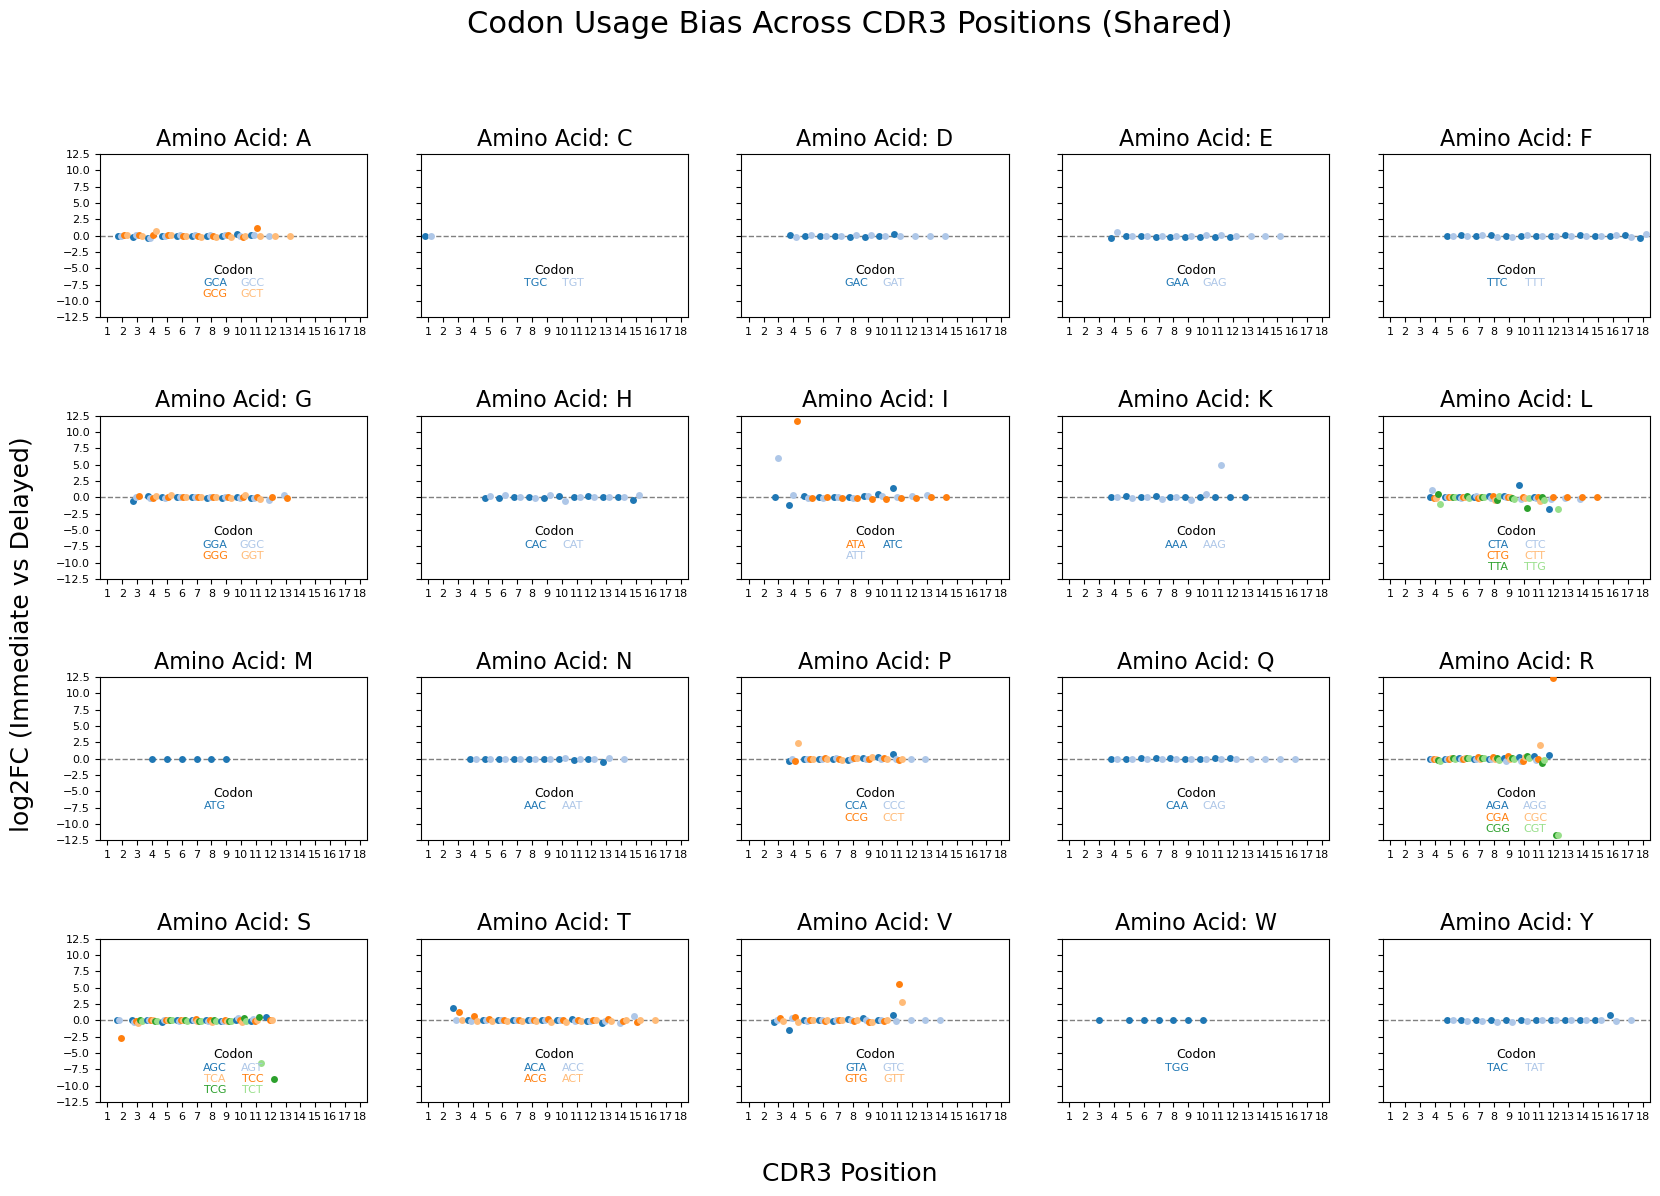

In [27]:
plot_codon_usage_bias_grid(codon_pivot_shared, -12.5, 12.5, "Shared")


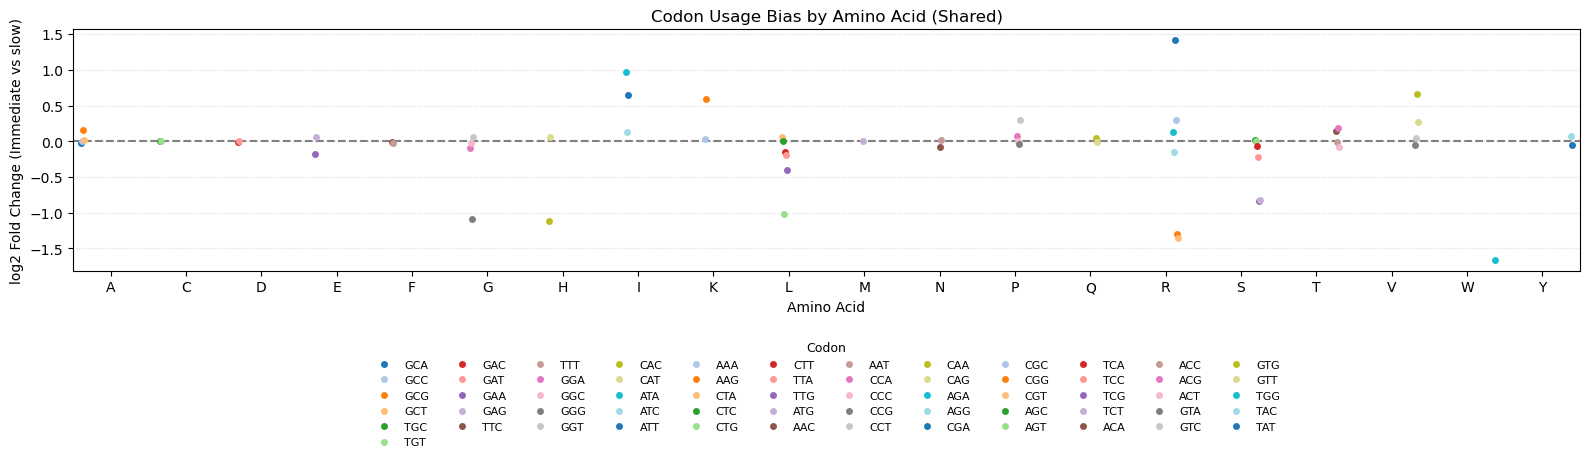

In [28]:
plot_codon_bias_by_aa(codon_pivot_shared, "Shared")

For unique-fast and unique-slow repertoires, instead of comparing codon bias between groups, we should quantify within-group convergent recombination:
How many different nucleotide realizations give rise to the same amino-acid CDR3, and how are they distributed across positions?

In [29]:
df_unique_fast = clonotype_df_down[
    (clonotype_df_down["aaSeqCDR3"].isin(unique_fast_set_std)) &
    (clonotype_df_down["group"] == "fast") &
    (clonotype_df_down["ds_reads"] >= THRESH)
].copy()

df_unique_slow = clonotype_df_down[
    (clonotype_df_down["aaSeqCDR3"].isin(unique_slow_set_std)) &
    (clonotype_df_down["group"] == "slow") &
    (clonotype_df_down["ds_reads"] >= THRESH)
].copy()

print("unique_fast AAs:", df_unique_fast["aaSeqCDR3"].nunique())
print("unique_slow AAs:", df_unique_slow["aaSeqCDR3"].nunique())


unique_fast AAs: 14716
unique_slow AAs: 4057


In [30]:
def get_unique_aa_nt_universe(df, aa_col="aaSeqCDR3", nt_col="nSeqCDR3"):
    """
    Universe = unique (AA, nt) pairs.
    Filters out length-mismatches (nt must be 3*aa).
    """
    u = df[[aa_col, nt_col]].dropna().drop_duplicates().copy()
    m = u[nt_col].str.len().astype(int) == u[aa_col].str.len().astype(int) * 3
    return u[m].copy()

def explode_codons_universe(universe_df, aa_col="aaSeqCDR3", nt_col="nSeqCDR3"):
    """
    Returns per-position codon records: AA, Position (1-based), Codon.
    """
    aa_seqs = universe_df[aa_col].tolist()
    nt_seqs = universe_df[nt_col].tolist()

    records = [
        {"AA": aa[i], "Position": i + 1, "Codon": nt[i*3:(i+1)*3]}
        for aa, nt in zip(aa_seqs, nt_seqs)
        for i in range(len(aa))
    ]
    return pd.DataFrame(records)

def codon_entropy_by_position(codon_df):
    """
    Shannon entropy (base 2) of codon distribution at each CDR3 position.
    Higher = more codon diversity at that position.
    """
    counts = codon_df.groupby(["Position", "Codon"]).size().reset_index(name="count")
    counts["p"] = counts["count"] / counts.groupby("Position")["count"].transform("sum")

    ent = (
        counts.groupby("Position")["p"]
        .apply(lambda p: -(p * np.log2(p)).sum())
        .reset_index(name="codon_entropy")
    )
    return ent

def plot_position_entropy(ent_fast, ent_slow, title="Position-wise codon entropy"):
    plt.figure(figsize=(8, 4))
    plt.plot(ent_fast["Position"], ent_fast["codon_entropy"], marker="o", label="fast")
    plt.plot(ent_slow["Position"], ent_slow["codon_entropy"], marker="o", label="slow")
    plt.xlabel("CDR3 position")
    plt.ylabel("Codon entropy (bits)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

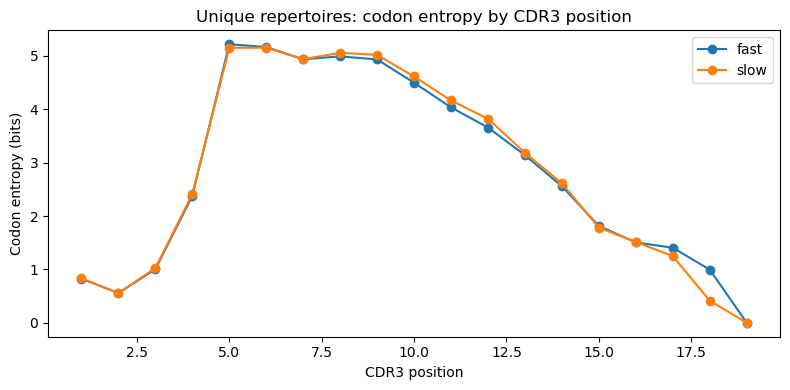

In [31]:
# Build universe + explode for each group
uni_fast = get_unique_aa_nt_universe(df_unique_fast)
uni_slow = get_unique_aa_nt_universe(df_unique_slow)

codons_fast = explode_codons_universe(uni_fast)
codons_slow = explode_codons_universe(uni_slow)

# Entropy + plot
ent_fast = codon_entropy_by_position(codons_fast)
ent_slow = codon_entropy_by_position(codons_slow)

plot_position_entropy(ent_fast, ent_slow, title="Unique repertoires: codon entropy by CDR3 position")


In [152]:
AA_TO_CODONS = {
    "A": ["GCT","GCC","GCA","GCG"],
    "C": ["TGT","TGC"],
    "D": ["GAT","GAC"],
    "E": ["GAA","GAG"],
    "F": ["TTT","TTC"],
    "G": ["GGT","GGC","GGA","GGG"],
    "H": ["CAT","CAC"],
    "I": ["ATT","ATC","ATA"],
    "K": ["AAA","AAG"],
    "L": ["TTA","TTG","CTT","CTC","CTA","CTG"],
    "M": ["ATG"],
    "N": ["AAT","AAC"],
    "P": ["CCT","CCC","CCA","CCG"],
    "Q": ["CAA","CAG"],
    "R": ["CGT","CGC","CGA","CGG","AGA","AGG"],
    "S": ["TCT","TCC","TCA","TCG","AGT","AGC"],
    "T": ["ACT","ACC","ACA","ACG"],
    "V": ["GTT","GTC","GTA","GTG"],
    "W": ["TGG"],
    "Y": ["TAT","TAC"],
}
AA_ORDER = list("ACDEFGHIKLMNPQRSTVWY")


def get_unique_aa_nt_universe(df, aa_col="aaSeqCDR3", nt_col="nSeqCDR3"):
    u = df[[aa_col, nt_col]].dropna().drop_duplicates().copy()
    m = u[nt_col].str.len().astype(int) == u[aa_col].str.len().astype(int) * 3
    return u[m].copy()

def explode_codons_universe(universe_df, aa_col="aaSeqCDR3", nt_col="nSeqCDR3"):
    aa_seqs = universe_df[aa_col].tolist()
    nt_seqs = universe_df[nt_col].tolist()
    records = [
        {"AA": aa[i], "Position": i + 1, "Codon": nt[i*3:(i+1)*3]}
        for aa, nt in zip(aa_seqs, nt_seqs)
        for i in range(len(aa))
    ]
    return pd.DataFrame(records)

def codon_fraction_by_AA_position(df_group):
    """
    Returns a dataframe with columns: AA, Position, Codon, fraction
    where fraction is normalized within each (AA, Position).
    Universe = unique (aaSeqCDR3, nSeqCDR3) pairs.
    """
    uni = get_unique_aa_nt_universe(df_group)
    codon_df = explode_codons_universe(uni)

    counts = (
        codon_df.groupby(["AA", "Position", "Codon"])
        .size()
        .reset_index(name="count")
    )
    counts["fraction"] = counts["count"] / counts.groupby(["AA", "Position"])["count"].transform("sum")
    return counts


def plot_codon_composition_grid_paired(
    df_fast,
    df_slow,
    global_positios,
    title="Codon composition by AA and CDR3 position (paired)",
    aa_order=AA_ORDER,
    aa_to_codons=AA_TO_CODONS,
    n_cols=5,
    figsize=(20, 12),
    show_legend=True,
    legend_space=2.2,
    out_svg=None,
):
    frac_fast = codon_fraction_by_AA_position(df_fast)
    frac_slow = codon_fraction_by_AA_position(df_slow)

    n_aa = len(aa_order)
    blocks = int(np.ceil(n_aa / n_cols))
    n_rows = blocks * 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)
    axes = np.array(axes)

    def draw_panel(ax, sub_frac, aa, positions, codons, grey=False, hide_xticklabels=False):
        mat = (
            sub_frac[sub_frac["AA"] == aa]
            .pivot_table(index="Position", columns="Codon", values="fraction", fill_value=0)
            .reindex(index=positions, columns=codons, fill_value=0)
        )

        bottoms = np.zeros(len(positions), dtype=float)
        for codon in codons:
            vals = mat[codon].to_numpy()
            if grey:
                ax.bar(positions, vals, bottom=bottoms, width=0.85, color="0.7", label=codon)
            else:
                ax.bar(positions, vals, bottom=bottoms, width=0.85, label=codon)
            bottoms += vals

        ax.set_ylim(0, 1.0)

        ax.set_xticks(positions)
        ax.tick_params(axis="x", labelrotation=90, labelsize=7)
        ax.tick_params(axis="y", labelsize=8)

        if hide_xticklabels:
            ax.tick_params(axis="x", labelbottom=False)

        # legend gutter on the right
        ax.set_xlim(positions.min() - 0.6, positions.max() + 0.6)

    for i, aa in enumerate(aa_order):
        block = i // n_cols
        col = i % n_cols
        ax_fast = axes[block * 2, col]
        ax_slow = axes[block * 2 + 1, col]

        codons = aa_to_codons[aa]
        is_single = (len(codons) == 1)

        pos_fast = frac_fast.loc[frac_fast["AA"] == aa, "Position"]
        pos_slow = frac_slow.loc[frac_slow["AA"] == aa, "Position"]

        if pos_fast.empty and pos_slow.empty:
            ax_fast.axis("off")
            ax_slow.axis("off")
            continue

        positions = global_positios

        title_color = "0.4" if is_single else "black"

        # Add padding so the AA title sits a bit higher and doesn't collide
        ax_fast.set_title(aa, fontsize=12, fontweight="bold", color=title_color, pad=8)

        draw_panel(ax_fast, frac_fast, aa, positions, codons, grey=is_single, hide_xticklabels=True)
        draw_panel(ax_slow, frac_slow, aa, positions, codons, grey=is_single, hide_xticklabels=False)

        # legend once per AA: on slow axis, in gutter
        if show_legend and (not is_single):
            ax_slow.legend(title="Codon", fontsize=8, title_fontsize=9, loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False,
                            handlelength=1.1, borderaxespad=0.0, labelspacing=0.25,)

    # turn off unused axes
    total_cells = n_rows * n_cols
    used_cells = blocks * n_cols * 2
    for idx in range(used_cells, total_cells):
        r = idx // n_cols
        c = idx % n_cols
        axes[r, c].axis("off")

    fig.suptitle(title, fontsize=22, fontweight="normal", y=0.94)
    fig.text(0.5, 0.04, "CDR3 position", ha="center", fontsize=16)
    fig.text(0.01, 0.5, "Relative codon proportion within (AA, position)", va="center", rotation="vertical", fontsize=16)

    # tight_layout first, then add extra vertical spacing
    plt.tight_layout(rect=[0.08, 0.06, 1, 0.95])
    fig.subplots_adjust(wspace=0.35, hspace=0.70) 

    # add row labels "Fast"/"Slow" on the left margin
    # Place the label centered on each row using axes positions
    for r in range(n_rows):
        # skip if the whole row is off (rare, but safe)
        if all(axes[r, c].axison is False for c in range(n_cols)):
            continue
        bbox = axes[r, 0].get_position()
        y_center = (bbox.y0 + bbox.y1) / 2 + 0.02
        fig.text(
            0.085, y_center,                 
            "Immediate" if (r % 2 == 0) else "Delayed",
            ha="right", va="center", rotation=45,
            fontsize=13, fontweight="normal", rotation_mode="anchor",
        )
    if out_svg is not None:
        save_plot(out_svg, format="svg", bbox_inches="tight")
    
    plt.show()
    return frac_fast, frac_slow


In [33]:
df_shared_fast = df_shared_diff_nt[df_shared_diff_nt["group"] == "fast"].copy()
df_shared_slow = df_shared_diff_nt[df_shared_diff_nt["group"] == "slow"].copy()

In [34]:
# global max CDR3 position across all datasets
global_max_pos = max(
    df_shared_fast["aaSeqCDR3"].str.len().max(),
    df_shared_slow["aaSeqCDR3"].str.len().max(),
    df_unique_fast["aaSeqCDR3"].str.len().max(),
    df_unique_slow["aaSeqCDR3"].str.len().max(),
)

global_positions = np.arange(1, global_max_pos + 1)

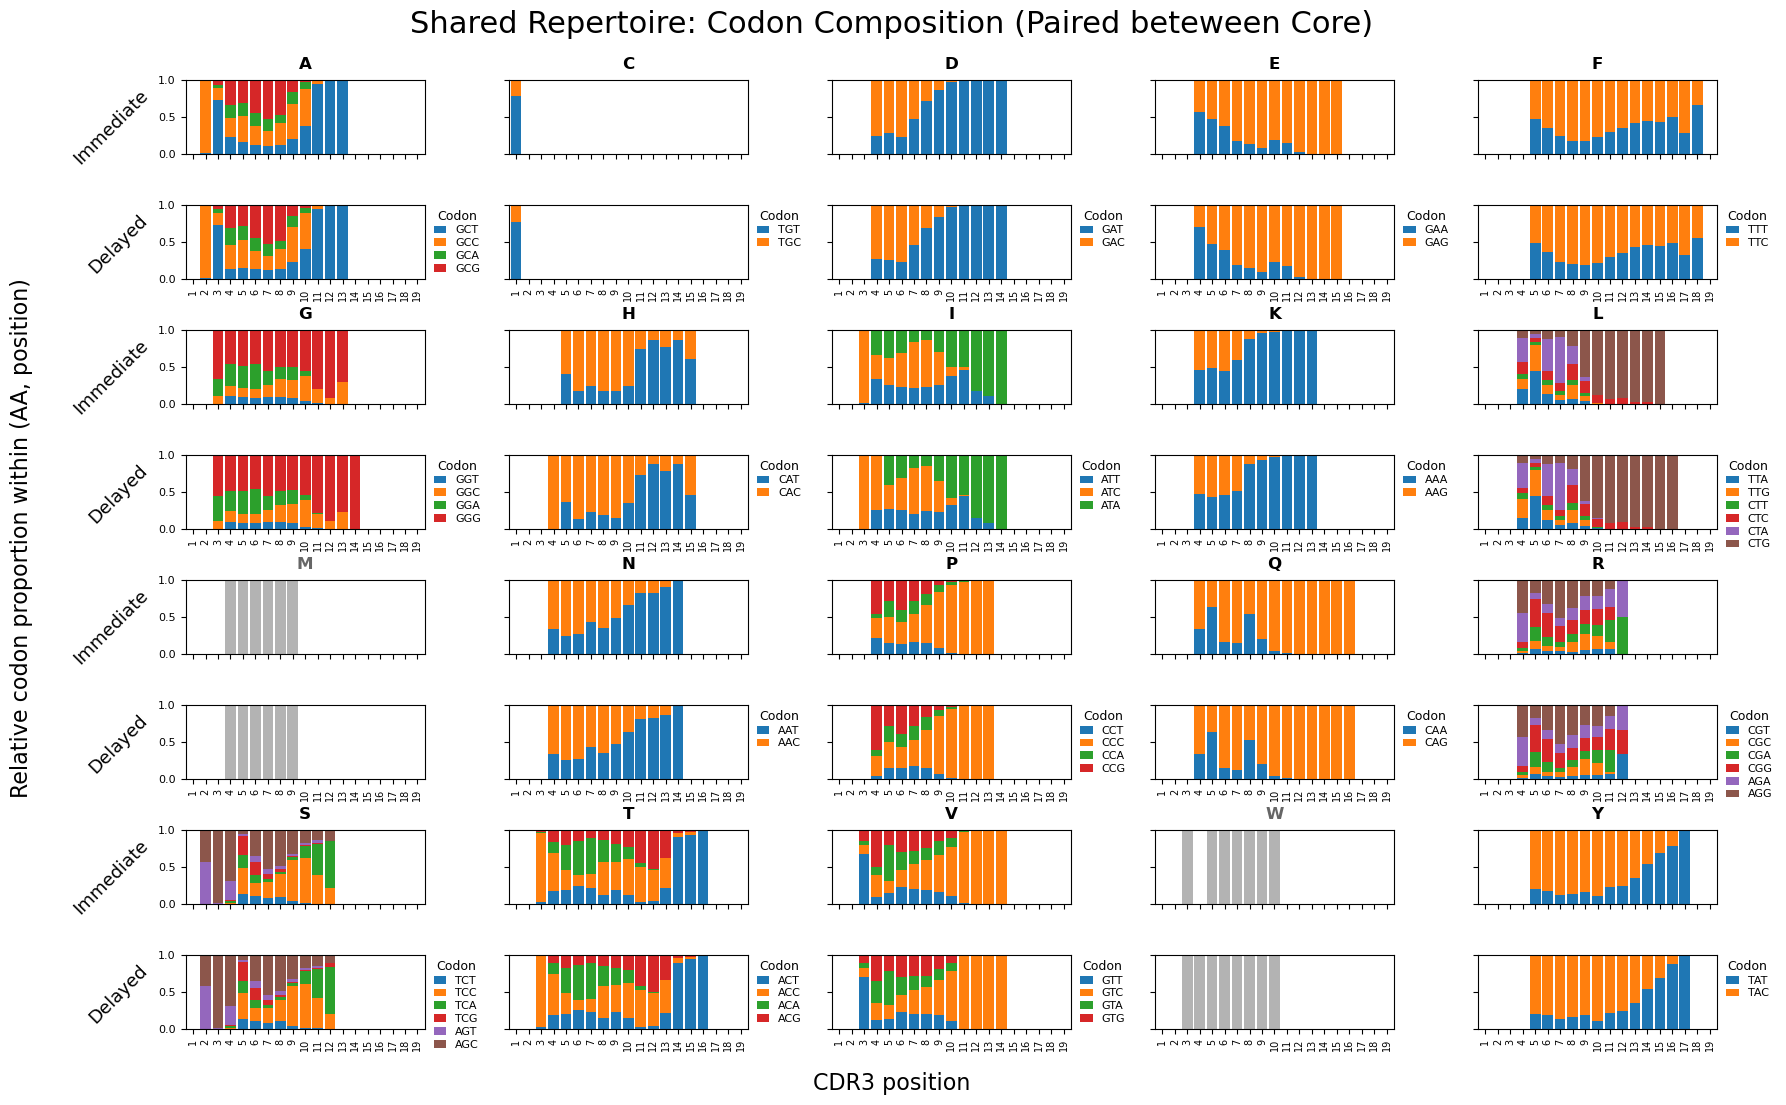

In [153]:
frac_fast_shared, frac_slow_shared = plot_codon_composition_grid_paired(
    df_fast=df_shared_fast,
    df_slow=df_shared_slow,
    global_positios=global_positions,
    title="Shared Repertoire: Codon Composition (Paired beteween Core)",
    n_cols=5,
    figsize=(18, 12),
    show_legend=True,
    out_svg="../colon/codon_bias_composition_core.svg"
)

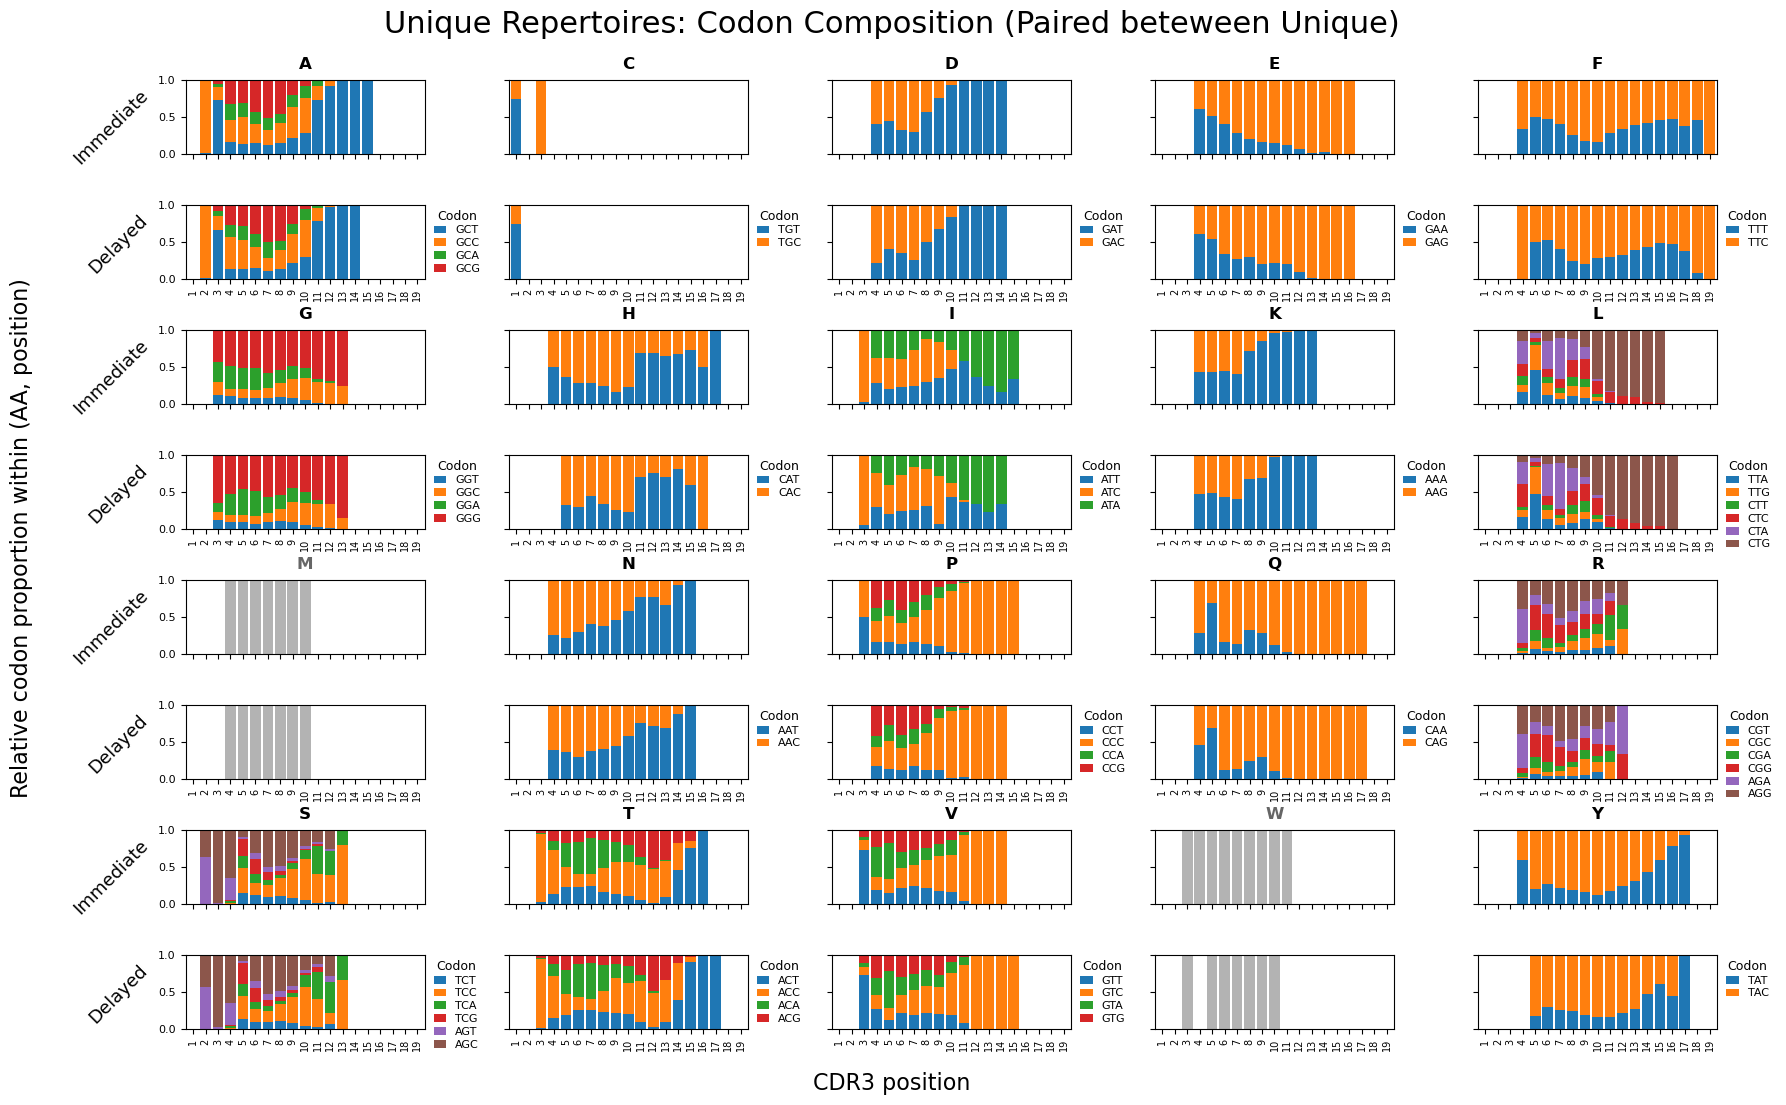

In [154]:
frac_fast, frac_slow = plot_codon_composition_grid_paired(
    df_fast=df_unique_fast,
    df_slow=df_unique_slow,
    global_positios=global_positions,
    title="Unique Repertoires: Codon Composition (Paired beteween Unique)",
    n_cols=5,
    figsize=(18, 12),
    show_legend=True,
    out_svg="../colon/codon_bias_composition_unique.svg"
)


#### New plots

In [164]:
def _safe_normalize(vec: np.ndarray) -> np.ndarray:
    s = float(np.sum(vec))
    if s <= 0:
        return np.zeros_like(vec, dtype=float)
    return vec / s

def _js_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
    """
    Jensen–Shannon divergence (base-2), bounded in [0, 1].
    Safe for zeros via eps-smoothing + renormalization.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    p = _safe_normalize(p + eps)
    q = _safe_normalize(q + eps)
    m = 0.5 * (p + q)

    def kl(a, b):
        return float(np.sum(a * np.log2(a / b)))

    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

def _shannon_entropy(p: np.ndarray, eps: float = 1e-12) -> float:
    """Shannon entropy (base-e); safe for zeros via eps."""
    p = np.asarray(p, dtype=float)
    p = _safe_normalize(p + eps)
    return float(-np.sum(p * np.log(p)))

def effective_num_codons(p: np.ndarray, eps: float = 1e-12) -> float:
    """Effective number of codons = exp(H)."""
    return float(np.exp(_shannon_entropy(p, eps=eps)))


# Δ-fraction table from two fraction dfs
def build_delta_fraction_table(
    frac_fast: pd.DataFrame,
    frac_slow: pd.DataFrame,
    aa_to_codons: dict,
    aa_order=AA_ORDER,
) -> pd.DataFrame:
    """
    frac_* expected columns: AA, Position, Codon, fraction
    Returns long df with columns:
      AA, Position, Codon, frac_fast, frac_slow, delta
    Only includes codons valid for that AA.
    """
    # Keep only relevant columns
    f = frac_fast[["AA", "Position", "Codon", "fraction"]].rename(columns={"fraction": "frac_fast"})
    s = frac_slow[["AA", "Position", "Codon", "fraction"]].rename(columns={"fraction": "frac_slow"})

    merged = pd.merge(f, s, on=["AA", "Position", "Codon"], how="outer")
    merged["frac_fast"] = merged["frac_fast"].fillna(0.0)
    merged["frac_slow"] = merged["frac_slow"].fillna(0.0)

    # Filter to AA-specific codons only
    valid_rows = []
    for aa in aa_order:
        codons = set(aa_to_codons[aa])
        sub = merged[merged["AA"] == aa].copy()
        sub = sub[sub["Codon"].isin(codons)]
        valid_rows.append(sub)
    merged = pd.concat(valid_rows, ignore_index=True)

    merged["delta"] = merged["frac_fast"] - merged["frac_slow"]
    merged["Position"] = pd.to_numeric(merged["Position"], errors="coerce").astype("Int64")
    merged = merged.dropna(subset=["AA", "Position", "Codon"]).copy()
    merged["Position"] = merged["Position"].astype(int)

    return merged


# Δ-heatmap grid (AA facets), global color scale
def plot_delta_fraction_heatmap_grid(
    delta_df: pd.DataFrame,
    title: str,
    aa_to_codons: dict = AA_TO_CODONS,
    aa_order=AA_ORDER,
    n_cols: int = 5,
    figsize=(20, 12),
    cmap: str = "coolwarm",
    show_colorbar: bool = True,
):
    """
    Faceted heatmap by AA:
      x = CDR3 position
      y = codon (AA-specific)
      color = Δfraction = fast - slow

    Uses GLOBAL symmetric vlim across all AAs within this delta_df.
    """
    n_aa = len(aa_order)
    n_rows = int(np.ceil(n_aa / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    axes = np.array(axes).reshape(n_rows, n_cols)

    # Global symmetric limits
    if delta_df.empty:
        raise ValueError("delta_df is empty. Check inputs.")
    vmax = float(np.nanmax(np.abs(delta_df["delta"].to_numpy())))
    vmax = max(vmax, 1e-6)
    vmin = -vmax

    last_im = None

    for i, aa in enumerate(aa_order):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r, c]

        codons = aa_to_codons[aa]
        sub = delta_df[delta_df["AA"] == aa]
        if sub.empty:
            ax.axis("off")
            continue

        pos_min = int(sub["Position"].min())
        pos_max = int(sub["Position"].max())
        positions = list(range(pos_min, pos_max + 1))

        mat = (
            sub.pivot_table(index="Codon", columns="Position", values="delta", fill_value=0.0)
            .reindex(index=codons, columns=positions, fill_value=0.0)
        )

        # image: codon rows, position columns
        last_im = ax.imshow(mat.to_numpy(),aspect="auto",interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax,)
        ax.set_title(aa, fontsize=11, fontweight="bold", pad=6)
        ax.set_xticks(np.arange(len(positions)))
        ax.set_xticklabels([str(p) for p in positions], rotation=90, fontsize=7)

        ax.set_yticks(np.arange(len(codons)))
        ax.set_yticklabels(codons, fontsize=7)

        # thin gridlines help reading
        ax.set_xticks(np.arange(-0.5, len(positions), 1), minor=True)
        ax.set_yticks(np.arange(-0.5, len(codons), 1), minor=True)
        ax.grid(which="minor", linewidth=0.3)
        ax.tick_params(which="minor", bottom=False, left=False)

    # turn off unused axes
    for j in range(n_aa, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axes[r, c].axis("off")

    fig.suptitle(title, fontsize=14, fontweight="bold")
    fig.text(0.5, 0.04, "CDR3 position", ha="center", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.5, "Codon (within AA)", va="center", rotation="vertical", fontsize=14, fontweight="bold")

    if show_colorbar and last_im is not None:
        # one shared colorbar
        # create a dedicated colorbar axis on the right
        cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(last_im, cax=cax)
        cbar.set_label("Δfraction (Fast − Slow)", fontsize=12)

    plt.tight_layout(rect=[0.04, 0.06, 0.90, 0.93])
    plt.show()


# Collapse and compare (Shared vs Unique):
#    (i) Effective codon # per (AA, Position) per group
#    (ii) JS divergence between Fast and Slow per (AA, Position)
def _codon_vector_for_aa_pos(frac_df: pd.DataFrame, aa: str, pos: int, codons: list) -> np.ndarray:
    sub = frac_df[(frac_df["AA"] == aa) & (frac_df["Position"] == pos)]
    if sub.empty:
        return np.zeros(len(codons), dtype=float)
    v = np.zeros(len(codons), dtype=float)
    m = {c: float(f) for c, f in zip(sub["Codon"].tolist(), sub["fraction"].tolist())}
    for i, c in enumerate(codons):
        v[i] = m.get(c, 0.0)
    return _safe_normalize(v)


def collapse_metrics_by_aa_pos(
    frac_fast: pd.DataFrame,
    frac_slow: pd.DataFrame,
    label: str,
    aa_to_codons: dict = AA_TO_CODONS,
    aa_order=AA_ORDER,
) -> pd.DataFrame:
    """
    Returns df with rows per (AA, Position) containing:
      label, AA, Position, eff_codons_fast, eff_codons_slow, js_fast_slow
    """
    rows = []
    for aa in aa_order:
        codons = aa_to_codons[aa]
        # union of positions present in either fast/slow for this AA
        pos_f = frac_fast.loc[frac_fast["AA"] == aa, "Position"]
        pos_s = frac_slow.loc[frac_slow["AA"] == aa, "Position"]
        if pos_f.empty and pos_s.empty:
            continue
        pos_min = int(min(pos_f.min() if not pos_f.empty else np.inf,
                          pos_s.min() if not pos_s.empty else np.inf))
        pos_max = int(max(pos_f.max() if not pos_f.empty else -np.inf,
                          pos_s.max() if not pos_s.empty else -np.inf))
        for pos in range(pos_min, pos_max + 1):
            p = _codon_vector_for_aa_pos(frac_fast, aa, pos, codons)
            q = _codon_vector_for_aa_pos(frac_slow, aa, pos, codons)

            rows.append({
                "set": label,
                "AA": aa,
                "Position": pos,
                "eff_codons_fast": effective_num_codons(p),
                "eff_codons_slow": effective_num_codons(q),
                "js_fast_slow": _js_divergence(p, q),
            })

    out = pd.DataFrame(rows)
    return out


def mask_below_threshold(mat: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """Return a copy of mat where values < threshold are NaN (for masking in imshow)."""
    if threshold is None:
        return mat
    out = mat.copy()
    out[out < threshold] = np.nan
    return out


def plot_effective_codons_shared_vs_unique(
    metrics_df: pd.DataFrame,
    value_col: str,  
    title_prefix: str = "Effective codons: Shared vs Unique",
    aa_order=AA_ORDER,
    figsize=(18, 3.8),
    global_positions: list[int] | None = None,
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = np.array(axes)

    def heat(ax, sub, title):
        mat = sub.pivot_table(index="AA", columns="Position", values=value_col, aggfunc="mean")
        mat = mat.reindex(index=aa_order)
        if global_positions is not None:
            mat = mat.reindex(columns=global_positions)

        im = ax.imshow(mat.to_numpy(), aspect="auto", interpolation="nearest")
        ax.set_title(title, fontsize=12, fontweight="bold")

        ax.set_yticks(np.arange(len(mat.index)))
        ax.set_yticklabels(mat.index.tolist(), fontsize=8)

        positions = mat.columns.tolist() 
        ax.set_xticks(np.arange(len(positions)))
        ax.set_xticklabels([str(p) for p in positions], rotation=90, fontsize=7)
        return im

    sub_shared = metrics_df[metrics_df["set"] == "Shared"].copy()
    sub_unique = metrics_df[metrics_df["set"] == "Unique"].copy()

    im1 = heat(axes[0], sub_shared, f"{value_col} — Shared")
    im2 = heat(axes[1], sub_unique, f"{value_col} — Unique")

    # single shared colorbar on right
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.60])
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label("Effective number of codons (exp(H))", fontsize=11)

    fig.suptitle(title_prefix, fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0.02, 0.02, 0.90, 0.90])
    plt.show()


def plot_js_divergence_shared_vs_unique(
    metrics_df: pd.DataFrame,
    js_col: str = "js_fast_slow",
    title_prefix: str = "JS divergence (Immediate vs Delayed)",
    aa_order=AA_ORDER,
    figsize=(18, 3.8),
    js_threshold: float | None = None,   
    vmax: float | None = None,           
    global_positions: list[int] | None = None,
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = np.array(axes)

    def heat(ax, sub, title):
        mat = sub.pivot_table(index="AA", columns="Position", values=js_col, aggfunc="mean")
        mat = mat.reindex(index=aa_order)
        if global_positions is not None:
            mat = mat.reindex(columns=global_positions)

        mat_masked = mask_below_threshold(mat, js_threshold)

        # choose vmax: either user-specified or computed from visible (non-NaN) values
        local_vmax = vmax
        if local_vmax is None:
            vals = mat_masked.to_numpy().ravel()
            vals = vals[~np.isnan(vals)]
            local_vmax = float(np.nanmax(vals)) if vals.size else 1e-6

        im = ax.imshow(
            mat_masked.to_numpy(),
            aspect="auto",
            interpolation="nearest",
            vmin=js_threshold if js_threshold is not None else 0.0,
            vmax=local_vmax,
        )

        ax.set_title(title, fontsize=16)

        ax.set_yticks(np.arange(len(mat.index)))
        ax.set_yticklabels(mat.index.tolist(), fontsize=9)

        positions = mat.columns.tolist()
        ax.set_xticks(np.arange(len(positions)))
        ax.set_xticklabels([str(p) for p in positions], fontsize=9)
        return im

    sub_shared = metrics_df[metrics_df["set"] == "Shared"].copy()
    sub_unique = metrics_df[metrics_df["set"] == "Unique"].copy()

    im1 = heat(axes[0], sub_shared, "JS divergence — Core")
    im2 = heat(axes[1], sub_unique, "JS divergence — Unique")

    # single shared colorbar on right
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.60])
    cbar = fig.colorbar(im1, cax=cax)
    lbl = "Jensen–Shannon divergence"
    if js_threshold is not None:
        lbl += f"\n (base-2; masked < {js_threshold})"
    cbar.set_label(lbl, fontsize=14)

    fig.suptitle(title_prefix, fontsize=22, y=0.92)
    plt.tight_layout(rect=[0.02, 0.02, 0.90, 0.90])
    save_plot("../colon/js_divergence.svg", format="svg")
    plt.show()


In [38]:
# Fractions
frac_shared_fast = codon_fraction_by_AA_position(df_shared_fast)
frac_shared_slow = codon_fraction_by_AA_position(df_shared_slow)
frac_unique_fast = codon_fraction_by_AA_position(df_unique_fast)
frac_unique_slow = codon_fraction_by_AA_position(df_unique_slow)

# Δfraction tables
delta_shared = build_delta_fraction_table(frac_shared_fast, frac_shared_slow, aa_to_codons=AA_TO_CODONS, aa_order=AA_ORDER)
delta_unique = build_delta_fraction_table(frac_unique_fast, frac_unique_slow, aa_to_codons=AA_TO_CODONS, aa_order=AA_ORDER)


/tmp/ipykernel_501051/957031836.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.06, 0.90, 0.93])


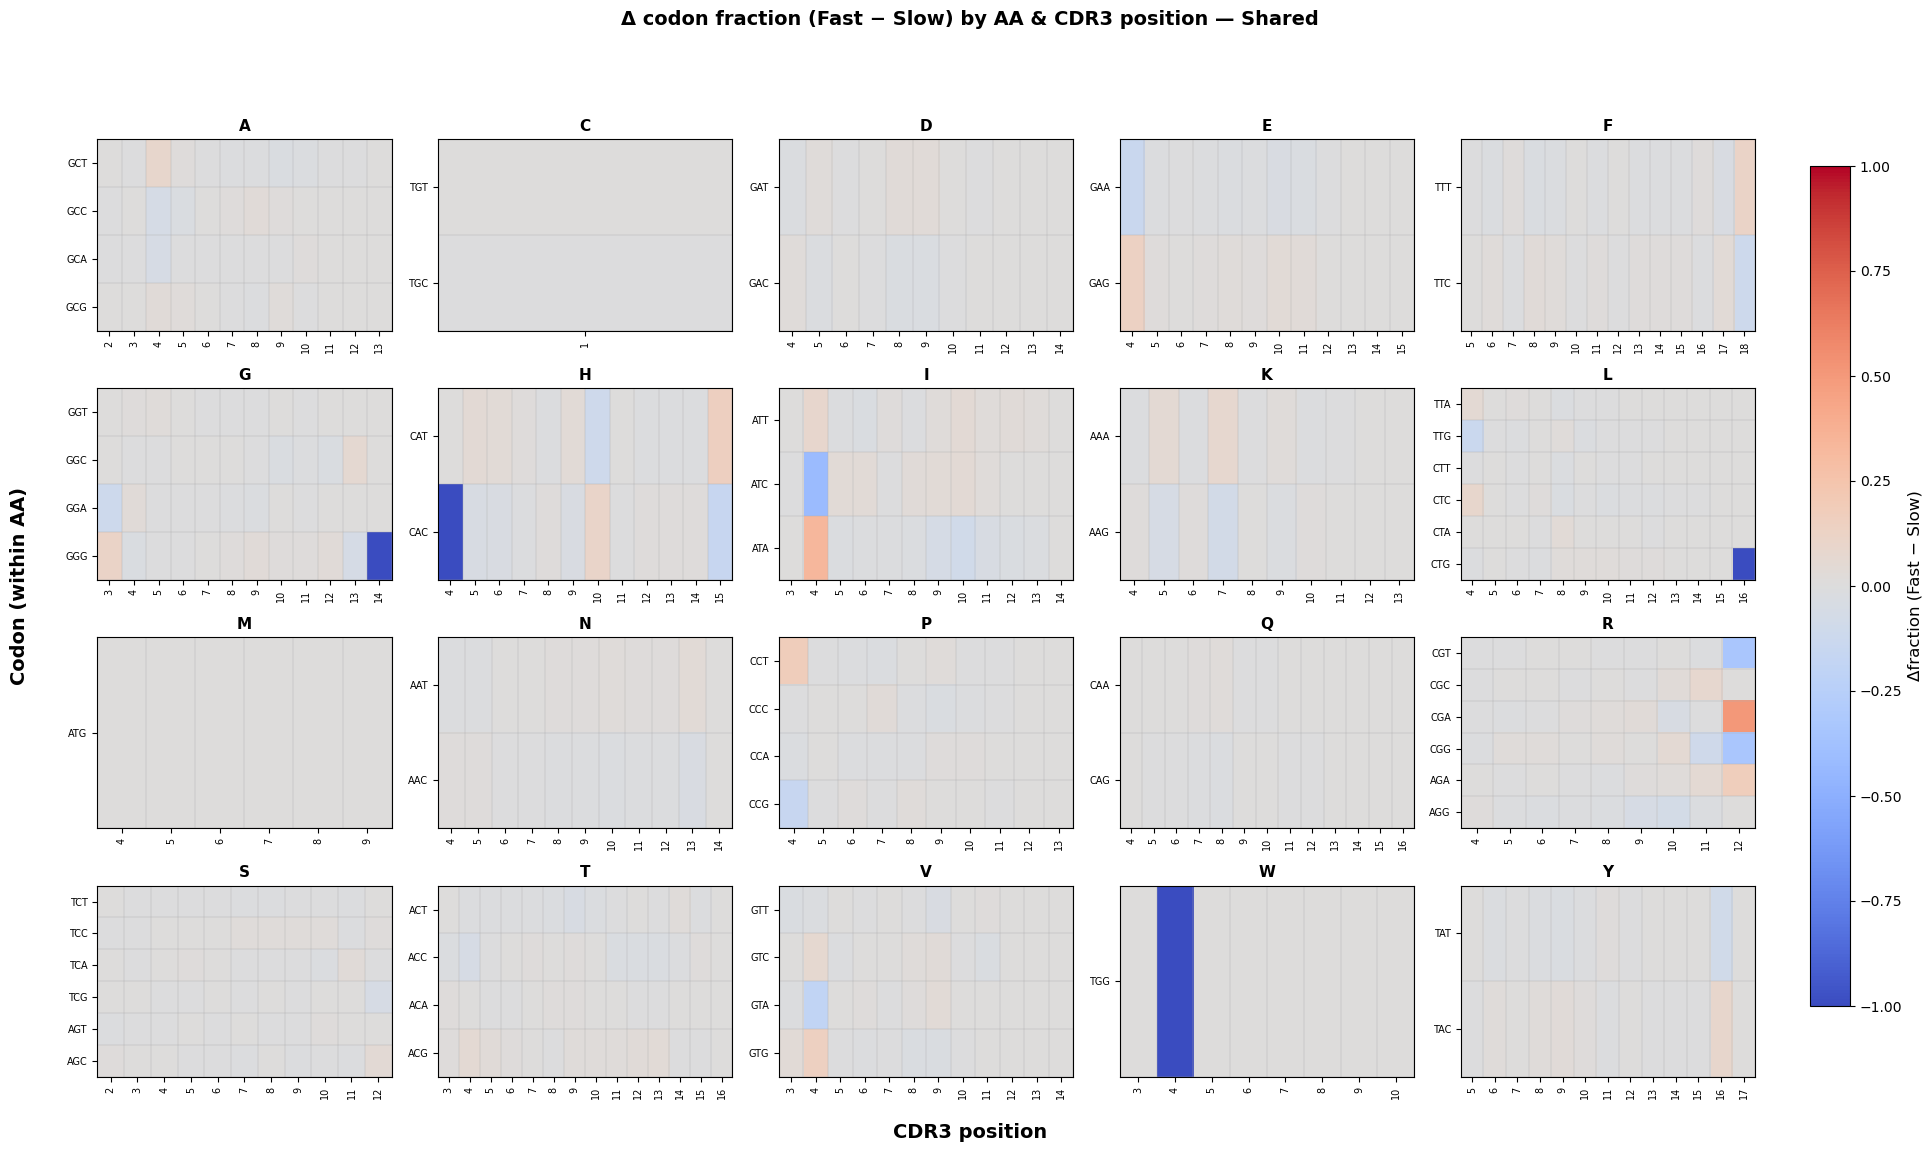

In [39]:
# Δ-heatmaps
plot_delta_fraction_heatmap_grid(
    delta_shared,
    title="Δ codon fraction (Fast − Slow) by AA & CDR3 position — Shared",
    aa_to_codons=AA_TO_CODONS,
    aa_order=AA_ORDER,
    n_cols=5,
    figsize=(20, 12),
    cmap="coolwarm",
    show_colorbar=True,
)


/tmp/ipykernel_501051/957031836.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.06, 0.90, 0.93])


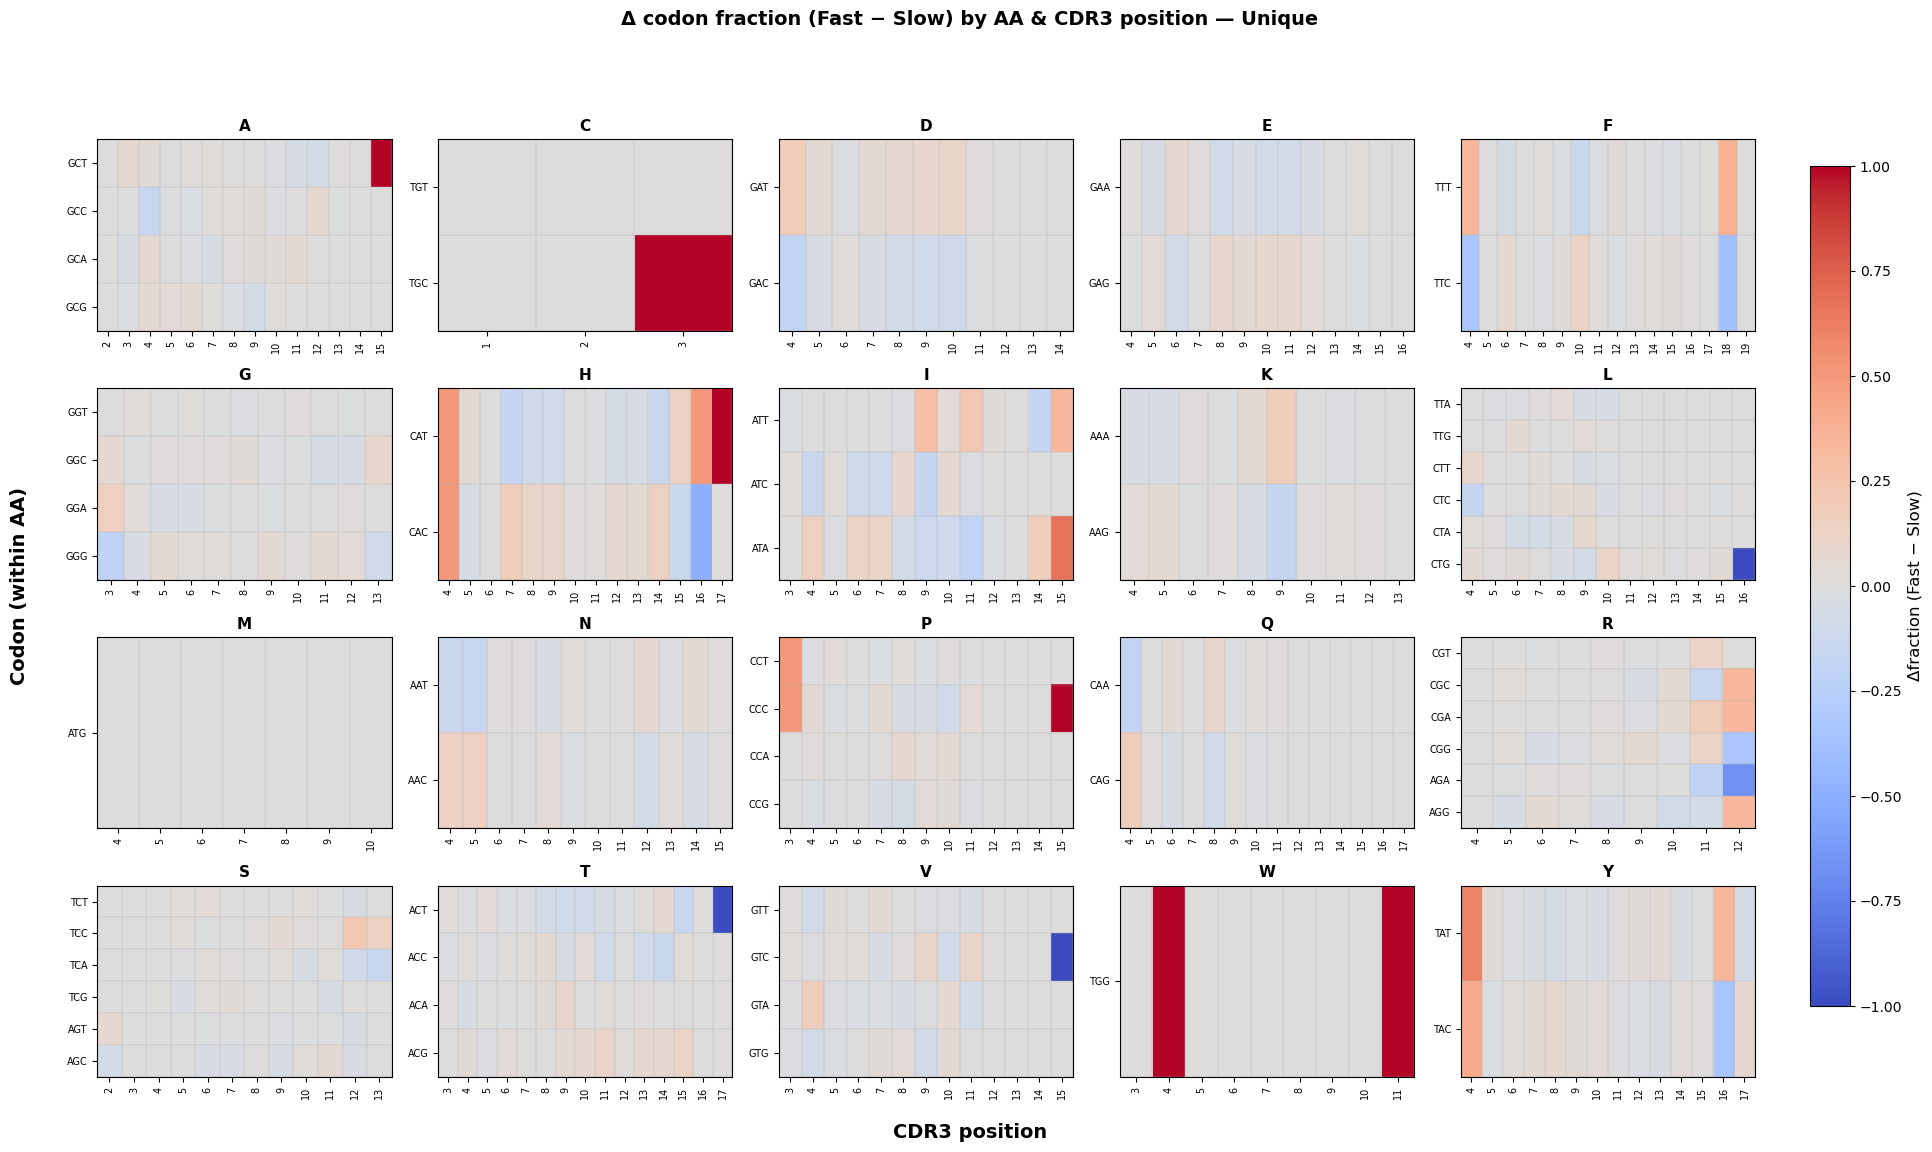

In [40]:
plot_delta_fraction_heatmap_grid(
    delta_unique,
    title="Δ codon fraction (Fast − Slow) by AA & CDR3 position — Unique",
    aa_to_codons=AA_TO_CODONS,
    aa_order=AA_ORDER,
    n_cols=5,
    figsize=(20, 12),
    cmap="coolwarm",
    show_colorbar=True,
)


Codon usage summary metrics

This analysis uses two complementary metrics to characterize synonymous codon usage at each  
(amino acid, CDR3 position) combination.

1) Effective number of codons (constraint metric)
The effective number of codons quantifies how uniformly synonymous codons are used at a given
amino-acid position. It is derived from Shannon entropy of the codon distribution:

- Low values (~1): strong constraint; usage dominated by one (or very few) codons  
- High values (approaching the number of synonymous codons): uniform codon usage  

This metric reflects **codon usage constraint**, but does **not** indicate which specific codon
is preferred, nor does it compare Fast and Slow directly.

2) Jensen–Shannon (JS) divergence (difference metric)
JS divergence quantifies how different the synonymous codon usage distributions are between
Fast and Slow at the same amino-acid position.

- JS = 0: identical codon usage  
- Higher JS values: increasing divergence in codon preference  

JS divergence is computed from the **full codon probability distributions** (not from entropy
or effective codon numbers) and directly captures **Fast vs Slow codon preference differences**.

Interpretation
- Effective codons answer: *How constrained is codon usage here?*  
- JS divergence answers: *Do Fast and Slow prefer different codons here?*

Together, these metrics separate **positional constraint** from **group-specific codon bias**.


In [43]:

# Collapse and compare (between figures): Effective codons + JS divergence heatmaps
metrics_shared = collapse_metrics_by_aa_pos(frac_shared_fast, frac_shared_slow, label="Shared", aa_to_codons=AA_TO_CODONS, aa_order=AA_ORDER)
metrics_unique = collapse_metrics_by_aa_pos(frac_unique_fast, frac_unique_slow, label="Unique", aa_to_codons=AA_TO_CODONS, aa_order=AA_ORDER)
metrics_all = pd.concat([metrics_shared, metrics_unique], ignore_index=True)



/tmp/ipykernel_501051/2167984886.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.90, 0.90])


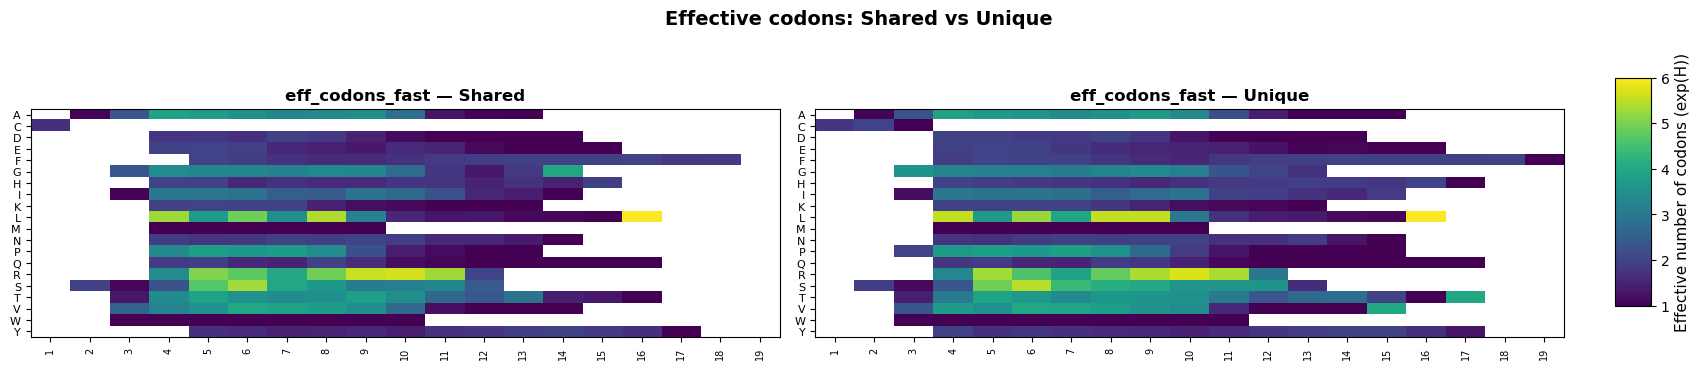

/tmp/ipykernel_501051/2167984886.py:330: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.90, 0.90])


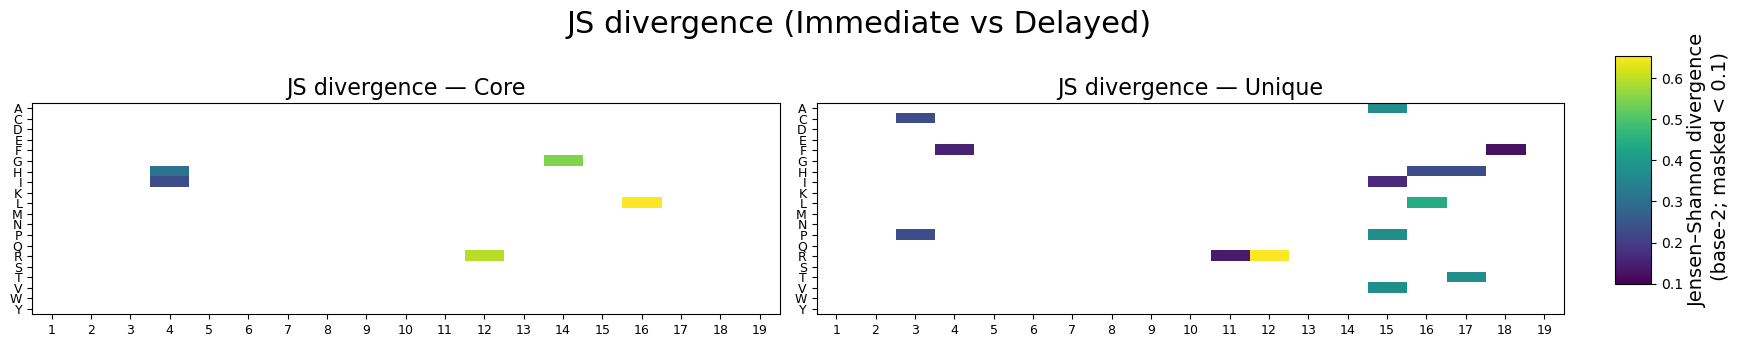

In [165]:
plot_effective_codons_shared_vs_unique(metrics_all, value_col="eff_codons_fast", global_positions=global_positions)

plot_js_divergence_shared_vs_unique(metrics_all, js_threshold=0.1, global_positions=global_positions)


In [42]:
(metrics_shared["eff_codons_fast"] - metrics_shared["eff_codons_slow"]).abs().describe()


count    216.000000
mean       0.096047
std        0.416566
min        0.000000
25%        0.002234
50%        0.020410
75%        0.059547
max        5.000000
dtype: float64

## BioChemical Properties

In [114]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Define Refined Metrics
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Define refined + added metrics
def analyze_sequence_refined(seq: str):
    keys = ["Length","Aromaticity","Isoelectric Point","Hydrophobicity GRAVY",
            "Charge pH7","Charged Fraction","Proline Fraction","Glycine Fraction",
            "AA Shannon Entropy"]
    try:
        seq = str(seq)
        L = len(seq)
        if L == 0:
            return {k: np.nan for k in keys}

        prot = ProteinAnalysis(seq)

        # simple composition-based features
        # ProteinAnalysis.get_amino_acids_percent() returns fractions summing to 1
        aa_frac = prot.amino_acids_percent

        # charged residue fraction: K,R,D,E
        charged_frac = (
            aa_frac.get("K", 0.0) + aa_frac.get("R", 0.0) +
            aa_frac.get("D", 0.0) + aa_frac.get("E", 0.0)
        )

        # Shannon entropy of AA composition (natural log)
        p = np.array(list(aa_frac.values()), dtype=float) / 100.0
        p = p[p > 0]
        aa_entropy = float(-(p * np.log(p)).sum()) if p.size else 0.0

        return {
            "Length": L,
            "Aromaticity": prot.aromaticity(),
            "Isoelectric Point": prot.isoelectric_point(),
            "Hydrophobicity GRAVY": prot.gravy(),
            "Charge pH7": prot.charge_at_pH(7.0),
            "Charged Fraction": charged_frac,
            "AA Shannon Entropy": aa_entropy,
        }

    except Exception:
        return {k: np.nan for k in keys}

def build_biochem_df(aa_list, label):
    # Analyze
    records = [analyze_sequence_refined(seq) for seq in aa_list]
    df = pd.DataFrame(records)
    df["Group"] = label
    # Add the sequence back for reference if needed
    df["aaSeqCDR3"] = list(aa_list)
    return df

THRESH = 3 

Lets try 2 way proccessing 

Notice: (if publicity threshold is the same in biochemical analysis as in codon frequencies) should expect different number of shared clonotypes from Codon frequences analysis, as we removed same_nt group from shared tcrs. 

In [115]:
from typing import Tuple, Dict, Set

def match_fast_to_slow_by_reads(
    clonotype_df: pd.DataFrame,
    read_col: str,
    group_col: str = "group",
    sample_col: str = "Sample_ID",
    fast_label: str = "fast",
    slow_label: str = "slow",
    match_on: str = "log",  # "log" or "raw"
) -> pd.DataFrame:
    """
    1-to-1 greedy matching: for each slow sample, pick the closest fast sample
    by (log) total reads, without replacement.

    Returns a dataframe with matched samples only (both groups kept).
    """
    req = {sample_col, group_col, read_col}
    missing = req - set(clonotype_df.columns)
    if missing:
        raise ValueError(f"clonotype_df missing columns: {missing}")

    # total reads per sample
    sample_reads = (
        clonotype_df.groupby([sample_col, group_col], as_index=False)[read_col]
        .sum()
        .rename(columns={read_col: "total_reads"})
    )

    slow = sample_reads[sample_reads[group_col] == slow_label].copy()
    fast = sample_reads[sample_reads[group_col] == fast_label].copy()

    if slow.empty or fast.empty:
        raise ValueError("One of the groups is empty after aggregating sample reads.")

    if match_on == "log":
        slow["m"] = np.log10(slow["total_reads"].clip(lower=1))
        fast["m"] = np.log10(fast["total_reads"].clip(lower=1))
    elif match_on == "raw":
        slow["m"] = slow["total_reads"]
        fast["m"] = fast["total_reads"]
    else:
        raise ValueError("match_on must be 'log' or 'raw'")

    # Greedy matching without replacement
    slow_sorted = slow.sort_values("m").reset_index(drop=True)
    fast_sorted = fast.sort_values("m").reset_index(drop=True)

    fast_vals = fast_sorted["m"].to_numpy()
    fast_ids = fast_sorted[sample_col].to_numpy()
    fast_used = np.zeros(len(fast_sorted), dtype=bool)

    matched_fast_ids = []
    for s_val in slow_sorted["m"].to_numpy():
        # find nearest available fast sample
        # start from insertion point, then expand outward until find unused
        idx = int(np.searchsorted(fast_vals, s_val, side="left"))
        left = idx - 1
        right = idx

        best_j = None
        best_dist = None

        while left >= 0 or right < len(fast_vals):
            candidates = []
            if left >= 0 and not fast_used[left]:
                candidates.append(left)
            if right < len(fast_vals) and not fast_used[right]:
                candidates.append(right)

            if candidates:
                # pick closest among candidates
                dists = [abs(fast_vals[j] - s_val) for j in candidates]
                j = candidates[int(np.argmin(dists))]
                best_j = j
                best_dist = abs(fast_vals[j] - s_val)
                break

            left -= 1
            right += 1
        if best_j is None:
            # not enough fast samples to match all slow samples
            break

        fast_used[best_j] = True
        matched_fast_ids.append(fast_ids[best_j])

    matched_slow_ids = slow_sorted.loc[: len(matched_fast_ids) - 1, sample_col].tolist()
    keep_samples = set(matched_slow_ids) | set(matched_fast_ids)
    df_matched = clonotype_df[clonotype_df[sample_col].isin(keep_samples)].copy()

    return df_matched


def downsample_reads_within_sample_multinomial(
    df: pd.DataFrame,
    read_col: str,
    target_reads: int,
    sample_col: str = "Sample_ID",
    group_col: str = "group",
    seed: int = 0,
    out_col: str = "ds_reads",
) -> pd.DataFrame:
    """
    For each sample, downsample clonotype read counts to target_reads using a multinomial draw.
    Keeps the same rows; adds a new column out_col with downsampled counts.

    Assumes read_col is integer-like counts per row (clonotype).
    """
    if target_reads <= 0:
        raise ValueError("target_reads must be > 0")

    rng = np.random.default_rng(seed)

    df = df.copy()
    df[read_col] = pd.to_numeric(df[read_col], errors="coerce")
    df = df.dropna(subset=[read_col])
    df = df[df[read_col] > 0].copy()

    def _ds_one_sample(sub: pd.DataFrame) -> pd.DataFrame:
        counts = sub[read_col].to_numpy(dtype=float)
        total = counts.sum()
        if total <= 0:
            sub[out_col] = 0
            return sub

        # If sample has fewer reads than target, keep as-is (or optionally upsample; we won't).
        if total <= target_reads:
            sub[out_col] = counts.astype(int)
            return sub

        p = counts / total
        draw = rng.multinomial(target_reads, pvals=p)
        sub[out_col] = draw.astype(int)
        return sub

    df = (
        df.groupby([sample_col, group_col], group_keys=False, sort=False)
        .apply(_ds_one_sample)
        .reset_index(drop=True)
    )

    return df


def define_shared_unique_sets_after_downsampling(
    df_down: pd.DataFrame,
    thresh: int,
    aa_col: str = "aaSeqCDR3",
    sample_col: str = "Sample_ID",
    group_col: str = "group",
    fast_label: str = "fast",
    slow_label: str = "slow",
    ds_col: str = "ds_reads",
) -> Tuple[Set[str], Set[str], Set[str], pd.DataFrame]:
    """
    Define sets based on the FINAL matched+downsampled data.
    Presence is defined as ds_reads > 0 for that (AA, sample).
    Returns: shared_set, unique_fast_set, unique_slow_set, df_counts
    """
    req = {aa_col, sample_col, group_col, ds_col}
    missing = req - set(df_down.columns)
    if missing:
        raise ValueError(f"df_down missing columns: {missing}")

    # One row per (AA, Sample, Group) with presence
    pres = (
        df_down.loc[df_down[ds_col] > 0, [aa_col, sample_col, group_col]]
        .drop_duplicates().copy())

    df_counts = (
        pres.groupby([aa_col, group_col])[sample_col]
        .nunique()
        .unstack(fill_value=0))

    shared_set = set(
        df_counts[
            (df_counts.get(fast_label, 0) >= thresh) &
            (df_counts.get(slow_label, 0) >= thresh)].index)

    unique_fast_set = set(
        df_counts[
            (df_counts.get(fast_label, 0) >= thresh) &
            (df_counts.get(slow_label, 0) == 0)].index)

    unique_slow_set = set(
        df_counts[
            (df_counts.get(slow_label, 0) >= thresh) &
            (df_counts.get(fast_label, 0) == 0)].index)

    return shared_set, unique_fast_set, unique_slow_set, df_counts


In [116]:
# match -> downsample -> define shared/unique
READ_COL = "readCount"   
THRESH = 3                

# Match fast to slow by (log) total reads, keep paired samples
clonotype_df_matched = match_fast_to_slow_by_reads(
    clonotype_df=clonotype_df,
    read_col=READ_COL,
    match_on="log",
)

# downsampling depth: lowest total reads across matched samples (both groups)
sample_totals_matched = (
    clonotype_df_matched.groupby(["Sample_ID", "group"], as_index=False)[READ_COL]
    .sum()
    .rename(columns={READ_COL: "total_reads"})
)
target_reads = int(sample_totals_matched["total_reads"].min())

print(f"Matched samples: fast={sample_totals_matched[sample_totals_matched['group']=='fast']['Sample_ID'].nunique()}, "
      f"slow={sample_totals_matched[sample_totals_matched['group']=='slow']['Sample_ID'].nunique()}")
print(f"Downsampling each sample to target_reads={target_reads}")


Matched samples: fast=58, slow=58
Downsampling each sample to target_reads=209378


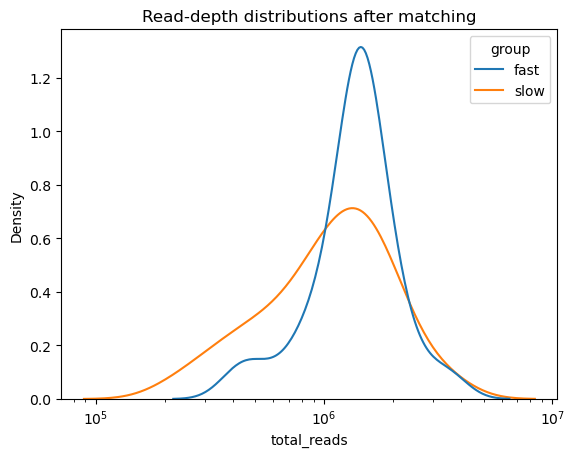

In [117]:
sns.kdeplot(data=sample_totals_matched, x="total_reads", hue="group", log_scale=True)
plt.title("Read-depth distributions after matching")
plt.show()

In [118]:
print(sample_totals_matched.groupby("group")["total_reads"].describe()[["50%","25%","75%"]])


             50%         25%         75%
group                                   
fast   1403492.5  1150499.50  1616725.50
slow   1171334.5   718466.75  1549608.25


In [119]:
# 3) Downsample within each sample to target_reads
clonotype_df_down = downsample_reads_within_sample_multinomial(
    df=clonotype_df_matched,
    read_col=READ_COL,
    target_reads=target_reads,
    seed=0,
    out_col="ds_reads",
)

# 4) Define shared/unique sets AFTER matching+downsampling
shared_set_std, unique_fast_set_std, unique_slow_set_std, df_counts_std = (
    define_shared_unique_sets_after_downsampling(
        df_down=clonotype_df_down,
        thresh=THRESH,
        ds_col="ds_reads",
    )
)

print(f"shared_set_std: {len(shared_set_std)}")
print(f"unique_fast_set_std: {len(unique_fast_set_std)}")
print(f"unique_slow_set_std: {len(unique_slow_set_std)}")


/tmp/ipykernel_501051/389613612.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_ds_one_sample)


shared_set_std: 27987
unique_fast_set_std: 19646
unique_slow_set_std: 4527


In [120]:
df_shared = build_biochem_df(shared_set_std, "Shared")
df_fast = build_biochem_df(unique_fast_set_std, "Unique Fast")
df_slow = build_biochem_df(unique_slow_set_std, "Unique Slow")

# Combine
biochem_master_std = pd.concat([df_shared, df_fast, df_slow], ignore_index=True)
biochem_master_std = biochem_master_std.dropna(subset=["Length", "Isoelectric Point"])


Hypothesis: Shared clonotypes represent a structurally constrained subgroup of TCRs.<br>
below code tests: "If I randomly draw one shared clonotype and one unique clonotype,
are their biochemical properties systematically different?"

In [121]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def compute_biochem_pairwise_pvals(
    biochem_master: pd.DataFrame,
    metrics: list,
    group_col: str = "Group",
    shared_label: str = "Shared",
    fast_label: str = "Unique Fast",
    slow_label: str = "Unique Slow",
    apply_fdr: bool = True,
):
    rows = []

    for metric in metrics:
        x = biochem_master.loc[biochem_master[group_col] == shared_label, metric].dropna().values
        y_fast = biochem_master.loc[biochem_master[group_col] == fast_label, metric].dropna().values
        y_slow = biochem_master.loc[biochem_master[group_col] == slow_label, metric].dropna().values

        # two-sided Mann–Whitney U
        p_sf = np.nan
        p_ss = np.nan
        if len(x) > 0 and len(y_fast) > 0:
            _, p_sf = mannwhitneyu(x, y_fast, alternative="two-sided")
        if len(x) > 0 and len(y_slow) > 0:
            _, p_ss = mannwhitneyu(x, y_slow, alternative="two-sided")

        rows.append({
            "metric": metric,
            "p_shared_vs_fast": p_sf,
            "p_shared_vs_slow": p_ss,
        })

    out = pd.DataFrame(rows)

    if apply_fdr:
        # FDR separately within each comparison family across metrics
        for pcol, qcol in [
            ("p_shared_vs_fast", "q_shared_vs_fast"),
            ("p_shared_vs_slow", "q_shared_vs_slow"),
        ]:
            pvals = out[pcol].to_numpy(dtype=float)
            q = np.full_like(pvals, np.nan, dtype=float)
            valid = np.isfinite(pvals)
            if valid.any():
                _, q_valid, _, _ = multipletests(pvals[valid], method="fdr_bh")
                q[valid] = q_valid
            out[qcol] = q

    return out

def plot_biochem_with_pairwise_stats(
    biochem_master: pd.DataFrame,
    violin_metrics: list,
    box_metrics: list,
    stats_df: pd.DataFrame,
    group_order: tuple = ("Shared", "Unique Fast", "Unique Slow"),
    group_col: str = "Group",
    show_q_on_plot: bool = False,
):
    biochem_master["Group"] = (
        biochem_master["Group"]
        .replace({"Unique Fast": "Immediate", "Unique Slow": "Delayed"})
    )

    biochem_master[group_col] = (
        biochem_master[group_col]
        .replace({"Unique Fast": "Immediate", "Unique Slow": "Delayed"})
    )

    group_order = ["Shared", "Immediate", "Delayed"]
    palette = {
    "Shared": "#2ca02c",       # green
    "Immediate": "#1f77b4",    # blue
    "Delayed": "#ff7f0e"       # orange
    }

    stats_df = stats_df.rename(columns={
    "p_shared_vs_fast": "p_shared_vs_immediate",
    "p_shared_vs_slow": "p_shared_vs_delayed",
    "q_shared_vs_fast": "q_shared_vs_immediate",
    "q_shared_vs_slow": "q_shared_vs_delayed"})

    # Combine metrics but keep track of type
    metric_info = []
    for m in box_metrics:
        metric_info.append((m, "histogram"))
    for m in violin_metrics:
        metric_info.append((m, "violin"))

    stats_df = stats_df.set_index("metric")

    n = len(metric_info)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    bottom_row_start = (nrows - 1) * ncols
    bottom_row_axes = set(range(bottom_row_start, bottom_row_start + ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), constrained_layout=True)
    axes = np.array(axes).ravel()
    fig.suptitle("Biochemical Properties by Group", fontsize=22)

    for i, (metric, plot_type) in enumerate(metric_info):
        ax = axes[i]

        # Choose plot type
        if plot_type == "violin":
            sns.violinplot(data=biochem_master, x=group_col, y=metric, order=list(group_order),
                            inner="box", cut=0, hue="Group",palette=palette, ax=ax)
        else:  # histogram
            sns.histplot(data=biochem_master,x=metric, hue="Group", palette=palette,element="step",
                          stat="density",common_norm=False,bins=20,ax=ax)
            
        ax.set_title(f"{metric}", fontsize=16)
        ax.set_xlabel("")
        # Shortened y-axis label
        short_label = metric.split()[-1]   # e.g., "Hydrophobicity GRAVY" → "GRAVY"
        ax.set_ylabel(short_label, fontsize=14)
        # Remove x-axis labels except bottom row
        if i not in bottom_row_axes:
            ax.set_xlabel("")
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis="x", labelsize=14)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="center")

        # Pull p/q values
        if metric in stats_df.index:
            p_sf = stats_df.at[metric, "p_shared_vs_immediate"]
            p_ss = stats_df.at[metric, "p_shared_vs_delayed"]
            q_sf = stats_df.at[metric, "q_shared_vs_immediate"]
            q_ss = stats_df.at[metric, "q_shared_vs_delayed"]
        else:
            p_sf = p_ss = q_sf = q_ss = np.nan
        # Choose p or q for annotation
        if show_q_on_plot:
            line1 = f"Shared vs Immediate: q={q_sf:.2e}" if np.isfinite(q_sf) else "Shared vs Immediate: q=NA"
            line2 = f"Shared vs Delayed: q={q_ss:.2e}" if np.isfinite(q_ss) else "Shared vs Delayed: q=NA"
        else:
            line1 = f"Shared vs Immediate: p={p_sf:.2e}" if np.isfinite(p_sf) else "Shared vs Immediate: p=NA"
            line2 = f"Shared vs Delayed: p={p_ss:.2e}" if np.isfinite(p_ss) else "Shared vs Delayed: p=NA"

        ax.text(
            0.02, 0.98, f"{line1}\n{line2}",
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="none")
        )

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    save_plot("../colon/biochemical_pvalue.svg", format="svg", bbox_inches="tight")
    plt.show()


In [122]:
VIOLIN_METRICS = [
    "Aromaticity",
    "Isoelectric Point",
    "Hydrophobicity GRAVY",
    "Charge pH7",
    "AA Shannon Entropy",
    "Charged Fraction"
]

HISTOGRAM_METRICS = [
    "Length"
]

metrics = VIOLIN_METRICS + HISTOGRAM_METRICS

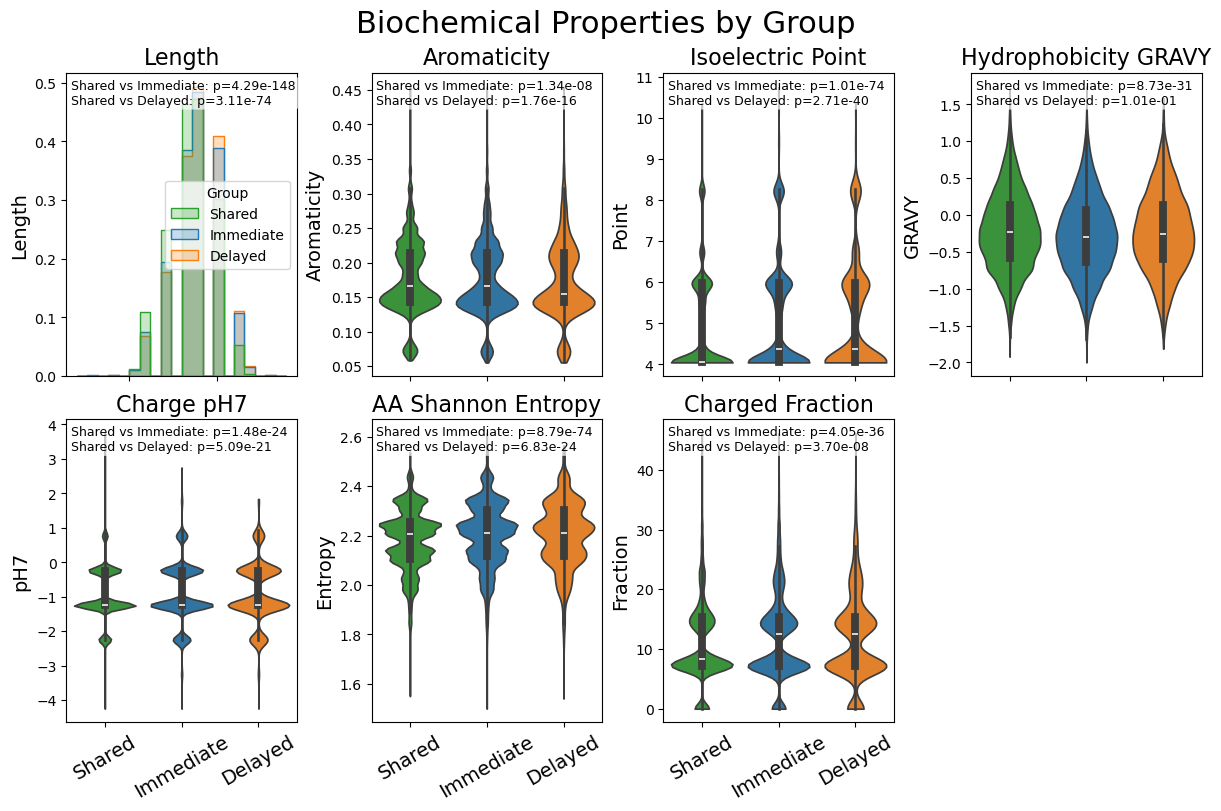

In [123]:
biochem_p_stats_df = compute_biochem_pairwise_pvals(biochem_master_std, metrics, apply_fdr=True)
plot_biochem_with_pairwise_stats(biochem_master_std, VIOLIN_METRICS, HISTOGRAM_METRICS, biochem_p_stats_df, show_q_on_plot=False)

In [124]:
from matplotlib.patches import Patch

def plot_biochem_with_pairwise_stats_new(
    biochem_master: pd.DataFrame,
    violin_metrics: list,
    box_metrics: list,
    stats_df: pd.DataFrame,
    group_order: tuple = ("Shared", "Unique Fast", "Unique Slow"),
    group_col: str = "Group",
    show_q_on_plot: bool = False,
):
    # harmonize group names 
    biochem_master = biochem_master.copy()
    biochem_master["Group"] = biochem_master["Group"].replace(
        {"Unique Fast": "Immediate", "Unique Slow": "Delayed"}
    )
    biochem_master[group_col] = biochem_master[group_col].replace(
        {"Unique Fast": "Immediate", "Unique Slow": "Delayed", "Shared": "Core"}
    )

    group_order = ["Core", "Immediate", "Delayed"]
    palette = {
        "Core": "#2ca02c",
        "Immediate": "#1f77b4",
        "Delayed": "#ff7f0e"
    }

    stats_df = stats_df.rename(columns={
        "p_shared_vs_fast": "p_shared_vs_immediate",
        "p_shared_vs_slow": "p_shared_vs_delayed",
        "q_shared_vs_fast": "q_shared_vs_immediate",
        "q_shared_vs_slow": "q_shared_vs_delayed"
    }).set_index("metric")

    #  force Length to be the dedicated histogram metric (remove from other lists if present)
    length_metric = "Length"
    violin_metrics = [m for m in violin_metrics if m != length_metric]
    box_metrics = [m for m in box_metrics if m != length_metric]

    other_hist_metrics = list(box_metrics)

    # layout: 4 columns total
    # col 0 = Length (row 0) + Legend (row 1)
    # cols 1-3 = violins (and optionally other hists) in a 3-col grid
    violin_cols = 3
    violin_items = [(m, "violin") for m in violin_metrics] + [(m, "histogram") for m in other_hist_metrics]
    n_violin = len(violin_items)
    n_violin_rows = int(np.ceil(n_violin / violin_cols)) if n_violin > 0 else 1

    # need at least 2 rows to host legend beneath Length
    nrows = max(n_violin_rows, 2)
    ncols = 1 + violin_cols  # 4 total

    fig = plt.figure(figsize=(12, 4 * nrows), constrained_layout=True)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    fig.suptitle("Biochemical Properties by Group", fontsize=22)

    # Length panel (top-left)
    ax_len = fig.add_subplot(gs[0, 0])
    if length_metric in biochem_master.columns:
        sns.histplot(data=biochem_master, x=length_metric, hue=group_col, palette=palette, element="step",
                      stat="density", common_norm=False, bins=20, ax=ax_len)
        ax_len.set_title(length_metric, fontsize=16)
        ax_len.set_xlabel("")
        ax_len.set_ylabel(length_metric, fontsize=14)

        # annotate p/q for Length
        if length_metric in stats_df.index:
            p_sf = stats_df.at[length_metric, "p_shared_vs_immediate"]
            p_ss = stats_df.at[length_metric, "p_shared_vs_delayed"]
            q_sf = stats_df.at[length_metric, "q_shared_vs_immediate"]
            q_ss = stats_df.at[length_metric, "q_shared_vs_delayed"]
        else:
            p_sf = p_ss = q_sf = q_ss = np.nan

        if show_q_on_plot:
            line1 = f"Core vs Immediate: q={q_sf:.2e}" if np.isfinite(q_sf) else "Core vs Immediate: q=NA"
            line2 = f"Core vs Delayed: q={q_ss:.2e}" if np.isfinite(q_ss) else "Core vs Delayed: q=NA"
        else:
            line1 = f"Core vs Immediate: p={p_sf:.2e}" if np.isfinite(p_sf) else "Core vs Immediate: p=NA"
            line2 = f"Core vs Delayed: p={p_ss:.2e}" if np.isfinite(p_ss) else "Core vs Delayed: p=NA"

        ax_len.text(
            0.02, 0.98, f"{line1}\n{line2}",
            transform=ax_len.transAxes,
            ha="left", va="top",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="none"))
    else:
        ax_len.axis("off")

    # Legend cell under Length
    ax_leg = fig.add_subplot(gs[1, 0])
    ax_leg.axis("off")

    legend_handles = [Patch(facecolor=palette[g], edgecolor="none", label=g) for g in group_order]
    ax_leg.legend(
        handles=legend_handles,
            title="Group",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05), 
        frameon=True)

    # ensure no legends remain elsewhere
    for ax in fig.axes:
        if ax is not ax_leg and ax.get_legend() is not None:
            ax.get_legend().remove()
    
    # Populate violin grid
    # Only show x tick labels on the bottom row of the violin grid
    violin_bottom_row = n_violin_rows - 1

    for idx, (metric, plot_type) in enumerate(violin_items):
        r = idx // violin_cols
        c = idx % violin_cols
        ax = fig.add_subplot(gs[r, c + 1])

        if plot_type == "violin":
            # don't set hue=Group when x is Group; it duplicates artists + legend noise
            sns.violinplot( data=biochem_master, x=group_col, y=metric, order=group_order, inner="box",
                            cut=0, palette=palette, hue="Group", ax=ax)
        else:
            sns.histplot(data=biochem_master,x=metric, hue=group_col, palette=palette, element="step",
                          stat="density", common_norm=False, bins=20, ax=ax)
            # don't keep legends in these panels
            if ax.get_legend() is not None:
                ax.get_legend().remove()

        ax.set_title(metric, fontsize=16)
        ax.set_xlabel("")

        short_label = metric.split()[-1]
        ax.set_ylabel(short_label, fontsize=14)

        # x ticks only on bottom violin row
        if r != violin_bottom_row:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis="x", labelsize=14)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="center")

        # annotate p/q
        if metric in stats_df.index:
            p_sf = stats_df.at[metric, "p_shared_vs_immediate"]
            p_ss = stats_df.at[metric, "p_shared_vs_delayed"]
            q_sf = stats_df.at[metric, "q_shared_vs_immediate"]
            q_ss = stats_df.at[metric, "q_shared_vs_delayed"]
        else:
            p_sf = p_ss = q_sf = q_ss = np.nan

        if show_q_on_plot:
            line1 = f"Core vs Immediate: q={q_sf:.2e}" if np.isfinite(q_sf) else "Core vs Immediate: q=NA"
            line2 = f"Shared vs Delayed: q={q_ss:.2e}" if np.isfinite(q_ss) else "Core vs Delayed: q=NA"
        else:
            line1 = f"Core vs Immediate: p={p_sf:.2e}" if np.isfinite(p_sf) else "Core vs Immediate: p=NA"
            line2 = f"Core vs Delayed: p={p_ss:.2e}" if np.isfinite(p_ss) else "Core vs Delayed: p=NA"

        ax.text(
            0.02, 0.98, f"{line1}\n{line2}",
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="none")
        )

    # Turn off any unused cells
    for rr in range(2, nrows):
        ax_empty = fig.add_subplot(gs[rr, 0])
        ax_empty.axis("off")
    
    save_plot("../colon/biochemical_pvalue_new.svg", format="svg", bbox_inches="tight")
    fig.show()



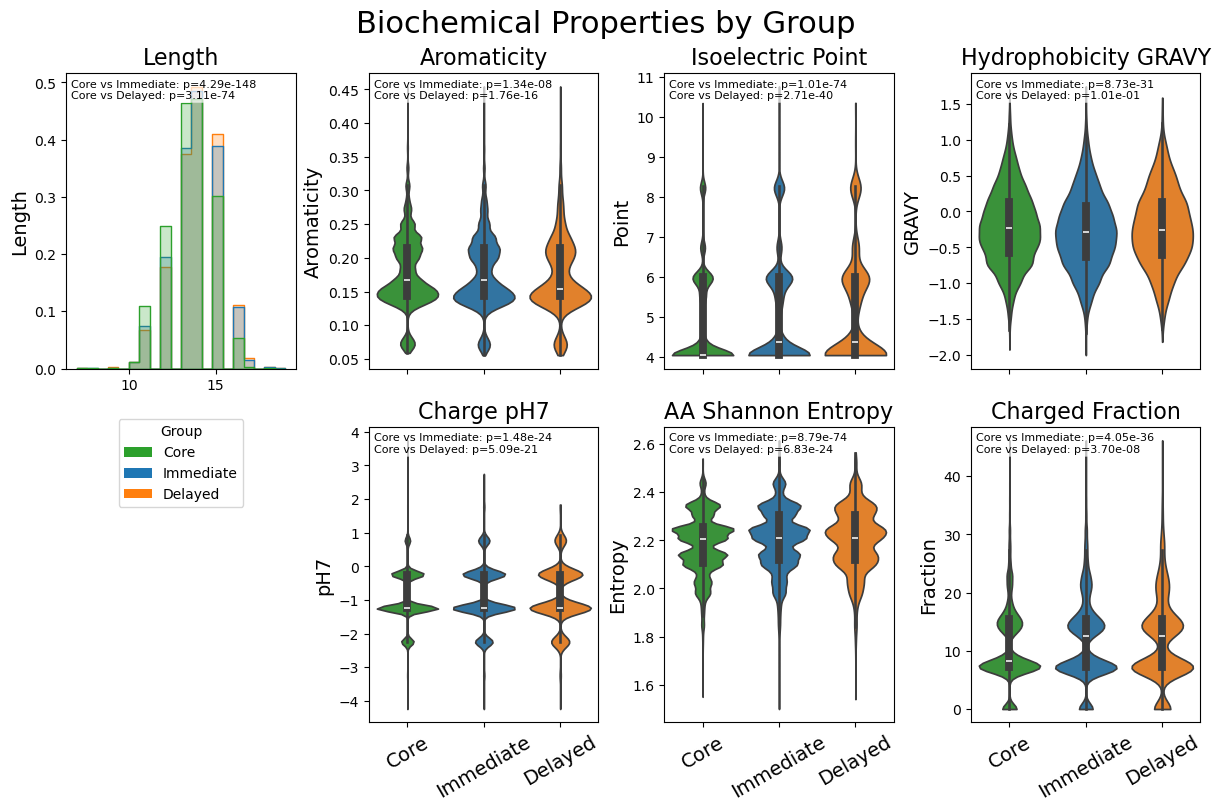

In [125]:
plot_biochem_with_pairwise_stats_new(biochem_master_std, VIOLIN_METRICS, HISTOGRAM_METRICS, biochem_p_stats_df, show_q_on_plot=False)

# Corrolation Graph

## Load Corrolation and overlap graph

Thesis highly corrolated graph used in epitope matching:<br>
min_r_fast=0.9140, min_r_slow=0.9340, LCC size=11, nodes=61, edges=74

In [26]:
# FAST_R = 0.9140
# SLOW_R = 0.9340
# CORR_PUB_THRESHOLD=5
FAST_R = 0.85
SLOW_R = 0.87
CORR_PUB_THRESHOLD=3

In [27]:
import networkx as nx
import numpy as np

def load_corr(clonotype_df, threshold=5):
    # A narrow view ONLY for the survivor/qualification logic
    logic_df = clonotype_df[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])
    # survivors: AA present in BOTH groups
    presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                        .size().unstack(fill_value=0))
    survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]
    survivor_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

    threshold = threshold
    counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
            .nunique().unstack(fill_value=0))
    qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                            (counts.get('slow',0) >= threshold)].index

    # keep these objects with ALL columns 
    qualified_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(qualified_tcrs)].copy()

    fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
    slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

    # Expression matrices (needs 'readFraction' present in sub)
    fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)
    slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)

    fast_expr_numpy = fast_expr.to_numpy()
    fast_corr_numpy = np.corrcoef(fast_expr_numpy)
    fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)

    slow_expr_numpy = slow_expr.to_numpy()
    slow_corr_numpy = np.corrcoef(slow_expr_numpy)
    slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)
    return fast_df, slow_df, fast_corr, slow_corr

In [28]:
def intersection_graph_with_weights(G1, G2, attr1='weight', attr2='weight', new_attr1='fast_weight', new_attr2='slow_weight'):
    """
    Returns a new graph with only edges present in both G1 and G2.
    Edge attributes from G1 and G2 are preserved as new_attr1 and new_attr2.
    Only nodes with at least one shared edge will be included.
    """
    G_inter = nx.Graph()
    # Create sets of edges as (nodeA, nodeB) sorted tuples for undirected comparison
    edges1 = set(tuple(sorted(e)) for e in G1.edges())
    edges2 = set(tuple(sorted(e)) for e in G2.edges())
    shared_edges = edges1 & edges2
    
    for u, v in shared_edges:
        # Copy correlation weights from both graphs
        w1 = G1[u][v][attr1]
        w2 = G2[u][v][attr2]
        G_inter.add_edge(u, v, **{new_attr1: w1, new_attr2: w2})
    return G_inter


def largest_component_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G))

def tune_overlap_graph(
    fast_corr, slow_corr, 
    target_size=80, 
    init_min_r_fast=None, 
    init_min_r_slow=None,
    step=0.01, 
    max_iter=30, 
    tol=5, 
    verbose=True
):
    # Estimate good starting thresholds if not given
    if init_min_r_fast is None:
        fast_vals = fast_corr.values[np.triu_indices_from(fast_corr, k=1)]
        init_min_r_fast = np.percentile(fast_vals, 99)  
    if init_min_r_slow is None:
        slow_vals = slow_corr.values[np.triu_indices_from(slow_corr, k=1)]
        init_min_r_slow = np.percentile(slow_vals, 99)
        
    min_r_fast = init_min_r_fast
    min_r_slow = init_min_r_slow
    best_diff = float('inf')
    best_result = None
    
    for i in range(max_iter):
        # Build graphs
        G_fast = build_pos_corr_graph(fast_corr, min_r_fast)
        G_slow = build_pos_corr_graph(slow_corr, min_r_slow)
        # Intersect
        G_overlap = intersection_graph_with_weights(G_fast, G_slow)
        # Largest component size
        lcc_size = largest_component_size(G_overlap)
        diff = abs(lcc_size - target_size)
        if verbose:
            print(f"Iter {i}: min_r_fast={min_r_fast:.4f}, min_r_slow={min_r_slow:.4f}, "
                  f"LCC size={lcc_size}, total nodes={G_overlap.number_of_nodes()}, total edges={G_overlap.number_of_edges()}")
        # Save best result so far
        if diff < best_diff:
            best_diff = diff
            best_result = (min_r_fast, min_r_slow, G_fast, G_slow, G_overlap, lcc_size)
        # Converged?
        if diff <= tol:
            break
        # Adjust thresholds:
        if lcc_size > target_size:
            # Too big: increase thresholds
            min_r_fast += step
            min_r_slow += step
        else:
            # Too small: decrease thresholds
            min_r_fast -= step
            min_r_slow -= step
    # Return best result
    return {
        "min_r_fast": best_result[0],
        "min_r_slow": best_result[1],
        "G_fast": best_result[2],
        "G_slow": best_result[3],
        "G_overlap": best_result[4],
        "lcc_size": best_result[5]
    }

def build_pos_corr_graph(corr_matrix, min_r=None):
    """
    Efficiently build a NetworkX graph from a correlation matrix using a threshold.
    Precompute the edge list directly from the correlation matrix (using NumPy or pandas).
    Only adds edges where r >= min_r (positive correlation).
    """
    tcrs = np.array(corr_matrix.index)
    # Get upper triangle indices (excluding diagonal)
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
    # Get pairs and correlations
    i_idx, j_idx = np.where(mask)
    corrs = corr_matrix.values[mask]
    if min_r is not None:
        select = np.where(corrs >= min_r)[0]
        i_idx = i_idx[select]
        j_idx = j_idx[select]
        corrs = corrs[select]
    # Build edge list
    edge_list = [
        (tcrs[i], tcrs[j], {'weight': float(corr)})
        for i, j, corr in zip(i_idx, j_idx, corrs)
    ]
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

import pickle

# Save function
def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)

# Load function
def load_graph(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [13]:
fast_df, slow_df, fast_corr, slow_corr = load_corr(clonotype_df, threshold=CORR_PUB_THRESHOLD)

In [14]:
# tune_results = tune_overlap_graph(
#     fast_corr, slow_corr,
#     init_min_r_fast= 0.91, 
#     init_min_r_slow= 0.93,
#     target_size=10, # LCC target size
#     step=0.001,    
#     max_iter=40,
#     tol=1,         
#     verbose=True
# )
# G_overlap_tune = tune_results["G_overlap"]

In [15]:
G_fast_sub = build_pos_corr_graph(fast_corr, min_r=FAST_R)
G_slow_sub = build_pos_corr_graph(slow_corr, min_r=SLOW_R)
G_overlap = intersection_graph_with_weights(G_fast_sub, G_slow_sub)

In [16]:
G_overlap.number_of_nodes()

1878

In [17]:
# Get all connected components sorted by size
components = sorted(nx.connected_components(G_overlap), key=len, reverse=True)

# Extract the largest and second-largest
largest_cc_nodes = components[0]
second_largest_cc_nodes = components[1]

# Create subgraphs
G_overlap_lcc_largest = G_overlap.subgraph(largest_cc_nodes).copy()
G_overlap_lcc_second = G_overlap.subgraph(second_largest_cc_nodes).copy()

In [18]:
G_overlap_lcc_largest.nodes()

NodeView(('CSARWWRSYNEQFF', 'CASSVGGATDTQYF', 'CSALGQGNQPQHF', 'CASSPGQGGDTQYF', 'CASRRTGSSYNEQFF', 'CASSSTGGGSYNEQFF', 'CASSLEAEETQYF', 'CASSLTGGGQETQYF', 'CASSLVRGTYNEQFF', 'CASSRREGYNEQFF', 'CASSPGYYEQYF', 'CASSQDFNEQFF', 'CASSQGAGNSPLHF', 'CATRDSSYNEQFF', 'CSARDYGYTF', 'CASSQTGDSPLHF', 'CASSPLGPNTGELFF', 'CASSLVKDTQYF', 'CASSDRGRTEAFF', 'CASSFDFYEQYF', 'CASSLWSTGELFF', 'CASSLVQGATEAFF', 'CASSLTAGANVLTF', 'CASSGTSGANTGELFF', 'CASRQGDTQYF', 'CASSETSGGGNEQFF', 'CASSLDINNEQFF', 'CASSEAGGYNEQFF', 'CASSEYNQPQHF', 'CASSKTGDYGYTF', 'CASSPGLAGDTGELFF', 'CASSLLPSGANVLTF', 'CASSFSSGSSYEQYF', 'CASRPGTGTYEQYF', 'CASSLGQGQETQYF', 'CASSGQGSGANVLTF', 'CASSPTTGSYEQYF', 'CASRTGGDTGELFF', 'CASSFRDSPYNEQFF', 'CASSLDFYNEQFF', 'CASSQGTETQYF', 'CASSPNMNTEAFF', 'CASSLGASGPYEQYF', 'CASSFGTGELFF', 'CSVEEGYTF', 'CASSQDSGGPYEQYF', 'CASSRTGVSTDTQYF', 'CASSTTSGDTQYF'))

REMOVE AFTERWORD

In [19]:
def analyze_publicity(
    df: pd.DataFrame, 
    survivors_set: set, 
    aa_col: str = "aaSeqCDR3", 
    sample_col: str = "Sample_ID", 
    group_col: str = "group"
):
    """
    Analyzes if 'survivor' (shared) clonotypes appear in more samples (are more public) 
    than non-shared clonotypes.
    
    Returns:
    - stats_df: Summary DataFrame with Mean, Median, and P-values.
    - raw_counts: The underlying counts for plotting/further analysis.
    """
    
    # 1. Label every AA in the full DF as Survivor (Shared) or Non-Survivor (Private to one group)
    # We work with a unique list of (AA, Sample, Group) to avoid counting multiple reads in one sample
    df_unique = df[[aa_col, sample_col, group_col]].drop_duplicates()
    
    # ---------------------------------------------------------
    # PART A: Analysis by Group (Immediate vs Delayed separately)
    # ---------------------------------------------------------
    
    # Count samples per AA within each group
    group_counts = (
        df_unique.groupby([aa_col, group_col])[sample_col]
        .nunique()
        .reset_index(name="sample_count")
    )
    
    group_counts["is_survivor"] = group_counts[aa_col].isin(survivors_set)
    
    results = []
    
    for group_name, sub in group_counts.groupby(group_col):
        survivors = sub[sub["is_survivor"]]["sample_count"]
        non_survivors = sub[~sub["is_survivor"]]["sample_count"]
        
        # Mann-Whitney U Test (samples are independent for this comparison)
        # H0: The distributions are equal. H1: Survivors are different (likely higher).
        stat, pval = mannwhitneyu(survivors, non_survivors, alternative='two-sided')
        
        results.append({
            "Scope": f"Group: {group_name}",
            "Type": "Survivor",
            "N_Clonotypes": len(survivors),
            "Mean_Samples": survivors.mean(),
            "Median_Samples": survivors.median(),
            "Max_Samples": survivors.max(),
            "%_Public (>1 sample)": (survivors > 1).mean() * 100
        })
        
        results.append({
            "Scope": f"Group: {group_name}",
            "Type": "Non-Survivor",
            "N_Clonotypes": len(non_survivors),
            "Mean_Samples": non_survivors.mean(),
            "Median_Samples": non_survivors.median(),
            "Max_Samples": non_survivors.max(),
            "%_Public (>1 sample)": (non_survivors > 1).mean() * 100
        })
        
        # Add P-value row or column? Let's add it to the Survivor row for clarity
        results[-2]["MW_P_Value"] = pval

    # ---------------------------------------------------------
    # PART B: Total Analysis (Across ALL samples combined)
    # ---------------------------------------------------------
    
    total_counts = (
        df_unique.groupby(aa_col)[sample_col]
        .nunique()
        .reset_index(name="sample_count")
    )
    
    total_counts["is_survivor"] = total_counts[aa_col].isin(survivors_set)
    
    survivors_tot = total_counts[total_counts["is_survivor"]]["sample_count"]
    non_survivors_tot = total_counts[~total_counts["is_survivor"]]["sample_count"]
    
    stat_tot, pval_tot = mannwhitneyu(survivors_tot, non_survivors_tot, alternative='two-sided')
    
    results.append({
        "Scope": "Total (All Samples)",
        "Type": "Survivor",
        "N_Clonotypes": len(survivors_tot),
        "Mean_Samples": survivors_tot.mean(),
        "Median_Samples": survivors_tot.median(),
        "Max_Samples": survivors_tot.max(),
        "%_Public (>1 sample)": (survivors_tot > 1).mean() * 100,
        "MW_P_Value": pval_tot
    })
    
    results.append({
        "Scope": "Total (All Samples)",
        "Type": "Non-Survivor",
        "N_Clonotypes": len(non_survivors_tot),
        "Mean_Samples": non_survivors_tot.mean(),
        "Median_Samples": non_survivors_tot.median(),
        "Max_Samples": non_survivors_tot.max(),
        "%_Public (>1 sample)": (non_survivors_tot > 1).mean() * 100
    })
    
    # Format and Return
    stats_df = pd.DataFrame(results).set_index(["Scope", "Type"])
    return stats_df, group_counts, total_counts
    
# 1. Extract the nodes from the graph to create the new "Set of Interest"
network_set = set(G_overlap.nodes())

print(f"Analyzing {len(network_set)} clonotypes found in G_overlap...")

# ---------------------------------------------------------
# A. General Publicity Analysis (Mann-Whitney)
# ---------------------------------------------------------
# Note: In the output below:
# "Survivor" = Inside the Graph (Nodes)
# "Non-Survivor" = Outside the Graph
stats_network, _, _ = analyze_publicity(
    clonotype_df, 
    network_set,   # <--- We pass the graph nodes here
    group_col="group"
)

print("\n=== Publicity: Graph Nodes vs. Rest of Repertoire ===")
print(stats_network[["N_Clonotypes", "Mean_Samples", "Median_Samples", "%_Public (>1 sample)", "MW_P_Value"]])

# ---------------------------------------------------------
# B. Top-Tier Dominance Analysis
# ---------------------------------------------------------
enrichment_network, top_unique_network = analyze_top_tier_dominance(
    clonotype_df, 
    network_set    # <--- We pass the graph nodes here
)

print("\n=== Graph Nodes Dominance in Top Tiers ===")
pivot_dominance_net = enrichment_network.pivot(index="Top_N_Cutoff", columns="Group", values="%_Survivors")
print(pivot_dominance_net.round(2))

print("\n=== Enrichment Factor (Graph Nodes vs Random) ===")
pivot_enrich_net = enrichment_network.pivot(index="Top_N_Cutoff", columns="Group", values="Fold_Enrichment")
print(pivot_enrich_net.round(2))

Analyzing 1878 clonotypes found in G_overlap...

=== Publicity: Graph Nodes vs. Rest of Repertoire ===
                                  N_Clonotypes  Mean_Samples  Median_Samples  \
Scope               Type                                                       
Group: fast         Survivor              1878       16.3829         12.0000   
                    Non-Survivor       8990100        1.3931          1.0000   
Group: slow         Survivor              1878        4.3600          3.0000   
                    Non-Survivor       1850827        1.1728          1.0000   
Total (All Samples) Survivor              1878       20.7428         15.0000   
                    Non-Survivor      10320186        1.4239          1.0000   

                                  %_Public (>1 sample)  MW_P_Value  
Scope               Type                                            
Group: fast         Survivor                  100.0000      0.0000  
                    Non-Survivor               12

In [20]:
def analyze_cv_differences(
    df: pd.DataFrame, 
    graph_nodes: set, 
    group_name: str = "fast",  # נבדוק בקבוצת ה-fast שבה נוצרה הדינמיקה
    top_n: int = 50,
    read_col: str = "readCount", # או ds_reads אם יש לך
    sample_col: str = "Sample_ID"
):
    """
    Compares the Coefficient of Variation (CV) between:
    1. Graph Nodes (The Correlated Modules)
    2. Top Public Clonotypes that are NOT in the graph (The 'Lonely Giants')
    """
    
    # 1. Filter for the specific group
    df_group = df[df["group"] == group_name].copy()
    
    # 2. Normalize reads to Frequency (CPM or similar) to avoid sequencing depth bias
    #    (Variance in raw reads is meaningless if library sizes differ)
    sample_totals = df_group.groupby(sample_col)[read_col].transform("sum")
    df_group["freq"] = df_group[read_col] / sample_totals
    
    # 3. Pivot to create a Matrix: Index=Sample, Columns=Clonotype
    #    Fill missing values with 0 (important for variance calculation)
    pivoted = df_group.pivot_table(
        index=sample_col, 
        columns="aaSeqCDR3", 
        values="freq", 
        fill_value=0
    )
    
    # 4. Calculate Stats per Clonotype
    stats = pd.DataFrame(index=pivoted.columns)
    stats["mean_freq"] = pivoted.mean()
    stats["std_freq"] = pivoted.std()
    # CV = sigma / mu
    stats["CV"] = stats["std_freq"] / stats["mean_freq"]
    
    # Count how many samples have it (Publicity)
    stats["n_samples"] = (pivoted > 0).sum()
    
    # 5. Define the two groups for comparison
    
    # A. Graph Nodes
    is_in_graph = stats.index.isin(graph_nodes)
    stats["category"] = np.where(is_in_graph, "Graph_Node", "Other")
    
    # B. The "Lonely Giants" (Top Public but NOT in Graph)
    #    We take the Top N by publicity (n_samples) that are NOT in the graph
    non_graph = stats[~is_in_graph].sort_values("n_samples", ascending=False).head(top_n)
    
    # Update category for these specific top clones
    stats.loc[non_graph.index, "category"] = "Top_Public_Non_Graph"
    
    # 6. Extract subsets for analysis
    graph_stats = stats[stats["category"] == "Graph_Node"]
    top_public_stats = stats[stats["category"] == "Top_Public_Non_Graph"]
    
    # 7. Print Results
    print(f"=== CV Analysis ({group_name} group) ===")
    print(f"Comparing {len(graph_stats)} Graph Nodes vs. Top {len(top_public_stats)} Non-Graph Public Clones\n")
    
    res_df = pd.DataFrame([
        {
            "Group": "Graph Nodes (Correlated)",
            "Mean_CV": graph_stats["CV"].mean(),
            "Median_CV": graph_stats["CV"].median(),
            "Mean_Freq": graph_stats["mean_freq"].mean()
        },
        {
            "Group": "Top Public (Non-Graph)",
            "Mean_CV": top_public_stats["CV"].mean(),
            "Median_CV": top_public_stats["CV"].median(),
            "Mean_Freq": top_public_stats["mean_freq"].mean()
        }
    ])
    
    print(res_df.set_index("Group"))
    
    # Statistical Test
    stat, pval = mannwhitneyu(graph_stats["CV"].dropna(), top_public_stats["CV"].dropna())
    print(f"\nMann-Whitney U test on CV: P-value = {pval:.5f}")
    
    return stats, graph_stats, top_public_stats

# --- Execution ---
all_stats, graph_stats, top_stats = analyze_cv_differences(
    clonotype_df, 
    set(G_overlap.nodes()), 
    group_name="fast",
    top_n=50  
)

print("\n=== Top 5 'Lonely Giants' Stats ===")
print(top_stats[["n_samples", "mean_freq", "CV"]].head(5))

=== CV Analysis (fast group) ===
Comparing 1878 Graph Nodes vs. Top 50 Non-Graph Public Clones

                          Mean_CV  Median_CV  Mean_Freq
Group                                                  
Graph Nodes (Correlated)   7.4207     7.2632     0.0000
Top Public (Non-Graph)     2.2670     1.5154     0.0000

Mann-Whitney U test on CV: P-value = 0.00000

=== Top 5 'Lonely Giants' Stats ===
               n_samples  mean_freq     CV
aaSeqCDR3                                 
CASSFGETQYF          135     0.0000 2.5957
CASSFQETQYF          148     0.0000 2.3980
CASSFTDTQYF          138     0.0000 8.3944
CASSLAGTDTQYF        135     0.0000 1.5948
CASSLDSYEQYF         132     0.0000 2.4403


## Cosmograph visualization

In [182]:
import pandas as pd
import networkx as nx

def graphs_to_cosmo_dfs(G_fast_sub: nx.Graph,
                        G_slow_sub: nx.Graph,
                        G_overlap: nx.Graph,
                        fast_attr: str = "weight",
                        slow_attr: str = "weight",
                        overlap_fast_attr: str = "fast_weight",
                        overlap_slow_attr: str = "slow_weight"):
    """
    Build Cosmograph-ready DataFrames from fast/slow subgraphs and their overlap.

    Returns:
        points_df: columns ['id'] (overlap nodes as string/int labels from G_overlap)
        links_df: columns ['source','target','fast_weight','slow_weight','sum_weight','avg_weight']

    Logic:
      - points_df contains ONLY nodes that appear in G_overlap (i.e., have >=1 shared edge).
      - links_df contains ONLY edges in G_overlap.
      - fast_weight / slow_weight are taken from G_overlap if present; otherwise pulled from
        G_fast_sub / G_slow_sub using fast_attr / slow_attr (useful if overlap graph was built differently).
    """
    # --- points ---
    overlap_nodes = list(G_overlap.nodes())
    points_df = pd.DataFrame({"id": overlap_nodes})

    # --- helper to safely fetch undirected edge attribute ---
    def _get_edge_attr(G, u, v, key, default=None):
        if G.has_edge(u, v):
            return G[u][v].get(key, default)
        if G.has_edge(v, u):
            return G[v][u].get(key, default)
        return default

    # --- links ---
    rows = []
    for u, v, data in G_overlap.edges(data=True):
        # Prefer attributes stored on G_overlap (from your intersection function)
        fw = data.get(overlap_fast_attr, None)
        sw = data.get(overlap_slow_attr, None)

        # Fallback: pull from original graphs if missing
        if fw is None:
            fw = _get_edge_attr(G_fast_sub, u, v, fast_attr, None)
        if sw is None:
            sw = _get_edge_attr(G_slow_sub, u, v, slow_attr, None)

        # Compute aggregate columns (handle missing values robustly)
        fw_num = float(fw) if fw is not None else float("nan")
        sw_num = float(sw) if sw is not None else float("nan")

        sum_w = fw_num + sw_num
        avg_w = (fw_num + sw_num) / 2.0

        rows.append({
            "source": u,
            "target": v,
            "fast_weight": fw_num,
            "slow_weight": sw_num,
            "sum_weight": sum_w,
            "avg_weight": avg_w,
        })

    links_df = pd.DataFrame(rows, columns=[
        "source", "target", "fast_weight", "slow_weight", "sum_weight", "avg_weight"
    ])

    points_df.to_csv("../../outputs/colon/g_overlap_points_lcc_11_new.csv", index=False)
    links_df.to_csv("../../outputs/colon/g_overlap_links_lcc_11_new.csv", index=False)


In [183]:
graphs_to_cosmo_dfs(G_fast_sub, G_slow_sub, G_overlap)


In [49]:
corr = slow_corr.copy()

In [50]:

def topk_edges_from_corr_cpu(
    corr_df: pd.DataFrame,
    k: int = 50,
    use_abs: bool = True,
    make_undirected_unique: bool = True,
    dtype=np.float32,
):
    # Validate
    assert corr_df.index.equals(corr_df.columns), "corr_df must have same index/columns in same order"

    A = corr_df.to_numpy(dtype=dtype, copy=False)
    n = A.shape[0]

    # Similarity used for top-k selection
    S = np.abs(A) if use_abs else A

    # Exclude self edges
    # (use -inf so it never ends up in top-k)
    S = S.copy()  # we’ll modify diagonal; avoid mutating original
    np.fill_diagonal(S, -np.inf)

    # For each row: indices of k largest entries (unsorted)
    # kth is 0-indexed; partition places k largest at the end
    idx = np.argpartition(S, kth=n - k, axis=1)[:, -k:]  # (n, k)

    # Build edge list (directed)
    src = np.repeat(np.arange(n, dtype=np.int32), k)
    dst = idx.astype(np.int32).reshape(-1)
    w = A[np.arange(n)[:, None], idx].reshape(-1).astype(dtype)

    links = pd.DataFrame({"source": src, "target": dst, "weight": w})

    if make_undirected_unique:
        # Convert to undirected unique by collapsing (u,v) and (v,u)
        a = np.minimum(links["source"].to_numpy(), links["target"].to_numpy())
        b = np.maximum(links["source"].to_numpy(), links["target"].to_numpy())
        absw = np.abs(links["weight"].to_numpy())

        links["a"] = a
        links["b"] = b
        links["absw"] = absw

        # Keep strongest edge if duplicates occur
        links = (links.sort_values("absw", ascending=False)
                      .drop_duplicates(["a", "b"])
                      .drop(columns=["a", "b", "absw"])
                      .reset_index(drop=True))

    points = pd.DataFrame({"id": np.arange(n, dtype=np.int32)})
    return points, links

k=25

In [51]:
points, links = topk_edges_from_corr_cpu(corr, k=60, use_abs=True)
print(points.shape, links.shape)

(20188, 1) (994066, 3)


In [52]:
# POINTS 
# --- Build mapping: int_id -> TCR string ---
# Assumes corr index contains the TCR identifiers you want displayed
tcr_ids = corr.index.astype(str).to_numpy()

# points: int id -> tcr
points_out = pd.DataFrame({"id": tcr_ids})

points_path = "../colon/fast_corr_points_k60.csv"
points_out.to_csv(points_path, index=False)

# links: replace int source/target with TCR strings
links_out = links.copy()

# If links has weight, use it; otherwise adjust column name here
assert {"source", "target", "weight"}.issubset(links_out.columns), links_out.columns

# Map int -> string
src_int = links_out["source"].to_numpy(dtype=np.int32)
dst_int = links_out["target"].to_numpy(dtype=np.int32)

links_out["source"] = tcr_ids[src_int]
links_out["target"] = tcr_ids[dst_int]

# Signed corr + magnitude strength
links_out["corr"] = links_out["weight"].astype("float32")          # signed
links_out["strength"] = links_out["corr"].abs().astype("float32")  # width should be non-negative

# Keep only needed columns
links_out = links_out[["source", "target", "corr", "strength"]]

# Clean up
links_out = (
    links_out.replace([np.inf, -np.inf], np.nan)
             .dropna(subset=["corr"])
             .query("source != target")
)


links_path = "../colon/slow_corr_links_k60.csv"
links_out.to_csv(links_path, index=False)

print("points:", points_out.shape, "links:", links_out.shape)

points: (20188, 1) links: (994066, 4)


In [56]:
points_out.to_csv("../colon/slow_corr_points_k60.csv", index=False)

In [18]:
from cosmograph import cosmo

g = cosmo(
    points=points,
    links=links,
    point_id_by="id",
    link_source_by="source",
    link_target_by="target",
    link_strength_by="absw",
)


## Epitope Matching

Using the McPAS‑TCR database of pathology‑associated TCRs, we checked whether the TCRs in our largest connected component show distinct epitope preferences. In other words, we asked whether the structure of our correlation‑overlap network reflects real biological specificity rather than random similarity.

In [16]:
import re

def create_tcr_meta(tcr_sequences, fast_df, slow_df):
    """
    Build per-sequence V/J annotations for fast/slow groups, plus sample_prevalence
    and codon_diversity, and map V/J to categorical IDs.

    """
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    def mode_or_na(s):
        m = s.mode()
        return m.iat[0] if not m.empty else pd.NA

    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,     # codon diversity
            "Sample_ID": pd.Series.nunique     # sample prevalence
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )
    # Clean allele fields
    for col in ("V_gene_fast", "J_gene_fast"):
        if col in vj_map_fast:
            vj_map_fast[col] = vj_map_fast[col].apply(clean_vj)
    for col in ("V_gene_slow", "J_gene_slow"):
        if col in vj_map_slow:
            vj_map_slow[col] = vj_map_slow[col].apply(clean_vj)

    # base df from sequences 
    out = pd.DataFrame({"cdr3_sequence": list(tcr_sequences)})
    out = (
        out
        .merge(vj_map_fast, how="left", left_on="cdr3_sequence", right_index=True)
        .merge(vj_map_slow, how="left", left_on="cdr3_sequence", right_index=True))
    # final column order
    out = out[[
        "cdr3_sequence",
        "V_gene_fast", 
        "J_gene_fast",
        "sample_prevalence_fast", "codon_diversity_fast",
        "V_gene_slow",
        "J_gene_slow",
        "sample_prevalence_slow", "codon_diversity_slow",
    ]]

    return out

In [17]:
mcpas = pd.read_csv("../../data/McPAS-TCR.csv")

/tmp/ipykernel_2573806/1344958018.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  mcpas = pd.read_csv("../../data/McPAS-TCR.csv")


Keep only relevant Human TCRs (which is most of the dataset: ~90%)

In [18]:
mcpas = mcpas[mcpas['Species']=='Human']
mcpas

CDR3.alpha.aa     CDR3.beta.aa Species    Category          Pathology  \
0               NaN     ATSIRFTDTQYF   Human  Autoimmune     Celiac disease   
1               NaN   CAAAAASGAYEQYF   Human   Pathogens     M.Tuberculosis   
2               NaN  CAAADEEIGNQPQHF   Human   Pathogens  Hepatitis C virus   
3      CAVRDSNYQLIW   CAAAGGPDTGELFF   Human   Pathogens    M. tuberculosis   
4               NaN   CAAEDDTGGFKTIF   Human   Pathogens          Influenza   
...             ...              ...     ...         ...                ...   
40726           NaN   CASSPKRTRQLSIS   Human  Autoimmune               ARDS   
40727           NaN   CASSPTRPAARRLS   Human  Autoimmune               ARDS   
40728           NaN   CASSTRQLFTSVPP   Human  Autoimmune               ARDS   
40729           NaN   CASSTPPAARRLGP   Human  Autoimmune               ARDS   
40730           NaN   CASSAHRAGGLGRV   Human  Autoimmune               ARDS   

      Pathology.Mesh.ID             Additional.study.details  \
0               D002503   6 days post oral gluten\nchallenge   
1               D009169                                 Bulk   
2               D016174                                  NaN   
3               D009169                                  NaN   
4               D009980                                  NaN   
...                 ...                                  ...   
40726           D012128  Acute Respiratory Distress Syndrome   
40727           D012128  Acute Respiratory Distress Syndrome   
40728           D012128  Acute Respiratory Distress Syndrome   
40729           D012128  Acute Respiratory Distress Syndrome   
40730           D012128  Acute Respiratory Distress Syndrome   

       Antigen.identification.method Single.cell  NGS  ...        TRAV  \
0                                1.0         Yes  Yes  ...     TRAV8-6   
1                                2.2          No  Yes  ...         NaN   
2                                1.0          No   No  ...         NaN   
3                                2.2         Yes  Yes  ...         NaN   
4                                1.0         Yes  Yes  ...  TRAV8-4:03   
...                              ...         ...  ...  ...         ...   
40726                            NaN          No  Yes  ...         NaN   
40727                            NaN          No  Yes  ...         NaN   
40728                            NaN          No  Yes  ...         NaN   
40729                            NaN          No  Yes  ...         NaN   
40730                            NaN          No  Yes  ...         NaN   

            TRAJ       TRBV TRBD      TRBJ Reconstructed.J.annotation  \
0            NaN    TRBV7-2  NaN   TRBJ2-3                        NaN   
1            NaN   TRBV10-3  NaN       NaN                        NaN   
2            NaN  TRBV10-03  NaN       NaN                         No   
3         TRAJ33    TRBV6-1  NaN   TRBJ2-2                        NaN   
4      TRAJ45:01  TRBV25:01  NaN  TRBJ9:01                         No   
...          ...        ...  ...       ...                        ...   
40726        NaN        NaN  NaN       NaN                        NaN   
40727        NaN        NaN  NaN       NaN                        NaN   
40728        NaN        NaN  NaN       NaN                        NaN   
40729        NaN        NaN  NaN       NaN                        NaN   
40730        NaN        NaN  NaN       NaN                        NaN   

      CDR3.beta.nt Mouse.strain PubMed.ID           Remarks  
0              NaN          NaN  23878218               NaN  
1              NaN          NaN  32341563               NaN  
2              NaN          NaN  21160049               NaN  
3              NaN          NaN  30992377               NaN  
4              NaN          NaN  28300170               NaN  
...            ...          ...       ...               ...  
40726          NaN          NaN  37238695  TRBJ not suplied  
40727          NaN        

In [19]:
g_lcc_nodes = list(G_overlap_lcc_largest.nodes())
meta_largest = create_tcr_meta(g_lcc_nodes, fast_df, slow_df)

In [20]:
meta_largest.columns

Index(['cdr3_sequence', 'V_gene_fast', 'J_gene_fast', 'sample_prevalence_fast',
       'codon_diversity_fast', 'V_gene_slow', 'J_gene_slow',
       'sample_prevalence_slow', 'codon_diversity_slow'],
      dtype='object')

In [21]:
columns_to_keep = [
    'cdr3_sequence','V_gene_fast', 'J_gene_fast', 'codon_diversity_fast', 'sample_prevalence_fast',
    'V_gene_slow', 'J_gene_slow', 'codon_diversity_slow', 'sample_prevalence_slow',
    'Epitope.peptide', "Species", 'Pathology', 'Category', 'Antigen.protein', 'MHC', 'PubMed.ID'
]

In [22]:
# Merge by CDR3β
annotated_mcpas_largest = meta_largest.merge(
    mcpas,
    left_on="cdr3_sequence",
    right_on="CDR3.beta.aa",
    how="left"
)

annotated_mcpas_largest = annotated_mcpas_largest[columns_to_keep]

In [23]:
annotated_mcpas_largest

cdr3_sequence V_gene_fast J_gene_fast  codon_diversity_fast  \
0   CASSPGLAGDTGELFF      TRBV18     TRBJ2-2                    16   
1       CASSPGYYEQYF    TRBV11-2     TRBJ2-7                    26   
2     CASSEAGGYNEQFF       TRBV2     TRBJ2-1                    15   
3     CASSPGQGGDTQYF    TRBV11-2     TRBJ2-3                    35   
4      CASSPNMNTEAFF    TRBV11-2     TRBJ1-1                    12   
5     CASSLGQGQETQYF    TRBV12-3     TRBJ2-5                    92   
6    CASSGQGSGANVLTF    TRBV12-3     TRBJ2-6                    13   
7      CASSLEAEETQYF    TRBV11-3     TRBJ2-5                    14   
8       CASSLVKDTQYF     TRBV5-1     TRBJ2-3                     8   
9     CASSLTAGANVLTF    TRBV11-2     TRBJ2-6                    24   
10     CASSLDFYNEQFF    TRBV11-3     TRBJ2-1                    15   

    sample_prevalence_fast V_gene_slow J_gene_slow  codon_diversity_slow  \
0                       19    TRBV10-1     TRBJ2-2                     7   
1                       24      TRBV18     TRBJ2-7                     5   
2                       21       TRBV2     TRBJ2-1                     6   
3                       36    TRBV12-4     TRBJ2-3                    11   
4                       19      TRBV14     TRBJ1-1                    10   
5                      102    TRBV11-2     TRBJ2-5                    31   
6                       15      TRBV19     TRBJ2-6                    10   
7                       20       TRBV2     TRBJ2-5                     6   
8                       10    TRBV11-3     TRBJ2-3                     5   
9                       34    TRBV11-2     TRBJ2-6                     7   
10                      24    TRBV11-2     TRBJ2-1                     6   

    sample_prevalence_slow Epitope.peptide Species Pathology Category  \
0                        7             NaN     NaN       NaN      NaN   
1                        5             NaN     NaN       NaN      NaN   
2                        8             NaN     NaN       NaN      NaN   
3                       10             NaN     NaN       NaN      NaN   
4                       12             NaN     NaN       NaN      NaN   
5                       21             NaN     NaN       NaN      NaN   
6                        7             NaN     NaN       NaN      NaN   
7                        5             NaN     NaN       NaN      NaN   
8                        6             NaN     NaN       NaN      NaN   
9                        5             NaN     NaN       NaN      NaN   
10                       6             NaN     NaN       NaN      NaN   

   Antigen.protein  MHC  PubMed.ID  
0              NaN  NaN        NaN  
1              NaN  NaN        NaN  
2              NaN  NaN        NaN  
3              NaN  NaN        NaN  
4              NaN  NaN        NaN  
5              NaN  NaN        NaN  
6              NaN  NaN        NaN  
7              NaN  NaN        NaN  
8              NaN  NaN        NaN  
9              NaN  NaN        NaN  
10             NaN  NaN        NaN

In [24]:
# Subset the DataFrame
subset_df = annotated_mcpas_largest[[
    "cdr3_sequence", "V_gene_fast", "J_gene_fast", "V_gene_slow", "J_gene_slow"
]]

print(subset_df.to_csv(sep="\t", index=False))


cdr3_sequence	V_gene_fast	J_gene_fast	V_gene_slow	J_gene_slow
CASSPGLAGDTGELFF	TRBV18	TRBJ2-2	TRBV10-1	TRBJ2-2
CASSPGYYEQYF	TRBV11-2	TRBJ2-7	TRBV18	TRBJ2-7
CASSEAGGYNEQFF	TRBV2	TRBJ2-1	TRBV2	TRBJ2-1
CASSPGQGGDTQYF	TRBV11-2	TRBJ2-3	TRBV12-4	TRBJ2-3
CASSPNMNTEAFF	TRBV11-2	TRBJ1-1	TRBV14	TRBJ1-1
CASSLGQGQETQYF	TRBV12-3	TRBJ2-5	TRBV11-2	TRBJ2-5
CASSGQGSGANVLTF	TRBV12-3	TRBJ2-6	TRBV19	TRBJ2-6
CASSLEAEETQYF	TRBV11-3	TRBJ2-5	TRBV2	TRBJ2-5
CASSLVKDTQYF	TRBV5-1	TRBJ2-3	TRBV11-3	TRBJ2-3
CASSLTAGANVLTF	TRBV11-2	TRBJ2-6	TRBV11-2	TRBJ2-6
CASSLDFYNEQFF	TRBV11-3	TRBJ2-1	TRBV11-2	TRBJ2-1



In [25]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        return None
    return sum(a != b for a, b in zip(s1, s2))

# For each query TCR, find all hits with a Hamming distance of 1
def find_single_mutation_hits(query_seq, db_df, db_col='cdr3.beta'):
    # Only compare to sequences of same length
    # Drop missing / non-string entries safely
    s = db_df[db_col]
    valid = s.notna()
    same_len = valid & (s.str.len() == len(query_seq))
    cand = db_df.loc[same_len].copy()
    # ensure query_seq is str
    query_seq = str(query_seq)

    mask = cand[db_col].apply(lambda x: hamming_distance(x, query_seq) == 1)
    return cand.loc[mask]

In [26]:
def plot_one_near_match(results, tcr_db, tcr_column='cdr3_sequence'):
    results__df = pd.DataFrame(results)
    n_with_hits = results__df['query'].nunique()
    n_total = tcr_db[tcr_column].nunique() 

    print(f"{n_with_hits}/{n_total} TCRs have a single-a.a. variant hit ({100*n_with_hits/n_total:.1f}%)")

    plt.bar(['Matched', 'Not matched'], [n_with_hits, n_total - n_with_hits], color=['green','gray'])
    plt.title("Fraction of TCRs with 1-a.a. variant hit")
    plt.ylabel("Number of TCRs")
    plt.show()

def print_epitope_hits_per_tcr_with_variants(results):
    results_df = pd.DataFrame(results)
    print("Epitope hits per original TCR (showing variant sequence for each epitope):")
    print("=" * 80)
    grouped = results_df.groupby('query')
    for tcr, group in grouped:
        print(f"Original TCR: {tcr}")
        if group['epitope'].notna().any():
            # group by epitope to get all variant TCRs that led to each one
            epitope_groups = group.groupby('epitope')
            for epitope, ep_group in epitope_groups:
                if pd.isna(epitope):
                    continue
                variants = ep_group['match'].unique()
                for variant in variants:
                    print(f"   Epitope: {epitope}  |  Variant TCR: {variant}")
        else:
            print("   No epitope found.")
        print("-" * 80)

def print_and_plot_hit_epitopes(results, top_n=10):
    results_df = pd.DataFrame(results)
    # Keep only rows with epitope information
    df = results_df.dropna(subset=["epitope"])
    epitope_pathology = (
        df.groupby("epitope")["antigen_pathology"]
        .agg(lambda x: x.dropna().iloc[0] if x.notna().any() else "Unknown")
    )
    # Count hits per epitope
    epitope_counts = df["epitope"].value_counts().head(top_n)
    # Build display labels
    labels = [
        f"{epi}\n({epitope_pathology.get(epi, 'Unknown')})"
        for epi in epitope_counts.index
    ]

    print(f"Top {top_n} Hit Epitopes (1-a.a. variant matches):")
    for epi, count in epitope_counts.items():
        print(f"{epi!r}: {count} hits")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.bar(labels, epitope_counts.values, color="steelblue")
    plt.title("Most Frequently Matched Epitope", fontsize=20)
    plt.ylabel("Count", fontsize=16)
    plt.xlabel("Epitope Tracking", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    save_plot("../colon/epitope_and_pathology_hits.svg", format="svg", bbox_inches="tight")
    plt.show()

    # list all unique hit epitopes
    all_unique = df["epitope"].unique()
    print("\nAll unique hit epitopes found:")
    print(", ".join(map(str, all_unique)))


def plot_epitope_source_dist(results):
    results_df = pd.DataFrame(results)
    species_counts = results_df['antigen_pathology'].value_counts().head(10)
    plt.figure(figsize=(8,4))
    species_counts.plot(kind='bar')
    plt.title("Top Antigen Pathology for 1-a.a. Variant Matches")
    plt.ylabel("Number of matches")
    plt.xlabel("Antigen Species")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [27]:
# Run largest on McPAS
results_largest_mcpas = []
for tcr in meta_largest['cdr3_sequence']:
    matches = find_single_mutation_hits(tcr, mcpas, db_col='CDR3.beta.aa')
    for _, row in matches.iterrows():
        results_largest_mcpas.append({
    'query': tcr,
    'match': row['CDR3.beta.aa'],                    # the matching public TCR
    'epitope': row.get('Epitope.peptide', None),  # the epitope sequence, if present
    'antigen_pathology': row.get('Pathology', None),
    'antigen.protein': row.get('Antigen.protein', None),
    'species': row.get('Species', None),
    'category': row.get('Category', None),
    'mhc': row.get('MHC', None),
    'reference_id': row.get('PubMed.ID', None),
}) 

11/11 TCRs have a single-a.a. variant hit (100.0%)


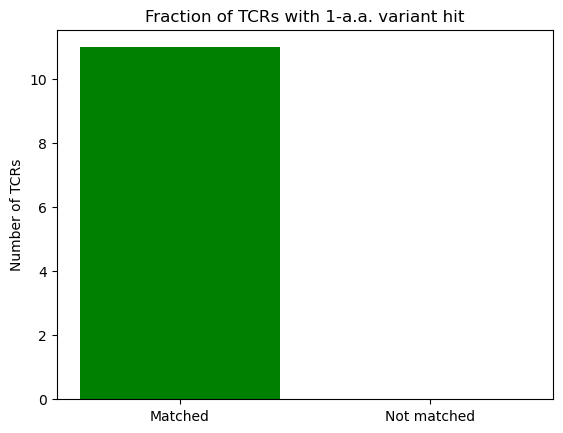

Top 10 Hit Epitopes (1-a.a. variant matches):
'LPRRSGAAGA': 4 hits
'QLIPCMDVV': 1 hits
'NLVPMVATV': 1 hits
'GLTSFFIAI': 1 hits
'MLLKHDVSL': 1 hits
'GLCTLVAML': 1 hits
'RPHERNGFTVL': 1 hits
'FWIDLFETIG': 1 hits
'GILGFVFTL': 1 hits
'ILNVDVFTL': 1 hits


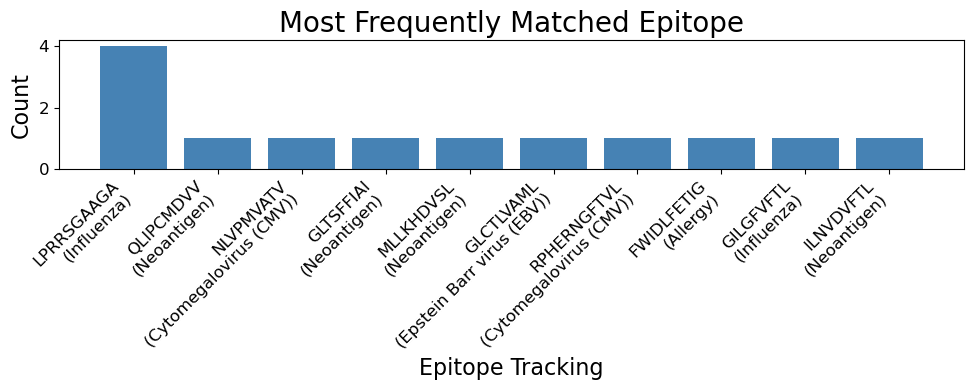


All unique hit epitopes found:
QLIPCMDVV, LPRRSGAAGA, NLVPMVATV, GLTSFFIAI, MLLKHDVSL, GLCTLVAML, RPHERNGFTVL, FWIDLFETIG, GILGFVFTL, ILNVDVFTL, EAAGIGILTV
Epitope hits per original TCR (showing variant sequence for each epitope):
Original TCR: CASSEAGGYNEQFF
   No epitope found.
--------------------------------------------------------------------------------
Original TCR: CASSGQGSGANVLTF
   No epitope found.
--------------------------------------------------------------------------------
Original TCR: CASSLDFYNEQFF
   Epitope: LPRRSGAAGA  |  Variant TCR: CASSLDSYNEQFF
--------------------------------------------------------------------------------
Original TCR: CASSLEAEETQYF
   No epitope found.
--------------------------------------------------------------------------------
Original TCR: CASSLGQGQETQYF
   Epitope: EAAGIGILTV  |  Variant TCR: CASSWGQGQETQYF
   Epitope: FWIDLFETIG  |  Variant TCR: CASSLGQGGETQYF
   Epitope: GILGFVFTL  |  Variant TCR: CASSLGQGRETQYF
   Epitope: ILNVDVF

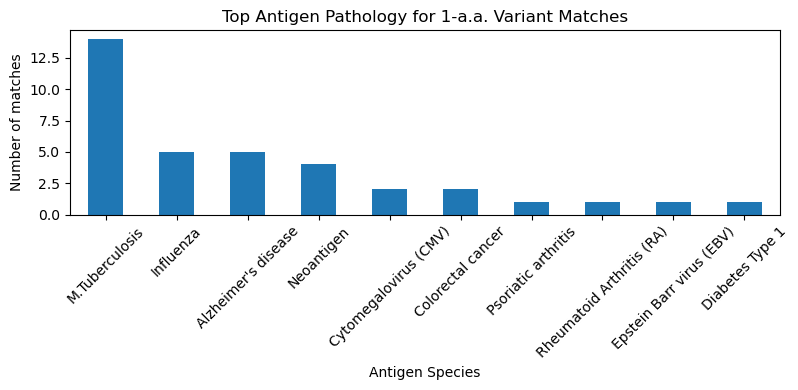

In [28]:
plot_one_near_match(results_largest_mcpas, meta_largest, tcr_column='cdr3_sequence')
print_and_plot_hit_epitopes(results_largest_mcpas)
print_epitope_hits_per_tcr_with_variants(results_largest_mcpas)
plot_epitope_source_dist(results_largest_mcpas)

In [29]:
def plot_hits_and_epitope_diversity_grouped(
    results,
    tcr_db,
    tcr_column="cdr3_sequence",
    sort_by="hits",   # "hits"/"epitopes"/None
    top_n=None,
    title="McPAS 1-aa Variant: Hits vs Epitope Diversity per TCR"
):
    results_df = pd.DataFrame(results)

    # Universe of queries (include zero-hit TCRs)
    queries = pd.Index(tcr_db[tcr_column].dropna().astype(str).unique(), name="query")

    # Hits per query
    hits = results_df.groupby("query").size().reindex(queries, fill_value=0).astype(int)

    # Unique epitopes per query
    epi = (results_df.dropna(subset=["epitope"])
                    .groupby("query")["epitope"]
                    .nunique()
                    .reindex(queries, fill_value=0)
                    .astype(int))

    plot_df = pd.DataFrame({"hits": hits, "unique_epitopes": epi})

    # Sorting
    if sort_by == "hits":
        plot_df = plot_df.sort_values(["hits", "unique_epitopes"], ascending=False)
    elif sort_by == "epitopes":
        plot_df = plot_df.sort_values(["unique_epitopes", "hits"], ascending=False)

    if top_n is not None:
        plot_df = plot_df.head(top_n)

    x = np.arange(len(plot_df))
    width = 0.42

    plt.figure(figsize=(max(10, 0.5 * len(plot_df)), 4.5))
    plt.bar(x - width/2, plot_df["hits"].values, width=width, label="Total hits")
    plt.bar(x + width/2, plot_df["unique_epitopes"].values, width=width, label="Unique epitopes")

    plt.xticks(x, plot_df.index.astype(str), rotation=60, ha="center", fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Count", fontsize=16)
    plt.xlabel("TCR", fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend(frameon=False, fontsize=14)
    plt.tight_layout()
    save_plot("../colon/epitope_hits_vs_diversity.svg", format="svg", bbox_inches="tight")
    plt.show()

    return plot_df


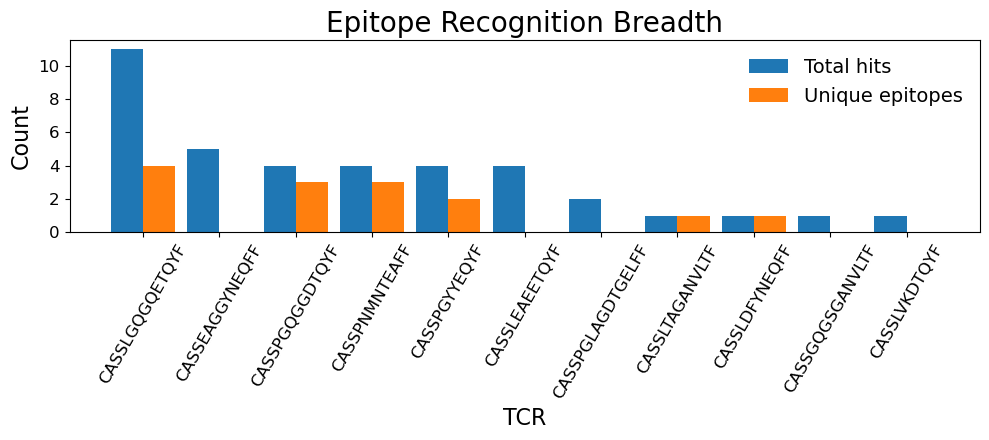

In [30]:
plot_df = plot_hits_and_epitope_diversity_grouped(
    results=results_largest_mcpas,
    tcr_db=meta_largest,
    tcr_column="cdr3_sequence",
    sort_by="hits",
    title="Epitope Recognition Breadth")


### Random Sampling

We will use Monte-Carlo approach (one sided p) from a permutation-style null.

In [31]:
def match_queries_to_mcpas_1aa(queries, mcpas_df: pd.DataFrame, db_col="CDR3.beta.aa"):
    """
    Returns a tidy long table with one row per (query, matched_public_tcr, epitope, ...).
    """
    results = []
    queries = pd.Series(list(queries)).dropna().astype(str).unique()

    for q in queries:
        hits = find_single_mutation_hits(q, mcpas_df, db_col=db_col)
        for _, row in hits.iterrows():
            results.append({
                "query": q,
                "match": row.get(db_col, None),
                "epitope": row.get("Epitope.peptide", None),
                "antigen_pathology": row.get("Pathology", None), 
                "host_species": row.get("Species", None),
                "category": row.get("Category", None),
                "antigen_protein": row.get("Antigen.protein", None),
                "mhc": row.get("MHC", None),
                "reference_id": row.get("PubMed.ID", None),
            })

    out = pd.DataFrame(results)
    if out.empty:
        return out

    # Drop exact duplicates if McPAS has repeated identical evidence rows
    out = out.drop_duplicates(subset=["query", "match", "epitope", "reference_id"])
    return out


In [32]:
from tqdm import tqdm

def compute_epitope_metrics(matched_df: pd.DataFrame, original_epitopes=None):
    if matched_df is None or matched_df.empty:
        metrics = {
            "n_hits": 0,
            "n_unique_epitopes": 0,
            "n_antigen_pathologies": 0,
            "n_antigen_proteins": 0,
            "n_mhc_types": 0,
        }
        if original_epitopes is not None:
            metrics["epitope_overlap_with_original"] = 0
        return metrics

    metrics = {
        "n_hits": int(len(matched_df)),
        "n_unique_epitopes": int(matched_df["epitope"].nunique(dropna=True)),
        "n_antigen_pathologies": int(matched_df["antigen_pathology"].nunique(dropna=True)),
        "n_antigen_proteins": int(matched_df["antigen_protein"].nunique(dropna=True)),
        "n_mhc_types": int(matched_df["mhc"].nunique(dropna=True)),
    }

    if original_epitopes is not None:
        matched_epitopes = set(matched_df["epitope"].dropna())
        metrics["epitope_overlap_with_original"] = int(len(matched_epitopes & set(original_epitopes)))

    return metrics

def sample_random_tcrs(clonotype_df: pd.DataFrame, n: int, rng: np.random.Generator, cdr3_col="aaSeqCDR3"):
    """
    Returns a 1-column DataFrame with aaSeqCDR3 only (keep sampling minimal).
    """
    if cdr3_col not in clonotype_df.columns:
        raise ValueError(f"Expected column {cdr3_col!r} in clonotype_df")

    pool = clonotype_df[cdr3_col].dropna().astype(str).drop_duplicates()
    if len(pool) < n:
        raise ValueError(f"Pool too small: need {n}, have {len(pool)} unique CDR3s")

    sampled = rng.choice(pool.to_numpy(), size=n, replace=False)
    return pd.DataFrame({cdr3_col: sampled})


def run_random_sampling_mcpas(
    pool_df: pd.DataFrame,
    mcpas_df: pd.DataFrame,
    n_iter: int,
    group_size: int,
    original_epitopes,
    seed: int = 0,
    pool_cdr3_col: str = "aaSeqCDR3",
    mcpas_cdr3_col: str = "CDR3.beta.aa",
):
    """
    Function Goals:
      - sample group_size random CDR3s from pool_df, n_iter times
      - run 1-aa McPAS matching
      - compute metrics per iteration
    Returns: metrics_df, all_matches_df
    """
    rng = np.random.default_rng(seed)

    metrics_rows = []
    matched_rows = []

    for it in tqdm(range(n_iter), desc="Random sampling (McPAS 1-aa)"):
        sample_df = sample_random_tcrs(pool_df, n=group_size, rng=rng, cdr3_col=pool_cdr3_col)
        queries = sample_df[pool_cdr3_col].tolist()

        matched = match_queries_to_mcpas_1aa(queries, mcpas_df, db_col=mcpas_cdr3_col)
        matched["iteration"] = it
        matched_rows.append(matched)

        metrics = compute_epitope_metrics(matched, original_epitopes=original_epitopes)
        metrics["iteration"] = it
        metrics_rows.append(metrics)

    metrics_df = pd.DataFrame(metrics_rows)
    all_matches_df = pd.concat(matched_rows, ignore_index=True) if matched_rows else pd.DataFrame()
    return metrics_df, all_matches_df


def get_public_tcr_pool(clonotype_df, min_samples=5):
    """Return a filtered clonotype_df of only TCRs with at least min_samples unique sample occurrences."""
    tcr_publicity = (
        clonotype_df.groupby('aaSeqCDR3')['Sample_ID']
        .nunique()
        .reset_index(name='sample_count')
        .query(f'sample_count >= {min_samples}')
    )

    return clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_publicity['aaSeqCDR3'])]

In [33]:
# Precompute once
public_clonotype_df = get_public_tcr_pool(clonotype_df, min_samples=CORR_PUB_THRESHOLD)

In [34]:
# Original group
original_matches = match_queries_to_mcpas_1aa(
    queries=meta_largest["cdr3_sequence"],
    mcpas_df=mcpas,
    db_col="CDR3.beta.aa"
)

original_epitopes = set(original_matches["epitope"].dropna())
original_metrics = compute_epitope_metrics(original_matches, original_epitopes=original_epitopes)

# Random groups (size=11)
random_metrics_df, random_matches_df = run_random_sampling_mcpas(
    pool_df=public_clonotype_df, 
    mcpas_df=mcpas,
    n_iter=500,
    group_size=11,
    original_epitopes=original_epitopes,
    seed=42,
    pool_cdr3_col="aaSeqCDR3",
    mcpas_cdr3_col="CDR3.beta.aa",
)


Random sampling (McPAS 1-aa): 100%|██████████| 500/500 [10:34<00:00,  1.27s/it]


In [35]:
# Compare length distributions
lcc_lengths = meta_largest["cdr3_sequence"].str.len()
public_lengths = public_clonotype_df["aaSeqCDR3"].str.len()

print("LCC lengths:")
print(lcc_lengths.value_counts().sort_index())

print("\nPublic pool lengths:")
print(public_lengths.value_counts(normalize=True).sort_index().round(3))


LCC lengths:
cdr3_sequence
12    2
13    3
14    4
15    1
16    1
Name: count, dtype: int64

Public pool lengths:
aaSeqCDR3
4     0.000
5     0.000
6     0.000
7     0.000
8     0.000
9     0.001
10    0.006
11    0.063
12    0.136
13    0.259
14    0.285
15    0.200
16    0.045
17    0.005
18    0.001
19    0.000
Name: proportion, dtype: float64


visualization

In [36]:
def empirical_pvalue(random_vals, observed, alternative="greater"):
    random_vals = np.asarray(random_vals)
    n = random_vals.size

    if alternative == "greater":
        p = (np.sum(random_vals >= observed) + 1) / (n + 1)
    elif alternative == "less":
        p = (np.sum(random_vals <= observed) + 1) / (n + 1)
    elif alternative == "two-sided":
        center = np.median(random_vals)
        dist_obs = abs(observed - center)
        p = (np.sum(np.abs(random_vals - center) >= dist_obs) + 1) / (n + 1)
    else:
        raise ValueError("alternative must be 'greater', 'less', or 'two-sided'")
    return float(p)

def plot_null_hist(random_metrics_df, original_metrics, metric_key, bins=30,
                   alternative="greater", title=None):
    vals = random_metrics_df[metric_key].dropna().to_numpy()
    obs = float(original_metrics[metric_key])

    p = empirical_pvalue(vals, obs, alternative=alternative)
    mu, sd = float(np.mean(vals)), float(np.std(vals, ddof=1)) if len(vals) > 1 else (float(np.mean(vals)), np.nan)
    z = (obs - mu) / sd if sd and not np.isnan(sd) and sd > 0 else np.nan
    perc = float((np.sum(vals <= obs) / len(vals)) * 100)

    plt.figure(figsize=(7, 4))
    plt.hist(vals, bins=bins, density=True, edgecolor="black")
    plt.axvline(obs, linestyle="--", label=f"Observed ({obs:.2f})")
    plt.title(title or f"Null distribution: {metric_key}")
    plt.xlabel(metric_key)
    plt.ylabel("Density")
    plt.legend(frameon=False)

    txt = f"n={len(vals)}  mean={mu:.2f}  sd={sd:.2f}\n" \
          f"percentile={perc:.1f}  z={z:.2f}\n" \
          f"empirical p({alternative})={p:.4g}"
    plt.gcf().text(0.72, 0.78, txt, fontsize=9, va="top")

    plt.tight_layout()
    plt.show()

    return {"p": p, "mean": mu, "sd": sd, "z": z, "percentile": perc}



In [48]:
def plot_null_ecdf(random_metrics_df, original_metrics, metric_key,
                   alternative="greater", title=None):
    vals = np.sort(random_metrics_df[metric_key].dropna().to_numpy())
    obs = float(original_metrics[metric_key])
    n = len(vals)

    p = empirical_pvalue(vals, obs, alternative=alternative)
    y = np.arange(1, n + 1) / n

    plt.figure(figsize=(6.5, 4))
    plt.plot(vals, y)
    plt.axvline(obs, linestyle="--", label=f"Observed ({obs:.2f})")
    plt.title(title or f"ECDF under null: {metric_key}")
    plt.xlabel(metric_key)
    plt.ylabel("ECDF")
    plt.legend(frameon=False)

    # Percentile annotation
    perc = (np.sum(vals <= obs) / n) * 100
    plt.gcf().text(0.68, 0.20, f"n={n}\npercentile={perc:.1f}\nempirical p={p:.4g}",
                   fontsize=10)

    plt.tight_layout()
    plt.show()

    return {"p": p, "percentile": float(perc)}

def plot_metric_scatter(random_metrics_df, original_metrics, x_metric, y_metric, title=None, x_title=None, y_title=None):
    x = random_metrics_df[x_metric].to_numpy()
    y = random_metrics_df[y_metric].to_numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.4, s=15)
    plt.scatter([original_metrics[x_metric]], [original_metrics[y_metric]], s=80, label="Observed")
    plt.xlabel(x_title if x_title is not None else x_metric.replace('_', ' ').title(), fontsize=16)
    plt.ylabel(y_title if y_title is not None else y_metric.replace('_', ' ').title(), fontsize=16)
    plt.title(title or f"{y_metric} vs {x_metric} (null + observed)", fontsize = 20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(frameon=False, fontsize=14, handletextpad=0.2,scatterpoints=1)
    plt.tight_layout()
    save_plot(f"../colon/{title}.svg", format="svg", bbox_inches="tight")
    plt.show()

def plot_epitope_recurrence_from_matches(matched_df_all, original_epitope_set, top_n=20):
    """
    matched_df_all: concatenated matches across iterations, must include:
      - 'iteration'
      - 'epitope'
    """
    df = matched_df_all.dropna(subset=["epitope"]).copy()

    # Count in how many iterations each epitope appears (not raw row counts)
    epi_iter = df.groupby("epitope")["iteration"].nunique().sort_values(ascending=False)

    # Restrict to epitopes seen in the observed set
    epi_iter = epi_iter.loc[epi_iter.index.intersection(original_epitope_set)]
    if epi_iter.empty:
        print("None of the observed epitopes appeared in the random runs.")
        return

    epi_iter = epi_iter.head(top_n)

    plt.figure(figsize=(10, 4))
    plt.bar(epi_iter.index.astype(str), epi_iter.values)
    plt.title("Observed epitopes: recurrence across random groups")
    plt.xlabel("Epitope")
    plt.ylabel("Number of random iterations where epitope appears")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

def plot_bar_with_empirical_p(random_metrics_df, original_metrics, metric_key,
                              alternative="greater", title=None, y_title=None):
    """
    Paper-style summary plot:
    - bar for observed
    - bar for random mean
    - empirical one-sided p-value computed from actual random sample size
    """
    obs = float(original_metrics[metric_key])
    vals = random_metrics_df[metric_key].dropna().to_numpy()
    n = len(vals)
    if n == 0:
        raise ValueError(f"No values found for metric_key={metric_key!r} in random_metrics_df")

    if alternative == "greater":
        p = (np.sum(vals >= obs) + 1) / (n + 1)
    elif alternative == "less":
        p = (np.sum(vals <= obs) + 1) / (n + 1)
    else:
        raise ValueError("alternative must be 'greater' or 'less'")

    mean_null = float(np.mean(vals))
    std_null = float(np.std(vals, ddof=1)) # Sample Standard Deviation
    
    # Plot the "Observed" bar ALONE (No error params)
    bar1 = plt.bar(["Observed"], [obs], color="#ce5a5a")
    
    # Plot the "Random" bar ALONE (With error params)
    bar2 = plt.bar(["Random mean"], [mean_null], 
                   yerr=std_null, 
                   capsize=10,    # Cap only appears here
                   color="#649fc9")

    # Combine bars list for text labeling loop
    bars = list(bar1) + list(bar2)

    plt.xticks(fontsize=16)  
    if y_title is None:
        plt.ylabel(metric_key.replace("_", " ").title())
    else:
        plt.ylabel(y_title, fontsize=16)
    plt.title(title or f"{metric_key.replace('_', ' ').title()} (empirical p)", fontsize=20)

    # Put numeric values inside bars 
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height * 0.5,                 # middle of the bar
             f"{height:.2f}", ha="center", va="center", color="white",
               fontsize=12, fontweight="bold"
        )

    # Put p-value in top-right corner (axes coords) 
    plt.text(
        0.98, 0.95, f"p = {p:.4g}\n(n = {n})", ha="right", va="top",
          transform=plt.gca().transAxes,fontsize=11, fontweight="bold"
    )

    plt.tight_layout()
    
    save_plot(f"../colon/{title}.svg", format="svg", bbox_inches="tight")
    plt.show()
    
    return float(p)


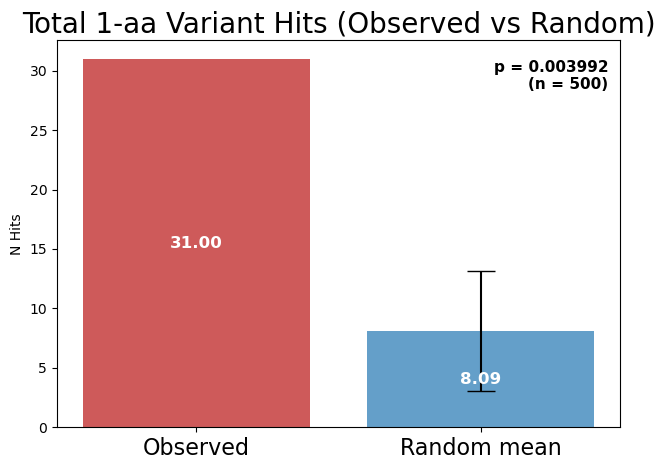

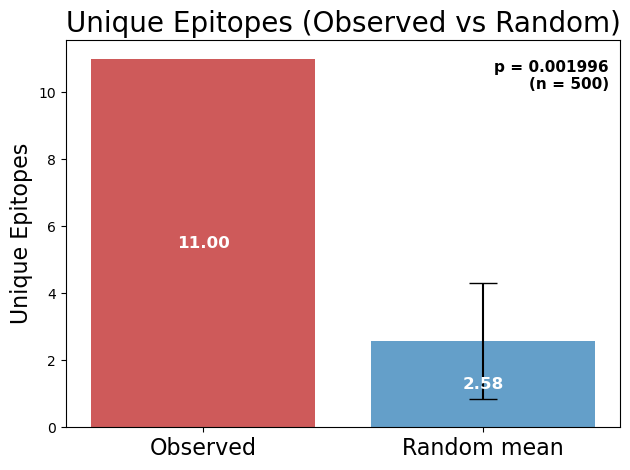

In [49]:
p_hits = plot_bar_with_empirical_p(
    random_metrics_df=random_metrics_df,
    original_metrics=original_metrics,
    metric_key="n_hits",
    alternative="greater",
    title="Total 1-aa Variant Hits (Observed vs Random)"
)

p_epi = plot_bar_with_empirical_p(
    random_metrics_df=random_metrics_df,
    original_metrics=original_metrics,
    metric_key="n_unique_epitopes",
    alternative="greater",
    title="Unique Epitopes (Observed vs Random)",
    y_title="Unique Epitopes"
)


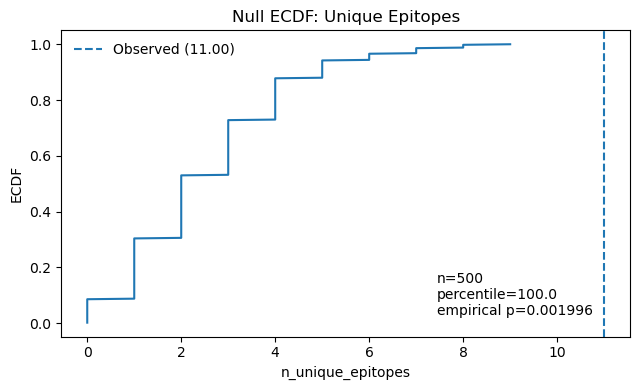

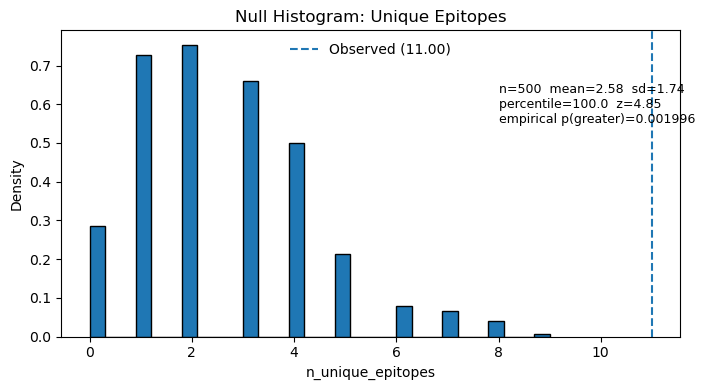

In [39]:
_ = plot_null_ecdf(
    random_metrics_df=random_metrics_df,
    original_metrics=original_metrics,
    metric_key="n_unique_epitopes",
    alternative="greater",
    title="Null ECDF: Unique Epitopes"
)

_ = plot_null_hist(
    random_metrics_df=random_metrics_df,
    original_metrics=original_metrics,
    metric_key="n_unique_epitopes",
    alternative="greater",
    title="Null Histogram: Unique Epitopes"
)


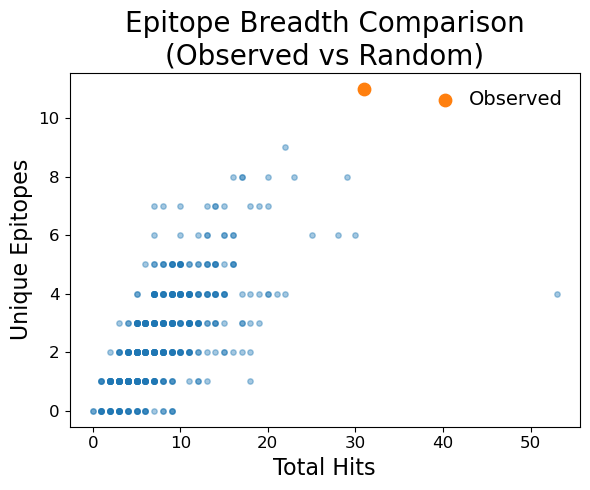

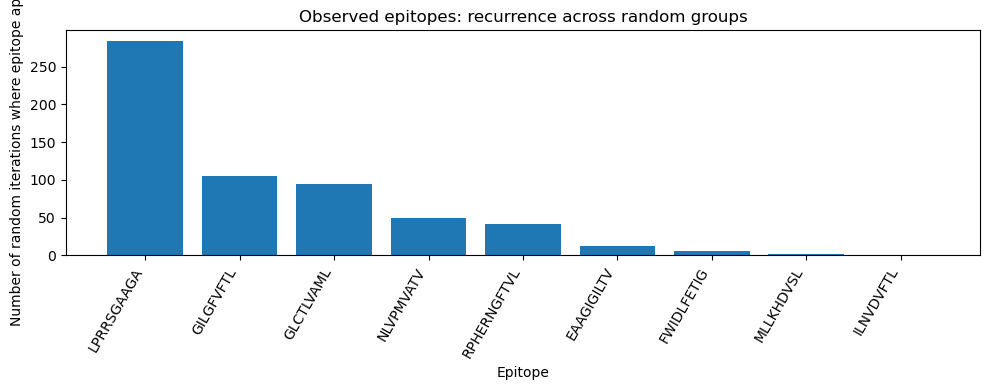

In [40]:
plot_metric_scatter(
    random_metrics_df=random_metrics_df,
    original_metrics=original_metrics,
    x_metric="n_hits",
    y_metric="n_unique_epitopes",
    title="Epitope Breadth Comparison\n(Observed vs Random)",
    x_title="Total Hits",
    y_title='Unique Epitopes'
)

plot_epitope_recurrence_from_matches(
    matched_df_all=random_matches_df,
    original_epitope_set=original_epitopes,
    top_n=20
)


Even under a conservative empirical null composed of equally public, length-matched TCRs, none of 500 random groups achieved epitope breadth comparable to the overlap-network TCR set, yielding an empirical one-sided p ≈ 0.002 (resolution-limited by the number of randomizations).

# CDR Alpha Clonotypes

In [22]:
MIXCR_DIR_ALPHA = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRA/"


In [25]:
# Load Metadata
meta_df = pd.read_csv(META_FILE)[["Sample_ID", "extraction_time"]]
# Load and Aggregate MiXCR Files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]

clonotype_dfs = []
for fname in os.listdir(MIXCR_DIR_ALPHA):
    file_path = os.path.join(MIXCR_DIR_ALPHA, fname)
    if os.path.isfile(file_path) and fname.endswith(".tsv"):
        sample_id = fname.split("_")[0]
        try:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_id
            clonotype_dfs.append(df)
        except Exception as e:
            print(f"Warning: Could not read {fname}. Error: {e}")

if not clonotype_dfs:
    raise ValueError("No matching MiXCR files found in the directory.")

clonotype_df_a = pd.concat(clonotype_dfs, ignore_index=True)
clonotype_df_a = clonotype_df_a.merge(meta_df, on="Sample_ID", how="inner")
clonotype_df_a['extraction_time'] = pd.to_numeric(clonotype_df_a['extraction_time'], errors='coerce')

# Remove samples with missing or invalid time data
valid_mask = clonotype_df_a['extraction_time'].notnull()
excluded_samples = clonotype_df_a.loc[~valid_mask, 'Sample_ID'].unique()

if len(excluded_samples) > 0:
    print(f"Excluding {len(excluded_samples)} samples due to missing/invalid extraction_time: {excluded_samples}")
    clonotype_df_a = clonotype_df_a.loc[valid_mask].copy()

clonotype_df_a["group"] = np.where(
    clonotype_df_a["extraction_time"] <= TIME_THRESHOLD, "fast", "slow"
)

print(f"Final processed dataset: {clonotype_df_a['Sample_ID'].nunique()} unique samples.")

Excluding 1 samples due to missing/invalid extraction_time: ['P4-S1']
Final processed dataset: 211 unique samples.
